# Look for valid questions in comments
We've looked in prior work for valid questions in comment data based on "standalone" questions ([here](sample_label_comment_questions.ipynb)) but the data sparsity is pretty bad, i.e. about 15000/940000 $\sim$ 2% of comments have a valid question.

Let's expand our search and get all questions that:

1. occur at the beginning of a comment
2. receive at least one reply from the OP or from another commenter

## Table of contents

1. [Load data](#Load-data)
2. [Test comment-initial questions](#Comment-initial-questions)
3. [Test questions that receive OP reply](#Question-receives-reply-from-OP)
4. [Questions all text](#Free-text-questions)
5. [Identify valid question automatically](#Identify-valid-questions-automatically)
	1. [Test word overlap](#Test-question-overlap)
	2. [Test clarification question classiication](#Test-clarification-questions)
6. [Test "INFO" questions](#Bootstrap-from-"INFO"-comments)
7. [Test automatic question labelling](#Label-all-questions-in-comments-as-valid/correct)
8. [Testing labels from multiple annotators](#Second-round-of-question-labels)
    1. [Final round](#Test-data-from-annotators:-round-2)
9. [Debug data flow](#Debug-data-flow)

## Load data

In [1]:
import pandas as pd
import os
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_zipped_json_data
data_dir = '../../data/reddit_data/'
comment_data_files = list(filter(lambda x: x.startswith('subreddit_comments'), os.listdir(data_dir)))
comment_data_files = list(map(lambda x: os.path.join(data_dir, x), comment_data_files))
comment_data = pd.concat(list(map(lambda x: load_zipped_json_data(x), comment_data_files)), axis=0)
display(comment_data.head())
print(f'{comment_data.shape[0]} comments')

ending data collection early because error Compressed file ended before the end-of-stream marker was reached
ending data collection early because error Compressed file ended before the end-of-stream marker was reached
ending data collection early because error Compressed file ended before the end-of-stream marker was reached
ending data collection early because error Compressed file ended before the end-of-stream marker was reached
ending data collection early because error Compressed file ended before the end-of-stream marker was reached


,author,author_flair_text,author_fullname,body,created_utc,edited,id,parent_id,score,subreddit
0,grumpypantsoldman,None,t2_27ps6lxw,NTA. I think you dodged a bullet. Who needs a ...,1541030405,False,e8tkic1,t3_9t3n27,14,AmItheAsshole
1,unknown_salmon,None,t2_q57txtp,I do feel for you. Do you think you could be b...,1541030426,False,e8tkj26,t3_9t1u2e,2,Advice
2,vld-s,None,t2_14p3sr,YNTA. He made you uncomfortable and you distan...,1541030467,False,e8tkkjt,t3_9t3xz3,3,AmItheAsshole
3,Prepperpoints2Ponder,None,t2_11lpfa,Manufacturing here. Me and spouse will be payi...,1541030470,False,e8tkkns,t3_9t2e8e,2,personalfinance
4,juliej891,None,t2_1mwezovi,I think you’re going to go out of your way to ...,1541030493,False,e8tklij,t3_9t4afp,1,Advice


4371692 comments


In [3]:
## submission
submission_data = load_zipped_json_data('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz')
display(submission_data.head())

,author,author_flair_text,created_utc,edited,id,num_comments,score,selftext,subreddit,title,category,author_fullname
0,deepsouthsloth,None,1514764840,False,7nby0l,7,1,26M/married/2 kids\n\nEmployer match is 50% up...,personalfinance,Should I continue with 401k despite terrible e...,NaN,NaN
1,CapableCounteroffer,None,1514764890,False,7nby5t,5,0,"On November 24th, I called AT&amp;T to inquire...",legaladvice,[FL] Issue getting AT&amp;T to pay early termi...,NaN,NaN
2,pinkcrayon69,None,1514764948,False,7nbybf,9,3,I live in south OC but I need to move out of m...,personalfinance,I need to move out in a month. What should I p...,NaN,NaN
3,bobshellby,Needs 64bit Windows...,1514765040,False,7nbykz,6,0,Are there keycaps for the Microsoft wireless k...,pcmasterrace,Keyboard keycap help,NaN,NaN
4,j0sh135742,None,1514765064,1514765420.0,7nbyno,4,0,"So in MGL Part 1, Title 15, Chapter 94G, Secti...",legaladvice,Quick question about Medical Marijuana.,NaN,NaN


In [41]:
## combine data
comment_data = comment_data.assign(**{'parent_id':comment_data.loc[:, 'parent_id'].apply(lambda x: x.split('_')[-1])})
submission_data.rename(columns={'id' : 'parent_id', 'created_utc' : 'parent_created', 'selftext' : 'parent_text', 'title' : 'parent_title', 'edited' : 'parent_edited', 'author' : 'parent_author'}, inplace=True)
comment_submission_data = pd.merge(
    comment_data, 
    submission_data.loc[:, ['parent_id', 'parent_created', 'parent_text', 'parent_title', 'parent_edited', 'parent_author']],
    on='parent_id'
)
# remove duplicate questions
comment_submission_data.drop_duplicates(['parent_id', 'body'], inplace=True)

In [42]:
print(f'{comment_submission_data.shape[0]} comments total')

4193267 comments total


In [12]:
## extract questions
from data_helpers import extract_questions_all_data
comment_data = comment_data.assign(**{
    'questions' : extract_questions_all_data(comment_data.loc[:, 'body'].values)
})

100%|██████████| 4371692/4371692 [29:58<00:00, 2431.14it/s] 


In [43]:
comment_submission_data = pd.merge(
    comment_submission_data, comment_data.loc[:, ['id', 'questions']],
    on='id'
)

In [48]:
question_comment_data = comment_submission_data[comment_submission_data.loc[:, 'questions'].apply(lambda x: len(x) > 0)]

In [84]:
## save for posterity/sampling comparison
question_comment_data.to_csv('../../data/reddit_data/advice_subreddit_question_data_for_validity_check.gz', sep='\t', compression='gzip')

### Comment-initial questions

In [49]:
from tqdm import tqdm
tqdm.pandas()
import re
question_comment_data = question_comment_data.assign(**{
    'question_occurs_post_initial' : question_comment_data.progress_apply(lambda x: re.match(f"^{re.escape(x.loc['questions'][0])}", x.loc['body']) is not None, axis=1)
})

100%|██████████| 873193/873193 [04:46<00:00, 3051.14it/s]


In [50]:
print(f'{question_comment_data.loc[:, "question_occurs_post_initial"].sum()}/{question_comment_data.shape[0]} post-initial questions')

360472/873193 post-initial questions


Let's check out a sample of the questions to determine their validity.

In [51]:
import numpy as np
np.random.seed(123)
questions_per_subreddit = 50
sample_post_initial_question_data = []
for subreddit_i, data_i in question_comment_data.groupby('subreddit'):
    data_i.reset_index(inplace=True)
    # remove parent author comments
    data_i = data_i[data_i.loc[:, 'parent_author']!=data_i.loc[:, 'author']]
    valid_data_i = data_i[data_i.loc[:, 'question_occurs_post_initial']]
    sample_data_i = valid_data_i.loc[np.random.choice(valid_data_i.index, questions_per_subreddit, replace=False), :]
    sample_data_i.sort_values('parent_id', inplace=True, ascending=True)
    sample_data_i = sample_data_i.assign(**{'question' : sample_data_i.loc[:, 'questions'].apply(lambda x: x[0])})
    sample_post_initial_question_data.append(sample_data_i.loc[:, ['parent_id', 'id', 'parent_title', 'parent_text', 'body', 'question']])
sample_post_initial_question_data = pd.concat(sample_post_initial_question_data, axis=0)

In [52]:
## out file
sample_post_initial_question_data.to_csv('../../data/reddit_data/sample_advice_subreddit_post_initial_questions.tsv', sep='\t', index=False)

After labeling, let's see what the rate of valid questions appears to be for this sample.

In [78]:
sample_post_initial_question_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_post_initial_question_labels.tsv', sep='\t', index_col=False)

In [79]:
## add subreddit info
sample_post_initial_question_label_data = pd.merge(
    sample_post_initial_question_label_data, question_comment_data.loc[:, ['subreddit', 'parent_id']],
    on='parent_id', how='left',
)
## remove duplicates??
sample_post_initial_question_label_data.drop_duplicates(['parent_id', 'id'], inplace=True)

In [80]:
print(sample_post_initial_question_label_data.shape)

(250, 10)


In [81]:
## get overall label counts
label_vars = ['question_is_relevant', 'question_is_clarification', 'post_contains_answer']
N = sample_post_initial_question_label_data.shape[0]
for label_var_i in label_vars:
    print(f'**** testing var {label_var_i} ****')
    print(sample_post_initial_question_label_data.loc[:, label_var_i].value_counts()/N)
## get label counts per subreddit

for label_var_i in label_vars:
    print(f'**** testing var {label_var_i} ****')
    for subreddit_j, data_j in sample_post_initial_question_label_data.groupby('subreddit'):
        print(f'---- testing subreddit {subreddit_j} ----')
        print(data_j.loc[:, label_var_i].value_counts()/data_j.shape[0])

**** testing var question_is_relevant ****
1    0.952
0    0.048
Name: question_is_relevant, dtype: float64
**** testing var question_is_clarification ****
1    0.6
0    0.4
Name: question_is_clarification, dtype: float64
**** testing var post_contains_answer ****
0    0.988
1    0.012
Name: post_contains_answer, dtype: float64
**** testing var question_is_relevant ****
---- testing subreddit Advice ----
1    0.96
0    0.04
Name: question_is_relevant, dtype: float64
---- testing subreddit AmItheAsshole ----
1    0.9
0    0.1
Name: question_is_relevant, dtype: float64
---- testing subreddit legaladvice ----
1    0.94
0    0.06
Name: question_is_relevant, dtype: float64
---- testing subreddit pcmasterrace ----
1    0.96
0    0.04
Name: question_is_relevant, dtype: float64
---- testing subreddit personalfinance ----
1    1.0
Name: question_is_relevant, dtype: float64
**** testing var question_is_clarification ****
---- testing subreddit Advice ----
1    0.6
0    0.4
Name: question_is_clar

Most questions are relevant, about half the questions are actually clarifications, and most of the questions reference information not contained in the post.

For the clarification discrepancy: most clarification questions come from `legaladvice` and `pcmasterrace`, other subreddits are closer to 50-50 split.

In [83]:
valid_post_initial_question_label_data = sample_post_initial_question_label_data[
    (sample_post_initial_question_label_data.loc[:, 'question_is_relevant']==1) &
    (sample_post_initial_question_label_data.loc[:, 'question_is_clarification']==1) &
    (sample_post_initial_question_label_data.loc[:, 'post_contains_answer']==0)
]
print(f'{valid_post_initial_question_label_data.shape[0]}/{sample_post_initial_question_label_data.shape[0]} valid questions overall')
for subreddit_i, data_i in sample_post_initial_question_label_data.groupby('subreddit'):
    print(f'**** testing subreddit {subreddit_i} ****')
    valid_data_i = data_i[
    (data_i.loc[:, 'question_is_relevant']==1) &
    (data_i.loc[:, 'question_is_clarification']==1) &
    (data_i.loc[:, 'post_contains_answer']==0)
]
    print(f'{valid_data_i.shape[0]}/{data_i.shape[0]} valid questions overall')

148/250 valid questions overall
**** testing subreddit Advice ****
30/50 valid questions overall
**** testing subreddit AmItheAsshole ****
24/50 valid questions overall
**** testing subreddit legaladvice ****
34/50 valid questions overall
**** testing subreddit pcmasterrace ****
26/50 valid questions overall
**** testing subreddit personalfinance ****
34/50 valid questions overall


All subreddits have at least 50% valid questions.

### Question receives reply from OP

In [86]:
## which questions had at least one documented response from OP?
pd.set_option('display.max_colwidth',200)
post_author_response_comment_data = comment_submission_data[comment_submission_data.loc[:, 'parent_author']==comment_submission_data.loc[:, 'author']]
display(post_author_response_comment_data.loc[:, ['parent_title', 'body', 'author', 'parent_id']].head(20))

,parent_title,body,author,parent_id
114,Selling car to private party,Thanks all. I will keep this in mind.,iptvfanboy,9t4d1p
3093,"Payroll Tax hike surprise, is this normal? Salary+bonus+commission",Thank you all for the quick replies. I didn’t realize that supplemental wages get taxed/withheld different than if I only made a base wage. \n\nI’m new to the whole commission game so I’m still ge...,David_Warren,9t2y1p
3349,As a security guard is there a way i can get support living on my own and get a car?,Aw man i spelled the title wrong - shoulda been “As a security guard is there a way i can support living on my own and get a car?”,dethmetalz69,9t4lg2
3489,"Large amount of CC debt, P2P lending?",would prosper even approve me? i have the pre-approval offers but the apr is insane. 30-31% apr :(((((((((((,Public_Beautiful,9sslcp
3541,AITA for returning a bag full of valuables but keeping some of the money,"Lots of great answers. I knew it was a shitty thing to do before I made the post, but brushed it aside as ""meh the guy seems rich enough maybe he won't even notice"". I now realize with the overwhe...",michel-michel-michel,9syt81
3605,How should I tell someone I was raped?,"Thanks to everyone helping me out right now, I’m looking into talking to a therapist soon, but with the police part, I have no way to look into. I am unaware of who this person was, and seeing as ...",HDBeats,9sym49
3642,"Can I trust my therapist? She persistently advises me to stop taking antidepressants and Instead see her more often, I made made it clear I don’t want to stop taking them a few times.","I get this, but it’s sort of about fire fighting right now. I got so low about a month ago that I wanted to hurt myself, i have always struggled with mental health but being that low has only happ...",palaisdemons,9t3qn2
4017,Pc won't display with gpu or onboard graphics,Thank you for your help guys. It was the PSU but not the PSU. Somehow the 6pin cable got friend but today I realized my PSU had two so I connected the other cable and it works now,xiaomismartphone,9skoyd
4018,Pc won't display with gpu or onboard graphics,I removed cmos battery and it booted once to a screen with error occurs cmos something post error but couldn't do anything cause my keyboard wasn't plugged and then it went black again. Can't repl...,xiaomismartphone,9skoyd
4019,Pc won't display with gpu or onboard graphics,"I managed to get the onboard graphics working but even when I choose to use pci in init first display it doesn't output to GPU even when the fans are spinning, but if I plug the VGA to onboard it ...",xiaomismartphone,9skoyd


Based on the way this data was collected...it looks like the parent author replies are sent to the original post, not to the replies to the post.

We will have to collect this data separately!

In [88]:
from praw import Reddit
from psaw import PushshiftAPI
from datetime import datetime
import pandas as pd

reddit_auth_data = pd.read_csv('../../data/auth_data/reddit_auth.csv', sep=',', index_col=False).iloc[0, :]

client_id = reddit_auth_data.loc['client_id']
client_secret = reddit_auth_data.loc['client_secret']
user_agent = 'user_agent_123'
reddit_api = Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    check_for_async=False,
)

pushshift_reddit_api = PushshiftAPI(reddit_api)

1. Get sample of submissions from each subreddit w/ >1 question in comments
2. Get replies to comments with questions
3. Filter for replies from parent author

In [208]:
import numpy as np
np.random.seed(123)
sample_comments_per_subreddit = 500
post_author_response_sample_comment_data = []
for subreddit_i, data_i in question_comment_data.groupby('subreddit'):
    sample_data_i = data_i.loc[np.random.choice(data_i.index, sample_comments_per_subreddit, replace=False), :]
    post_author_response_sample_comment_data.append(sample_data_i)
post_author_response_sample_comment_data = pd.concat(post_author_response_sample_comment_data, axis=0)

In [209]:
post_author_response_sample_comment_data.head()

,author,author_flair_text,author_fullname,body,created_utc,edited,id,parent_id,score,subreddit,parent_created,parent_text,parent_title,parent_edited,parent_author,questions,question_occurs_post_initial
1729334,TimBurtonsCockRing,None,t2_33frvciw,How is your sex life with your girlfriend? What aspect is there that she does not fulfill that makes you need to reach out to other girls? Can you two work on incorporating this into your sex life...,1558552840,False,eog8f0d,brst3k,1,Advice,1558552232,"Over the past 13 years, since I was 15 (now 28) I've been overly active in online pornography videos. Ive been in a 3 year relationship since 2016 w/ my current GF &amp; everything is perfect. Exc...",I've struggled w/ Porn/masturbation addiction. But today it really bit me in the ass...,1558552520,toastypeanut,"[How is your sex life with your girlfriend?, What aspect is there that she does not fulfill that makes you need to reach out to other girls?, Can you two work on incorporating this into your sex l...",True
2989872,zesty_lemon45,None,t2_28xd3zsc,You do realise you have to pay the money back with interest?,1554971783,False,ekm57rk,bbxg0l,1,Advice,1554971682,"I just turned 18 and I wanted to get a credit card so I can receive funds for work I do online. I under stand what savings accounts, checking accounts, etc. are. How do I get a credit card, what a...",Just turned 18 and want to get a credit card,False,Behnzo,[You do realise you have to pay the money back with interest?],True
221964,weeffex,None,t2_xaxm4,"https://imgur.com/gallery/mkpKEck\n\nThanks, my landlord drilled this hole before i got here so he knows of my plans. Can i use this without knowing much about these kinda setups and attach the li...",1539202911,False,e7j8upg,9n32n4,1,Advice,1539202500,"Hi guys, i just moved out from my parents in to an old apartment and it had this old hanging light in the living room wich is way to low for my liking. Can anybody explain to me how to raise it cl...",I dont know how to raise my light closer to the ceiling...,False,weeffex,[Can i use this without knowing much about these kinda setups and attach the light to it?],False
63513,towhileawaythehours,None,t2_2h1ntm0m,"Id say do it man. Even if it’s just for the most basic reason: what if something happens to either of you while you’re gone? You’d regret it forever. Honestly, it sounds like she’s been a pain in ...",1541800691,False,e9dw788,9voki9,2,Advice,1541799605,"To be simple I'm moving out of the country for a year or two, most of my family and some of friends will be coming to the airport to say goodbye. I'm going to hug everyone goodbye, but a big part ...",Should I hug my mother goodbye,False,kobedziuba,[Even if it’s just for the most basic reason: what if something happens to either of you while you’re gone?],False
781765,spicklemehappy,None,NaN,"Firstly, thank you for sharing your story. It takes a pretty big damn amount of bravery to recount something like that, especially to a bunch of, essentially, strangers. \nSecondly, I know this mi...",1516192896,False,dst9odc,7r0jhd,5,Advice,1516190879,"Being on holiday (from Australia to Europe) at the age of 22 is supposed to be a really cool thing. My journey started out in Saarbrücken near the border of France, which was really cool, because ...",It's taken me 13 years to write this (male sexual assault victim),False,pigry123,"[Is there any family/friends that you haven’t told that you feel like you should/want to?, How is your life going for you at the moment?, Job/study wise?, Relationships (romantic, family, friendsh...",False


In [215]:
def extract_parent_author_replies(comment_id, parent_author, reddit_api, data_vars=['id', 'author', 'body', 'edited', 'created_utc']):
    # get comment children, written by parent author
    child_comments = reddit_api.search_comments(parent_id=comment_id)
    parent_author_comments = list(filter(lambda x: x.author is not None and x.author.name==parent_author, child_comments))
    # convert to usable format
    parent_author_comment_data = pd.DataFrame(list(map(lambda x: x.__dict__, parent_author_comments)))
    if(parent_author_comment_data.shape[0] > 0):
        parent_author_comment_data = parent_author_comment_data.loc[:, data_vars]
        ## add comment ID
        parent_author_comment_data = parent_author_comment_data.assign(**{'comment_id' : comment_id})
        # clean up
        parent_author_comment_data = parent_author_comment_data.assign(**{'author' : parent_author_comment_data.loc[:, 'author'].apply(lambda x: x.name)})
    return parent_author_comment_data

In [206]:
test_comment_id = 'eog8f0d'
test_author = 'toastypeanut'
test_comment_reply_data = extract_parent_author_replies(test_comment_id, test_author, pushshift_reddit_api)
display(test_comment_reply_data)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)


,id,author,body,edited,created_utc,comment_id
0,eogakfi,toastypeanut,Thank you for the response. Our sex life is wonderful. We have sex quite often before we go to bed. \n\nI get this feeling that with my age I'm becoming not as attractive anymore. Which is not tru...,False,1.558554e+09,eog8f0d


In [216]:
## now do it for all the comments lol
import tqdm
parent_author_reply_data = []
for idx_i, data_i in tqdm.tqdm(post_author_response_sample_comment_data.iterrows()):
    comment_id_i = data_i.loc['id']
    parent_author_i = data_i.loc['parent_author']
    parent_author_reply_data_i = extract_parent_author_replies(comment_id_i, parent_author_i, pushshift_reddit_api)
    if(parent_author_reply_data_i.shape[0] > 0):
        parent_author_reply_data.append(parent_author_reply_data_i)
parent_author_reply_data = pd.concat(parent_author_reply_data, axis=0)
## fix column names
parent_author_reply_data.rename(columns={'id' : 'reply_id'}, inplace=True)

2500it [1:01:31,  1.48s/it]


In [229]:
## add subreddit
if('subreddit' not in parent_author_reply_data.columns):
    parent_author_reply_data = pd.merge(
        parent_author_reply_data,
        post_author_response_sample_comment_data.loc[:, ['id', 'subreddit']].rename(columns={'id' : 'comment_id'}),
        on='comment_id', how='left',
    )
## add original comment data
if('comment_body' not in parent_author_reply_data.columns):
    parent_author_reply_data = pd.merge(
        parent_author_reply_data,
        post_author_response_sample_comment_data.loc[:, ['id', 'body']].rename(columns={'body':'comment_body', 'id' : 'comment_id'}),
        on='comment_id'
    )
print(parent_author_reply_data.loc[:, 'subreddit'].value_counts())

pcmasterrace       230
personalfinance    193
Advice             186
legaladvice        144
AmItheAsshole       72
Name: subreddit, dtype: int64


In [248]:
print(parent_author_reply_data.shape[0])

825


In [251]:
## how many of original comments contained at least one Q?
print(f'{comment_data[comment_data.loc[:, "questions"].apply(lambda x: len(x) > 0)].shape[0]}/{comment_data.shape[0]} comments with >1 question')

909577/4371692 comments with >1 question


Using the original sample size, we can estimate that about 825/2500=33% of questions get a response from the author of the OP.

In [226]:
parent_author_reply_data = parent_author_reply_data.rename(columns={'id_x':'reply_id'}).drop('id_y', axis=1)

In [230]:
parent_author_reply_data.head()

,reply_id,author,body,edited,created_utc,comment_id,subreddit,comment_body
0,eogakfi,toastypeanut,Thank you for the response. Our sex life is wonderful. We have sex quite often before we go to bed. \n\nI get this feeling that with my age I'm becoming not as attractive anymore. Which is not tru...,False,1.558554e+09,eog8f0d,Advice,How is your sex life with your girlfriend? What aspect is there that she does not fulfill that makes you need to reach out to other girls? Can you two work on incorporating this into your sex life...
1,ekm5845,Behnzo,Yeah I’m not stupid,False,1.554972e+09,ekm57rk,Advice,You do realise you have to pay the money back with interest?
2,dtmban4,pigry123,Thank-you for your kind words... it's taken me a while just to respond to you.. in fact.. its taken me a while to do anything lately. But that's ok... i'm taking it all a day at a time.\n\nThe big...,False,1.517567e+09,dst9odc,Advice,"Firstly, thank you for sharing your story. It takes a pretty big damn amount of bravery to recount something like that, especially to a bunch of, essentially, strangers. \nSecondly, I know this mi..."
3,ewpqet5,adumbcollegestudent3,lots of green vegetables and fruit and red meat and kind of mid level in carbs I guess and I eat around 1200 calories a day.,False,1.565647e+09,ewpq7s1,Advice,Maybe its related to something you are eating. What does your diet look like?
4,eml3zvo,yeeus11,We talk a ton and she responds really fast to me so i don't think there's other dudes,False,1.557090e+09,eml3u2k,Advice,Hard to tell. Is that all she does? She could be sending the same stuff to 100 other dudes. \n\nDo you spend time talking as well?


It seems like most of the author responses are answers to the questions, so that's a good sign.

Let's get a sample of the questions that received at least one reply from the OP author, then annotate.

In [234]:
display(post_author_response_sample_comment_data.head())

,author,author_flair_text,author_fullname,body,created_utc,edited,id,parent_id,score,subreddit,parent_created,parent_text,parent_title,parent_edited,parent_author,questions,question_occurs_post_initial
1729334,TimBurtonsCockRing,None,t2_33frvciw,How is your sex life with your girlfriend? What aspect is there that she does not fulfill that makes you need to reach out to other girls? Can you two work on incorporating this into your sex life...,1558552840,False,eog8f0d,brst3k,1,Advice,1558552232,"Over the past 13 years, since I was 15 (now 28) I've been overly active in online pornography videos. Ive been in a 3 year relationship since 2016 w/ my current GF &amp; everything is perfect. Exc...",I've struggled w/ Porn/masturbation addiction. But today it really bit me in the ass...,1558552520,toastypeanut,"[How is your sex life with your girlfriend?, What aspect is there that she does not fulfill that makes you need to reach out to other girls?, Can you two work on incorporating this into your sex l...",True
2989872,zesty_lemon45,None,t2_28xd3zsc,You do realise you have to pay the money back with interest?,1554971783,False,ekm57rk,bbxg0l,1,Advice,1554971682,"I just turned 18 and I wanted to get a credit card so I can receive funds for work I do online. I under stand what savings accounts, checking accounts, etc. are. How do I get a credit card, what a...",Just turned 18 and want to get a credit card,False,Behnzo,[You do realise you have to pay the money back with interest?],True
221964,weeffex,None,t2_xaxm4,"https://imgur.com/gallery/mkpKEck\n\nThanks, my landlord drilled this hole before i got here so he knows of my plans. Can i use this without knowing much about these kinda setups and attach the li...",1539202911,False,e7j8upg,9n32n4,1,Advice,1539202500,"Hi guys, i just moved out from my parents in to an old apartment and it had this old hanging light in the living room wich is way to low for my liking. Can anybody explain to me how to raise it cl...",I dont know how to raise my light closer to the ceiling...,False,weeffex,[Can i use this without knowing much about these kinda setups and attach the light to it?],False
63513,towhileawaythehours,None,t2_2h1ntm0m,"Id say do it man. Even if it’s just for the most basic reason: what if something happens to either of you while you’re gone? You’d regret it forever. Honestly, it sounds like she’s been a pain in ...",1541800691,False,e9dw788,9voki9,2,Advice,1541799605,"To be simple I'm moving out of the country for a year or two, most of my family and some of friends will be coming to the airport to say goodbye. I'm going to hug everyone goodbye, but a big part ...",Should I hug my mother goodbye,False,kobedziuba,[Even if it’s just for the most basic reason: what if something happens to either of you while you’re gone?],False
781765,spicklemehappy,None,NaN,"Firstly, thank you for sharing your story. It takes a pretty big damn amount of bravery to recount something like that, especially to a bunch of, essentially, strangers. \nSecondly, I know this mi...",1516192896,False,dst9odc,7r0jhd,5,Advice,1516190879,"Being on holiday (from Australia to Europe) at the age of 22 is supposed to be a really cool thing. My journey started out in Saarbrücken near the border of France, which was really cool, because ...",It's taken me 13 years to write this (male sexual assault victim),False,pigry123,"[Is there any family/friends that you haven’t told that you feel like you should/want to?, How is your life going for you at the moment?, Job/study wise?, Relationships (romantic, family, friendsh...",False


In [237]:
import numpy as np
np.random.seed(123)
sample_comments_per_subreddit = 50
parent_author_reply_data_ids = parent_author_reply_data.loc[:, 'comment_id'].unique()
parent_author_reply_sample_label_data = []
for subreddit_i, data_i in post_author_response_sample_comment_data.groupby('subreddit'):
    data_i = data_i[data_i.loc[:, 'id'].isin(parent_author_reply_data_ids)]
    data_i = data_i.loc[np.random.choice(data_i.index, sample_comments_per_subreddit, replace=False), :]
    # get first question
    data_i = data_i.assign(**{'question': data_i.loc[:, 'questions'].apply(lambda x: x[0])})
    data_i = data_i.loc[:, ['parent_id', 'id', 'parent_title', 'parent_text', 'body', 'question', 'subreddit']]
    parent_author_reply_sample_label_data.append(data_i)
parent_author_reply_sample_label_data = pd.concat(parent_author_reply_sample_label_data, axis=0)
## write to file
print(parent_author_reply_sample_label_data.shape[0])
out_file = '../../data/reddit_data/sample_advice_subreddit_parent_reply_questions.tsv'
parent_author_reply_sample_label_data.to_csv(out_file, sep='\t', index=False)

250


After labeling, let's look for agreement.

In [239]:
parent_author_reply_sample_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_parent_reply_question_labels.tsv', sep='\t', index_col=False)

In [242]:
## add subreddit data
parent_author_reply_sample_label_data = pd.merge(
    parent_author_reply_sample_label_data,
    post_author_response_sample_comment_data.loc[:, ['id', 'subreddit']],
    on='id',
)

In [244]:
## get overall label counts
label_vars = ['question_is_relevant', 'question_is_clarification', 'post_contains_answer']
N = parent_author_reply_sample_label_data.shape[0]
for label_var_i in label_vars:
    print(f'**** testing var {label_var_i} ****')
    print(parent_author_reply_sample_label_data.loc[:, label_var_i].value_counts()/N)
## get label counts per subreddit
for label_var_i in label_vars:
    print(f'**** testing var {label_var_i} ****')
    for subreddit_j, data_j in parent_author_reply_sample_label_data.groupby('subreddit'):
        print(f'---- testing subreddit {subreddit_j} ----')
        print(data_j.loc[:, label_var_i].value_counts()/data_j.shape[0])

**** testing var question_is_relevant ****
1    0.956
0    0.044
Name: question_is_relevant, dtype: float64
**** testing var question_is_clarification ****
1    0.684
0    0.316
Name: question_is_clarification, dtype: float64
**** testing var post_contains_answer ****
0    0.996
1    0.004
Name: post_contains_answer, dtype: float64
**** testing var question_is_relevant ****
---- testing subreddit Advice ----
1    0.96
0    0.04
Name: question_is_relevant, dtype: float64
---- testing subreddit AmItheAsshole ----
1    0.98
0    0.02
Name: question_is_relevant, dtype: float64
---- testing subreddit legaladvice ----
1    0.94
0    0.06
Name: question_is_relevant, dtype: float64
---- testing subreddit pcmasterrace ----
1    0.98
0    0.02
Name: question_is_relevant, dtype: float64
---- testing subreddit personalfinance ----
1    0.92
0    0.08
Name: question_is_relevant, dtype: float64
**** testing var question_is_clarification ****
---- testing subreddit Advice ----
1    0.68
0    0.32
Nam

Similar to what we saw before: most questions are relevant and not already answered by post. Only around 70% are actually clarification questions, which is due to domain differences (`AmItheAsshole` has rhetorical questions that the OP feels compelled to answer for some reason; `pcmasterrace` has questions related to AMAs that are not advice-seeking in the first place).

In [247]:
valid_parent_author_reply_sample_label_data = parent_author_reply_sample_label_data[
    (parent_author_reply_sample_label_data.loc[:, 'question_is_relevant']==1) &
    (parent_author_reply_sample_label_data.loc[:, 'question_is_clarification']==1) &
    (parent_author_reply_sample_label_data.loc[:, 'post_contains_answer']==0)
]
print(f'{valid_parent_author_reply_sample_label_data.shape[0]}/{parent_author_reply_sample_label_data.shape[0]} valid questions overall')
for subreddit_i, data_i in parent_author_reply_sample_label_data.groupby('subreddit'):
    print(f'**** testing subreddit {subreddit_i} ****')
    valid_data_i = data_i[
    (data_i.loc[:, 'question_is_relevant']==1) &
    (data_i.loc[:, 'question_is_clarification']==1) &
    (data_i.loc[:, 'post_contains_answer']==0)
]
    print(f'{valid_data_i.shape[0]}/{data_i.shape[0]} valid questions overall')

166/250 valid questions overall
**** testing subreddit Advice ****
34/50 valid questions overall
**** testing subreddit AmItheAsshole ****
28/50 valid questions overall
**** testing subreddit legaladvice ****
39/50 valid questions overall
**** testing subreddit pcmasterrace ****
32/50 valid questions overall
**** testing subreddit personalfinance ****
33/50 valid questions overall


Using all 3 criteria, we get around 66% validity. This would be slightly higher if we removed (1) quotations accidentally marked as questions; (2) posts that are not soliciting advice (e.g. AMAs).

### Free text questions
We just spent a while sampling questions under specific conditions, e.g. post-initial, post-only, with-response, etc. We need a baseline sample to compare them against, i.e. what is the overall proportion of valid questions across all comments?

In [10]:
import pandas as pd
from ast import literal_eval
import numpy as np
question_comment_data = pd.read_csv('../../data/reddit_data/advice_subreddit_question_data_for_validity_check.gz', sep='\t', compression='gzip', index_col=False)
question_comment_data.drop('Unnamed: 0', axis=1, inplace=True)
question_comment_data = question_comment_data[~question_comment_data.loc[:, 'questions'].apply(lambda x: type(x) is float and np.isnan(x))]
# convert question list
question_comment_data = question_comment_data.assign(**{
    'questions' : question_comment_data.loc[:, 'questions'].apply(literal_eval)
})
display(question_comment_data.head())

,author,author_flair_text,author_fullname,body,created_utc,edited,id,parent_id,score,subreddit,parent_created,parent_text,parent_title,parent_edited,parent_author,questions,question_occurs_post_initial
0,grumpypantsoldman,NaN,t2_27ps6lxw,NTA. I think you dodged a bullet. Who needs a ...,1541030405,False,e8tkic1,9t3n27,14,AmItheAsshole,1541024836,TL;DR: Ran into ex. We organized to catch up. ...,"AITA, for asking an ex girlfriend why she woul...",False,HashedGaming,[Who needs a crazy person in their lives?],False
1,unknown_salmon,NaN,t2_q57txtp,I do feel for you. Do you think you could be b...,1541030426,False,e8tkj26,9t1u2e,2,Advice,1541012933,How do I deal with all these fake/fabricated p...,I've been struggling a lot lately and I need a...,False,mosorosso,[Do you think you could be bothered to have a ...,False
2,jon_lfl,NaN,t2_20q10ghp,I have not seen my insurance package for this ...,1541045930,False,e8tywqp,9t2e8e,1,personalfinance,1541016597,Just wanted to get a general feeling of what o...,General Benefits Discussion/2019 Open Enrollment,1541022607,Smearwashere,[Or are these insurance prices common practices?],False
3,omicron7e,NaN,t2_3cx76,&gt;matching industry trends\n\nEveryone else ...,1541073519,False,e8udnb2,9t2e8e,1,personalfinance,1541016597,Just wanted to get a general feeling of what o...,General Benefits Discussion/2019 Open Enrollment,1541022607,Smearwashere,[Why aren't we?],False
4,JesyouJesmeJesus,NaN,t2_hhyv3,"Could stick with my same high deductible plan,...",1541076018,False,e8ufm7h,9t2e8e,1,personalfinance,1541016597,Just wanted to get a general feeling of what o...,General Benefits Discussion/2019 Open Enrollment,1541022607,Smearwashere,[Is there a downside I’m not seeing with this ...,False


In [13]:
## remove quote questions
import re
quote_matcher = re.compile('&gt;[^\n]+\n')
question_comment_data = question_comment_data.assign(**{
    'questions' : question_comment_data.loc[:, 'questions'].apply(lambda x: list(filter(lambda y: quote_matcher.search(y) is None, x)))
})
question_comment_data = question_comment_data.assign(**{
    'question' : question_comment_data.loc[:, 'questions'].apply(lambda x: x[0] if len(x) > 0 else '')
})
print(f'{question_comment_data[question_comment_data.loc[:, "question"]!=""].shape[0]}/{question_comment_data.shape[0]} valid questions')

851281/873188 valid questions


In [19]:
clean_question_comment_data = question_comment_data[question_comment_data.loc[:, 'question']!='']
clean_question_comment_data = clean_question_comment_data[clean_question_comment_data.loc[:, 'parent_author']!=clean_question_comment_data.loc[:, 'author']]

In [21]:
print(f'{clean_question_comment_data.shape[0]}/{question_comment_data.shape[0]} valid questions')

847059/873188 valid questions


In [22]:
## sample questions per subreddit
np.random.seed(123)
sample_size_per_subreddit = 50
sample_question_data = []
for subreddit_i, data_i in clean_question_comment_data.groupby('subreddit'):
    sample_data_i = data_i.loc[np.random.choice(data_i.index, sample_size_per_subreddit, replace=False), :]
    sample_question_data.append(sample_data_i)
sample_question_data = pd.concat(sample_question_data, axis=0)
# fix columns
sample_question_data = sample_question_data.loc[:, ['parent_id', 'id', 'parent_title', 'parent_text', 'body', 'question']]

In [23]:
sample_question_data_file = '../../data/reddit_data/sample_advice_subreddit_no_filter_questions.tsv'
sample_question_data.to_csv(sample_question_data_file, sep='\t', index=False)

After labeling, let's see the damages.

In [30]:
sample_label_question_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_no_filter_question_labels.tsv', sep='\t', index_col=False)

In [31]:
## add subreddit, author info
sample_label_question_data = pd.merge(
    sample_label_question_data, clean_question_comment_data.loc[:, ['id', 'subreddit', 'author']],
    on='id',
)

In [33]:
## remove bot questions
bot_authors = ['LocationBot']
sample_label_question_data = sample_label_question_data[~sample_label_question_data.loc[:, 'author'].isin(bot_authors)]

In [34]:
## get overall label counts
label_vars = ['question_is_relevant', 'question_is_clarification', 'post_contains_answer']
N = sample_label_question_data.shape[0]
for label_var_i in label_vars:
    print(f'**** testing var {label_var_i} ****')
    print(sample_label_question_data.loc[:, label_var_i].value_counts()/N)
## get label counts per subreddit
for label_var_i in label_vars:
    print(f'**** testing var {label_var_i} ****')
    for subreddit_j, data_j in sample_label_question_data.groupby('subreddit'):
        print(f'---- testing subreddit {subreddit_j} ----')
        print(data_j.loc[:, label_var_i].value_counts()/data_j.shape[0])

**** testing var question_is_relevant ****
1.0    0.838983
0.0    0.156780
Name: question_is_relevant, dtype: float64
**** testing var question_is_clarification ****
1.0    0.538136
0.0    0.457627
Name: question_is_clarification, dtype: float64
**** testing var post_contains_answer ****
0.0    0.953390
1.0    0.042373
Name: post_contains_answer, dtype: float64
**** testing var question_is_relevant ****
---- testing subreddit Advice ----
1.0    0.82
0.0    0.18
Name: question_is_relevant, dtype: float64
---- testing subreddit AmItheAsshole ----
1.0    0.9
0.0    0.1
Name: question_is_relevant, dtype: float64
---- testing subreddit legaladvice ----
1.0    0.944444
0.0    0.055556
Name: question_is_relevant, dtype: float64
---- testing subreddit pcmasterrace ----
1.0    0.8
0.0    0.2
Name: question_is_relevant, dtype: float64
---- testing subreddit personalfinance ----
1.0    0.76
0.0    0.22
Name: question_is_relevant, dtype: float64
**** testing var question_is_clarification ****
----

It looks like we're getting significantly lower rates of "relevant" and "clarification".

In [35]:
## valid questions
valid_sample_label_question_data = sample_label_question_data[
    (sample_label_question_data.loc[:, 'question_is_relevant']==1) &
    (sample_label_question_data.loc[:, 'question_is_clarification']==1) &
    (sample_label_question_data.loc[:, 'post_contains_answer']==0)
]
print(f'{valid_sample_label_question_data.shape[0]}/{sample_label_question_data.shape[0]} valid questions overall')
for subreddit_i, data_i in sample_label_question_data.groupby('subreddit'):
    print(f'**** testing subreddit {subreddit_i} ****')
    valid_data_i = data_i[
    (data_i.loc[:, 'question_is_relevant']==1) &
    (data_i.loc[:, 'question_is_clarification']==1) &
    (data_i.loc[:, 'post_contains_answer']==0)
]
    print(f'{valid_data_i.shape[0]}/{data_i.shape[0]} valid questions overall')

123/236 valid questions overall
**** testing subreddit Advice ****
25/50 valid questions overall
**** testing subreddit AmItheAsshole ****
16/50 valid questions overall
**** testing subreddit legaladvice ****
26/36 valid questions overall
**** testing subreddit pcmasterrace ****
27/50 valid questions overall
**** testing subreddit personalfinance ****
29/50 valid questions overall


As expected, much lower rates of validity overall due to low rates of clarification questions.

### Identify valid questions automatically
Let's use the combined annotated data to identify valid questions based on post similarity (after removing edits) and structure (based on question words).

In [1]:
import pandas as pd
from ast import literal_eval
import numpy as np
question_comment_data = pd.read_csv('../../data/reddit_data/advice_subreddit_question_data_for_validity_check.gz', sep='\t', compression='gzip', index_col=False)
question_comment_data.drop('Unnamed: 0', axis=1, inplace=True)
question_comment_data = question_comment_data[~question_comment_data.loc[:, 'questions'].apply(lambda x: type(x) is float and np.isnan(x))]
# convert question list
question_comment_data = question_comment_data.assign(**{
    'questions' : question_comment_data.loc[:, 'questions'].apply(literal_eval)
})
display(question_comment_data.head())

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (0,5,9,11,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,author,author_flair_text,author_fullname,body,created_utc,edited,id,parent_id,score,subreddit,parent_created,parent_text,parent_title,parent_edited,parent_author,questions,question_occurs_post_initial
0,grumpypantsoldman,NaN,t2_27ps6lxw,NTA. I think you dodged a bullet. Who needs a ...,1541030405,False,e8tkic1,9t3n27,14,AmItheAsshole,1541024836,TL;DR: Ran into ex. We organized to catch up. ...,"AITA, for asking an ex girlfriend why she woul...",False,HashedGaming,[Who needs a crazy person in their lives?],False
1,unknown_salmon,NaN,t2_q57txtp,I do feel for you. Do you think you could be b...,1541030426,False,e8tkj26,9t1u2e,2,Advice,1541012933,How do I deal with all these fake/fabricated p...,I've been struggling a lot lately and I need a...,False,mosorosso,[Do you think you could be bothered to have a ...,False
2,jon_lfl,NaN,t2_20q10ghp,I have not seen my insurance package for this ...,1541045930,False,e8tywqp,9t2e8e,1,personalfinance,1541016597,Just wanted to get a general feeling of what o...,General Benefits Discussion/2019 Open Enrollment,1541022607,Smearwashere,[Or are these insurance prices common practices?],False
3,omicron7e,NaN,t2_3cx76,&gt;matching industry trends\n\nEveryone else ...,1541073519,False,e8udnb2,9t2e8e,1,personalfinance,1541016597,Just wanted to get a general feeling of what o...,General Benefits Discussion/2019 Open Enrollment,1541022607,Smearwashere,[Why aren't we?],False
4,JesyouJesmeJesus,NaN,t2_hhyv3,"Could stick with my same high deductible plan,...",1541076018,False,e8ufm7h,9t2e8e,1,personalfinance,1541016597,Just wanted to get a general feeling of what o...,General Benefits Discussion/2019 Open Enrollment,1541022607,Smearwashere,[Is there a downside I’m not seeing with this ...,False


In [2]:
import re
def remove_edit_data(text):
    # remove edit data based on structure
    # "EDIT( #): ...\n"
    edit_span = re.search('^edit( [0-9]+)?:[^\n]+$|\nedit( [0-9]+)?:[^\n]+', text.lower())
    if(edit_span is not None):
        span_start, span_end = edit_span.span()
        text = text[:span_start] + text[span_end:]
    return text
test_text = 'this is a test post\nEdit: this is an example edit\nthis is the end of the post'
print(f'<{test_text}>')
print(f'<{remove_edit_data(test_text)}>')

<this is a test post
Edit: this is an example edit
this is the end of the post>
<this is a test post
this is the end of the post>


Let's remove all edits and make sure we didn't completely destroy the post content.

In [3]:
import tqdm
tqdm.tqdm.pandas()
question_comment_data = question_comment_data.assign(**{
    'parent_text_no_edits' : question_comment_data.progress_apply(lambda x: remove_edit_data(x.loc['parent_text']) if x.loc['parent_edited'] else x.loc['parent_text'], axis=1)
})

100%|██████████| 873188/873188 [01:46<00:00, 8223.91it/s]


In [4]:
# examine sample of no-edit data
pd.set_option('display.max_colwidth', 2500)
display(question_comment_data[question_comment_data.loc[:, 'parent_text']!=question_comment_data.loc[:, 'parent_text_no_edits']].drop_duplicates('parent_id').loc[:, ['parent_text', 'parent_text_no_edits']].head(10))

,parent_text,parent_text_no_edits
14,"I went to a 1930’s themed party with my fiancé. Her costume was “The Great Dust Bowl” - she wore a tattered dress and covered herself in dirt and carried around a bowl filled with dust. I was “The Great Depression” and wore my old pill bottles around my neck with my pajamas on and a comfy blanket over my shoulders. Everyone at the party thought it was great, especially since they were mostly friends of ours who know my history struggling with anxiety and depression and how amazing my beautiful fiancé has been through it all. We looked at my costume as a funny way to celebrate how much better i am doing (no longer on a ton of medication, am happy and healthier than ever). But when she posted a photo of us on her instagram she got some flak for “making a joke out of depression.” I believe that comedy = tragedy + time, but was wondering what you all think. Am i the asshole? \n\nedit: WIBTA if i send the instagram haters a link to this post, haha","I went to a 1930’s themed party with my fiancé. Her costume was “The Great Dust Bowl” - she wore a tattered dress and covered herself in dirt and carried around a bowl filled with dust. I was “The Great Depression” and wore my old pill bottles around my neck with my pajamas on and a comfy blanket over my shoulders. Everyone at the party thought it was great, especially since they were mostly friends of ours who know my history struggling with anxiety and depression and how amazing my beautiful fiancé has been through it all. We looked at my costume as a funny way to celebrate how much better i am doing (no longer on a ton of medication, am happy and healthier than ever). But when she posted a photo of us on her instagram she got some flak for “making a joke out of depression.” I believe that comedy = tragedy + time, but was wondering what you all think. Am i the asshole? \n"
32,"Hey guys, longtime lurker first time poster cos I’m not exactly sure where to go to fix this.\n\nbuy and sell a lot on Facebook marketplace. After buying and selling a lot ive become pretty trusting in the buyer/seller as I’ve never had any issues until now.\n\nI went about buying some Apple AirPods for $160 of this seller. I transferred the money to his bank account provided and sent through a screenshot of the receipt as usual. \nUsually at this point the seller will post the item to me as that’s enough proof of transfer, but some don’t and want to see the money in their account before they post their item which is also fine. \nAlthough, this guys claims he still hasn’t received my bank transfer 8 days later which is false.\nI’ve tripled checked the bsb and account number I sent to and asked him to do the same that he provided me the right details. I’ve spoken to my bank and confirmed that the money has left my account and should be in his but he’s still denying he’s received anything.\n\nI’m wondering how I go about replying and attempting to recover my funds now. \nDo I contact my police station? Do I call my banks fraud department?\nI definitely won’t be as trusting on Facebook marketplace anymore.\n\nEDIT: I live in Australia","Hey guys, longtime lurker first time poster cos I’m not exactly sure where to go to fix this.\n\nbuy and sell a lot on Facebook marketplace. After buying and selling a lot ive become pretty trusting in the buyer/seller as I’ve never had any issues until now.\n\nI went about buying some Apple AirPods for $160 of this seller. I transferred the money to his bank account provided and sent through a screenshot of the receipt as usual. \nUsually at this point the seller will post the item to me as that’s enough proof of transfer, but some don’t and want to see the money in their account before they post their item which is also fine. \nAlthough, this guys claims he still hasn’t received my bank transfer 8 days later which is false.\nI’ve tripled checked the bsb and account number I sent to and asked him to do the same that he provided me the right det

Great. If nothing else, this gets rid of the obvious edits that could make the similarity values invalid (e.g. unusually high similarity between post and question based on post-hoc edit).

First step: how similar should the questions be to the original post to be considered valid?

In [5]:
## load all previously labeled data
import pandas as pd
question_only_comment_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_question_labels.tsv', sep='\t', index_col=False)
question_initial_comment_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_post_initial_question_labels.tsv', sep='\t', index_col=False)
parent_reply_question_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_parent_reply_question_labels.tsv', sep='\t', index_col=False)
no_filter_question_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_no_filter_question_labels.tsv', sep='\t', index_col=False)
combined_question_label_data = pd.concat([
    question_only_comment_label_data,
    question_initial_comment_label_data,
    parent_reply_question_label_data,
    no_filter_question_label_data,
], axis=0)
label_cols = ['question_is_relevant', 'question_is_clarification', 'submission_contains_answer']
combined_question_label_data.fillna({x : 0. for x in label_cols}, inplace=True)
text_cols = ['selftext', 'parent_text', 'question']
combined_question_label_data.fillna({x : '' for x in text_cols}, inplace=True)
# fix inconsistent columns
combined_question_label_data = combined_question_label_data.assign(**{
    'submission_contains_answer' : combined_question_label_data.loc[:, 'submission_contains_answer']+combined_question_label_data.loc[:, 'post_contains_answer']
})
combined_question_label_data = combined_question_label_data.assign(**{
    'selftext' : combined_question_label_data.loc[:, 'selftext'].astype(str) + combined_question_label_data.loc[:, 'parent_text'].astype(str)
})
combined_question_label_data = combined_question_label_data.assign(**{
    'question' : combined_question_label_data.apply(lambda x: x.loc['question'] if x.loc['question']!='' else x.loc['body'], axis=1)
})
## remove bot authors
bot_authors = ['LocationBot']
combined_question_label_data = pd.merge(combined_question_label_data, question_comment_data.loc[:, ['id', 'author']], on='id')
combined_question_label_data = combined_question_label_data[~combined_question_label_data.loc[:, 'author'].isin(bot_authors)]
for label_col in label_cols:
    print(combined_question_label_data.loc[:, label_col].value_counts())
## compute validity
combined_question_label_data = combined_question_label_data.assign(**{
    'question_is_valid' : ((combined_question_label_data.loc[:, 'question_is_relevant']==1) & 
                           (combined_question_label_data.loc[:, 'question_is_clarification']==1) & 
                           (combined_question_label_data.loc[:, 'submission_contains_answer']==0)).astype(int)
})

1.0    908
0.0     76
Name: question_is_relevant, dtype: int64
1.0    604
0.0    380
Name: question_is_clarification, dtype: int64
0.0    720
1.0     14
Name: submission_contains_answer, dtype: int64


In [6]:
## remove edits from posts
combined_question_label_data = combined_question_label_data.assign(**{
    'clean_submission_text' : combined_question_label_data.loc[:, 'selftext'].apply(lambda x: remove_edit_data(x))
})
## remove quotations from all questions
import re
quote_matcher = re.compile('&gt;[^\n]+$')
test_question = '&gt;legally, what can I do to attempt to get the best sentence possible?'
print(quote_matcher.sub('', test_question))
combined_question_label_data = combined_question_label_data.assign(**{
    'question' : combined_question_label_data.loc[:, 'question'].apply(lambda x: quote_matcher.sub('', x))
})
# drop null questions
clean_question_label_data = combined_question_label_data[combined_question_label_data.loc[:, 'question']!='']

### Test question overlap

In [7]:
## compute max-sentence similarity via token overlap
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
from nltk.stem.snowball import PorterStemmer
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import tokenize_stem_text
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = PunktSentenceTokenizer()
stemmer = PorterStemmer()
clean_question_label_data = clean_question_label_data.assign(**{
    'submission_sents' : clean_question_label_data.loc[:, 'clean_submission_text'].apply(lambda x: tokenize_stem_text(x, stemmer, word_tokenizer, sent_tokenizer)),
    'question_sents' : clean_question_label_data.loc[:, 'question'].apply(lambda x: tokenize_stem_text(x, stemmer, word_tokenizer, sent_tokenizer))
})

In [8]:
## compute overlap
from data_helpers import compute_sent_word_overlap
clean_question_label_data = clean_question_label_data.assign(**{
    'post_question_overlap' : clean_question_label_data.apply(lambda x: compute_sent_word_overlap(x.loc['submission_sents'], x.loc['question_sents']), axis=1)
})
clean_question_label_data = clean_question_label_data.assign(**{
    'post_question_overlap_score' : clean_question_label_data.loc[:, 'post_question_overlap'].apply(lambda x: x[0]),
    'post_question_overlap_sent' : clean_question_label_data.loc[:, 'post_question_overlap'].apply(lambda x: x[1][0]),
})

In [9]:
## show sentences with highest overlap
clean_question_label_data.sort_values('post_question_overlap_score', inplace=True, ascending=False)
display(clean_question_label_data.loc[:, ['question', 'post_question_overlap_sent', 'post_question_overlap_score']].head(5))

,question,post_question_overlap_sent,post_question_overlap_score
806,I tell her not at the moment why?,"[I, tell, her, not, at, the, moment, whi, ?]",1.000000
741,Is it illegal for them to keep declining me with adaquate reasonings behind withdrawal?,"[Is, it, illeg, for, them, to, keep, declin, me, with, adaqu, reason, behind, withdraw, ?]",1.000000
331,"""You've always been a man of ideas, but I've always been a man of action""???","[I, told, him, straight, ,, '', you, ', ve, alway, been, a, man, of, idea, ,, but, I, ', m, a, man, of, action, ''.]",0.619048
775,"""Hey.. Uh, do you actually have friends in School?","[I, ask, him, ,, "", have, you, been, make, ani, friend, in, school, ?]",0.421053
865,"He hasn't filed, or he hasn't paid?","[*, edit, :, He, hasn, ', t, file, .]",0.357143


What is the distribution of overlap scores for valid/invalid questions?

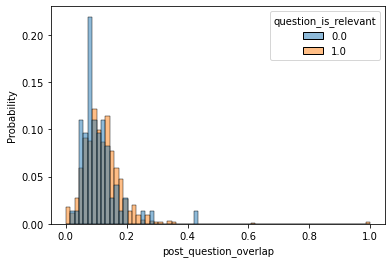

In [10]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# valid_var = 'question_is_valid'
valid_var = 'question_is_relevant'
post_question_overlap_score_data = pd.melt(clean_question_label_data.loc[:, ['post_question_overlap_score', valid_var]], id_vars=valid_var, value_name='post_question_overlap')
sns.histplot(x='post_question_overlap', data=post_question_overlap_score_data, hue=valid_var, stat='probability', common_norm=False)
plt.show()
# normalize, bin plots
# bin_count = 20
# score_bins = np.histogram(clean_question_label_data.loc[:, 'post_question_overlap_score'], bin_count)[1]
# valid_question_score_bin_counts = np.histogram(clean_question_label_data.loc[:, 'post_question_overlap_score'], bins=score_bins)[0]
# valid_question_score_bin_counts = valid_question_score_bin_counts / valid_question_score_bin_counts.sum()
# print(valid_question_score_bin_counts)
# # plt.hist(, bins=score_bins, alpha=0.5)
# # plt.show()
# # # plt.show()

OK! It looks like relevant questions do indeed have higher overlap, so let's take a high percentile of the "relevant" distribution as the cutoff.

In [11]:
score_cutoff_pct = 50
relevant_question_label_data = clean_question_label_data[clean_question_label_data.loc[:, valid_var]==1].loc[:, 'post_question_overlap_score']
question_post_overlap_score_cutoff = np.percentile(relevant_question_label_data, score_cutoff_pct)
print(f'score cutoff = {"{:1.3f}".format(question_post_overlap_score_cutoff)}')
# compute precision/recall
print(f'recall = {len(relevant_question_label_data[relevant_question_label_data >= question_post_overlap_score_cutoff])/len(relevant_question_label_data)}')
print(f'precision = {len(relevant_question_label_data[relevant_question_label_data >= question_post_overlap_score_cutoff])/len(clean_question_label_data[clean_question_label_data.loc[:, "post_question_overlap_score"] >= question_post_overlap_score_cutoff])}')

score cutoff = 0.114
recall = 0.5011160714285714
precision = 0.9432773109243697


### Test clarification questions

Next: let's identify the top question words associated with clarification questions.

In [12]:
# first words
clarification_var = 'question_is_clarification'
clean_question_label_data = clean_question_label_data.assign(**{
    'question_first_word' : clean_question_label_data.loc[:, 'question'].apply(lambda x: word_tokenizer.tokenize(x)[0].lower())
})
first_word_in_question_counts = clean_question_label_data.loc[:, 'question_first_word'].value_counts()
valid_question_first_word_counts = clean_question_label_data[clean_question_label_data.loc[:, clarification_var]==1].loc[:, 'question_first_word'].value_counts()
invalid_question_first_word_counts = clean_question_label_data[clean_question_label_data.loc[:, clarification_var]==0].loc[:, 'question_first_word'].value_counts()
# normalize counts
valid_question_first_word_counts = valid_question_first_word_counts / valid_question_first_word_counts.sum()
invalid_question_first_word_counts = invalid_question_first_word_counts / invalid_question_first_word_counts.sum()
valid_question_first_word_ratio = (valid_question_first_word_counts / invalid_question_first_word_counts).dropna()
valid_question_first_word_ratio.sort_values(inplace=True, ascending=False)
print(valid_question_first_word_ratio[valid_question_first_word_ratio > 1.])
print(valid_question_first_word_ratio[valid_question_first_word_ratio < 1.])

info     12.086093
does     10.273179
did       3.798486
what      3.122241
also      3.021523
how       3.021523
were      3.021523
are       2.643833
do        2.618653
was       2.417219
where     2.417219
is        1.544334
when      1.510762
first     1.208609
wait      1.208609
well      1.208609
sorry     1.208609
which     1.208609
with      1.208609
Name: question_first_word, dtype: float64
so         0.949622
why        0.922360
have       0.776963
could      0.755381
can        0.690634
i          0.667916
who        0.604305
your       0.604305
this       0.604305
there      0.604305
*          0.604305
just       0.604305
ok         0.604305
lol        0.604305
ask        0.604305
her        0.604305
depends    0.604305
would      0.503587
it         0.483444
the        0.362583
don        0.302152
and        0.302152
esh        0.302152
he         0.302152
if         0.302152
let        0.302152
nta        0.274684
you        0.251794
didn       0.201435
yta        0.1648

Clarification questions tend to ask questions with concrete details ex. `how`, `what`, `where`, `which`, `info` (common in AITA). Non-clarification questions mention more subjective questions ex. `why`, `could`, `who`, `maybe`, `didn`.

Let's re-run this after parsing the questions to get the root words.

In [13]:
import spacy
nlp_pipeline = spacy.load('en_core_web_sm')

In [14]:
def extract_question_word(parse, 
                          question_dep=['advmod','attr','dobj','aux','nsubj'],
                          question_word_POS=['PRON','ADV','VERB', 'AUX']):
    # get sentence containing question
    sentence = list(filter(lambda x: x[-1].text=='?', parse.sents))[0]
    root_word = sentence.root
    root_children = list(root_word.children)
    question_candidates = list(filter(lambda x: x.dep_ in question_dep and x.pos_ in question_word_POS, root_children))
    # heuristic: get the first one in the sequence
    if(len(question_candidates) > 0):
        question_word = question_candidates[0].text.lower()
    else:
#         print(f'no candidate in sentence {sentence}')
        question_word = root_word.text.lower()
    return question_word
test_sent = 'when did you tell her to do that?'
test_parse = nlp_pipeline(test_sent)
test_parse_sent = list(test_parse.sents)[0]
print(extract_question_word(test_parse))

when


In [15]:
clean_question_label_data = clean_question_label_data.assign(**{
    'question_parse' : clean_question_label_data.loc[:, 'question'].apply(lambda x: nlp_pipeline(x))
})
clean_question_label_data = clean_question_label_data.assign(**{
    'question_parse_first_word' : clean_question_label_data.loc[:, 'question_parse'].apply(lambda x: extract_question_word(x))
})

In [16]:
display(clean_question_label_data.loc[:, 'question_parse_first_word'].value_counts().head(10))

what    77
you     74
do      72
is      67
did     66
why     64
i       44
are     43
have    41
does    32
Name: question_parse_first_word, dtype: int64

In [17]:
## compute ratios
valid_question_first_word_counts = clean_question_label_data[clean_question_label_data.loc[:, clarification_var]==1].loc[:, 'question_parse_first_word'].value_counts()
invalid_question_first_word_counts = clean_question_label_data[clean_question_label_data.loc[:, clarification_var]==0].loc[:, 'question_parse_first_word'].value_counts()
valid_question_first_word_counts = valid_question_first_word_counts / valid_question_first_word_counts.sum()
invalid_question_first_word_counts = invalid_question_first_word_counts / invalid_question_first_word_counts.sum()
valid_question_first_word_ratio = (valid_question_first_word_counts / invalid_question_first_word_counts).dropna()
valid_question_first_word_ratio.sort_values(inplace=True, ascending=False)
print(valid_question_first_word_ratio[valid_question_first_word_ratio > 1.])
print(valid_question_first_word_ratio[valid_question_first_word_ratio < 1.])

does     5.841611
long     5.438742
also     3.625828
are      3.107852
where    3.021523
were     3.021523
what     2.975038
did      2.463704
do       1.955103
first    1.812914
is       1.645052
there    1.208609
then     1.208609
so       1.057533
you      1.051938
was      1.007174
will     1.007174
Name: question_parse_first_word, dtype: float64
it            0.906457
how           0.846026
why           0.828121
can           0.776963
she           0.755381
have          0.699721
when          0.604305
could         0.604305
definitely    0.604305
everyone      0.604305
let           0.604305
that          0.604305
right         0.604305
nta           0.604305
question      0.604305
i             0.551756
he            0.258988
who           0.258988
would         0.248831
they          0.201435
should        0.151076
Name: question_parse_first_word, dtype: float64


Similar as before, the valid questions have concrete question words like `what`, `does`, `where`, `was`; invalid questions have more subjective words like `why`, `how`, `could`, `should`.

Can we train a classifier just on the first words to predict valid vs. non-valid?

In [18]:
## convert data to useful format
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import CountVectorizer
word_tokenizer = WordPunctTokenizer()
question_vocab = {'does', 'did', 'what', 'how', 'were', 'are', 'was', 'is', 'where', 'when', 'why', 'could', 'can', 'who', 'would'}
cv = CountVectorizer(vocabulary=question_vocab, min_df=0., tokenizer=word_tokenizer.tokenize)
question_dtm = cv.fit_transform(clean_question_label_data.loc[:, 'question'].values)
question_labels = np.array(clean_question_label_data.loc[:, 'question_is_clarification'].values)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
model = LogisticRegression(max_iter=1000)
n_folds = 10
k_fold = StratifiedKFold(n_folds, shuffle=True)
acc_scores = []
for train_idx, test_idx in k_fold.split(question_dtm, question_labels):
    X_train, X_test = question_dtm[train_idx, :], question_dtm[test_idx, :]
    Y_train, Y_test = question_labels[train_idx], question_labels[test_idx]
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    acc = f1_score(Y_test, Y_pred)
    acc_scores.append(acc)
print(np.mean(acc_scores))

0.7674368192515575


This is surprisingly good?? Does it perform equally well across subreddits?

In [20]:
from collections import defaultdict
subreddits = clean_question_label_data.loc[:, 'subreddit'].unique()
subreddit_acc_scores = defaultdict(list)
model = LogisticRegression(max_iter=1000)
n_folds = 10
k_fold = StratifiedKFold(n_folds, shuffle=True)
for train_idx, test_idx in k_fold.split(question_dtm, question_labels):
    X_train, X_test = question_dtm[train_idx, :], question_dtm[test_idx, :]
    Y_train, Y_test = question_labels[train_idx], question_labels[test_idx]
    model.fit(X_train, Y_train)
    # compute separate scores by subreddit
    for subreddit_i in subreddits:
        subreddit_idx_i = np.where(clean_question_label_data.loc[:, 'subreddit']==subreddit_i)[0]
        subreddit_idx_i = list(set(subreddit_idx_i) & set(test_idx))
        if(len(subreddit_idx_i) > 0):
            X_test_i = question_dtm[subreddit_idx_i, :]
            Y_test_i = question_labels[subreddit_idx_i]
            Y_pred_i = model.predict(X_test_i)
            acc = f1_score(Y_test_i, Y_pred_i)
            subreddit_acc_scores[subreddit_i].append(acc)
subreddit_acc_scores = pd.Series({k : np.mean(v) for k,v in subreddit_acc_scores.items()})
print(subreddit_acc_scores)

legaladvice        0.882338
AmItheAsshole      0.675476
Advice             0.683369
personalfinance    0.801142
pcmasterrace       0.786429
dtype: float64


Surprisingly this strategy does the worst for the `AITA` community, which actually isn't terrible since we can use the `INFO` tags there to identify clarification questions.

In [21]:
## train/save model for future use
import pickle
full_model = LogisticRegression(max_iter=1000)
model.fit(question_dtm, question_labels)
model_out_file = '../../data/reddit_data/valid_question_detection_model.pkl'
pickle.dump(model, open(model_out_file, 'wb'))
## also save vocab FML
vocab_out_file_name = '../../data/reddit_data/valid_question_detection_model_vocab.txt'
cv_vocab = list(sorted(cv.vocabulary_.keys(), key=cv.vocabulary_.get))
with open(vocab_out_file_name, 'w') as vocab_out_file:
    vocab_out_file.write('\n'.join(cv_vocab))

### Bootstrap from "INFO" comments
We noticed in the `AmItheAsshole` comments that some questions are marked with `INFO`. Can we use these questions to bootstrap a classifier that automatically identifies clarification questions?

In [ ]:
## reload question data
import pandas as pd
from ast import literal_eval
import numpy as np
question_comment_data = pd.read_csv('../../data/reddit_data/advice_subreddit_question_data_for_validity_check.gz', sep='\t', compression='gzip', index_col=False)
question_comment_data.drop('Unnamed: 0', axis=1, inplace=True)
question_comment_data = question_comment_data[~question_comment_data.loc[:, 'questions'].apply(lambda x: type(x) is float and np.isnan(x))]
# convert question list
question_comment_data = question_comment_data.assign(**{
    'questions' : question_comment_data.loc[:, 'questions'].apply(literal_eval)
})
display(question_comment_data.head())
## remove quote questions
import re
quote_matcher = re.compile('&gt;[^\n]+\n')
question_comment_data = question_comment_data.assign(**{
    'questions' : question_comment_data.loc[:, 'questions'].apply(lambda x: list(filter(lambda y: quote_matcher.search(y) is None, x)))
})
question_comment_data = question_comment_data.assign(**{
    'question' : question_comment_data.loc[:, 'questions'].apply(lambda x: x[0] if len(x) > 0 else '')
})
print(f'{question_comment_data[question_comment_data.loc[:, "question"]!=""].shape[0]}/{question_comment_data.shape[0]} valid questions')

In [2]:
info_question_matcher = re.compile('^INFO')
question_comment_data = question_comment_data.assign(**{
    'info_question' : question_comment_data.loc[:, 'question'].apply(lambda x: info_question_matcher.search(x) is not None)
})
info_question_comment_data = question_comment_data[question_comment_data.loc[:, 'info_question']]
print(f'{info_question_comment_data.shape[0]}/{question_comment_data.shape[0]}')
display(info_question_comment_data.loc[:, 'question'].iloc[:10].values)

22693/873188


array(['INFO What was her reaction to that ultimatum?',
       'INFO Would you, in the same monetary position as her, be willing to buy her a computer if she needed it?',
       'INFO - did you pay for the car?',
       'INFO - (sorry, revised my judgement) - Was this something you had long planned out with your mother?',
       'INFO - are you “that guy” that falls asleep whenever they sit still for 20 minutes or did you do this to avoid dinner?',
       "INFO - Is there some reason they both can't be there?",
       "INFO what reactions did you get when you told them you're 14?",
       'INFO, how old are you guys?',
       "INFO Depends how it was brought up, but since there are two games- one the husband was already a part of and one the wife just joined, why don't they just play one game each and the other watches the baby on the others turn?",
       'INFO--did he tell you you were getting paid, or did you just assume?'],
      dtype=object)

Let's use this data as gold labels for "true" clarification questions and the non-info questions as silver labels for non-clarification questions, then try to classify using some standard models.

In [3]:
## sample non-info questions
np.random.seed(123)
non_info_question_comment_data = question_comment_data[~question_comment_data.loc[:, 'info_question']]
info_question_sample_size = info_question_comment_data.shape[0]
non_info_question_comment_data = non_info_question_comment_data.loc[np.random.choice(non_info_question_comment_data.index, info_question_sample_size, replace=False), :]

In [4]:
## combined text data
info_question_comment_text = np.hstack(
    [info_question_comment_data.loc[:, 'question'].values,
     non_info_question_comment_data.loc[:, 'question'].values]
)
# remove "INFO" as word
import re
info_matcher = re.compile('^INFO:?')
info_matcher_func = np.vectorize(lambda x: info_matcher.sub('', x))
info_question_comment_text = info_matcher_func(info_question_comment_text)
print(info_question_comment_text.shape)

(45386,)


In [5]:
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WordPunctTokenizer
en_stops = set(get_stop_words('en'))
question_words = {'who', 'what', 'when', 'where', 'why', 'how', 'is', 'are', 'do', 'did', 'would', 'could', 'should'}
punct_words = set('"?$%\'()*,-./’')
en_stops = en_stops - question_words
en_stops = en_stops | punct_words
tokenizer = WordPunctTokenizer()
max_vocab_size = 1000
cv = CountVectorizer(max_features=max_vocab_size, stop_words=en_stops, tokenizer=tokenizer.tokenize)
info_question_dtm = cv.fit_transform(info_question_comment_text)
## get vocab
info_question_word_counts = pd.Series(np.array(info_question_dtm.sum(axis=0))[0], index=list(sorted(cv.vocabulary_, key=cv.vocabulary_.get))).sort_values(inplace=False, ascending=False)
print(info_question_word_counts.head(20))

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'how', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'what', 'when', 'where', 'who', 'why', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


is       9902
what     7601
do       7285
are      7084
how      6035
did      5920
t        4927
why      4864
s        3965
would    3122
can      2963
just     2344
get      1971
when     1965
like     1909
know     1767
want     1615
who      1481
re       1448
say      1309
dtype: int64


Great! Now let's split into train/test and see how well we can identify clarification questions.

In [6]:
train_pct = 0.8
info_question_labels = np.array([0,]*len(info_question_comment_data) + [1,]*len(non_info_question_comment_data))
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from tqdm import tqdm
def train_test_model(X, Y, train_idx, test_idx, model):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    ## train model
    model.fit(X_train, Y_train)
    ## test model
    Y_pred = model.predict(X_test)
    model_score = f1_score(Y_test, Y_pred)
    return model_score
np.random.seed(123)
n_folds = 10
k_fold = StratifiedKFold(n_folds, shuffle=True)
models = [
    LogisticRegression(penalty='l2', max_iter=1000),
    # removed MLP because of high training time lol
#     MLPClassifier(hidden_layer_sizes=(50,), activation='relu', learning_rate_init=1e-3, max_iter=1000),
    SVC(C=1., degree=3, max_iter=1000),
    RandomForestClassifier(n_estimators=100),
]
for model in models:
    print(f'testing model {type(model)}')
    info_question_label_acc = []
    for train_idx, test_idx in tqdm(k_fold.split(info_question_dtm, info_question_labels)):
        score_k = train_test_model(info_question_dtm, info_question_labels, train_idx, test_idx, model)
    #     X_train, X_test = info_question_dtm[train_idx], info_question_dtm[test_idx]
    #     Y_train, Y_test = info_question_labels[train_idx], info_question_labels[test_idx]
    #     ## train model
    #     model.fit(X_train, Y_train)
    #     ## test model
    #     Y_pred = model.predict(X_test)
    #     model_score = f1_score(Y_test, Y_pred)
        info_question_label_acc.append(score_k)
    print(f'mean F1 = {np.mean(info_question_label_acc)} +/- {np.std(info_question_label_acc)}')

0it [00:00, ?it/s]

testing model <class 'sklearn.linear_model._logistic.LogisticRegression'>


10it [00:10,  1.08s/it]
0it [00:00, ?it/s]

mean F1 = 0.697964820110219 +/- 0.009397922369227825
testing model <class 'sklearn.svm._classes.SVC'>


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
1it [00:18, 18.81s/it]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
2it [00:37, 18.88s/it]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
3it [00:56, 18.87s/it]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: Converge

mean F1 = 0.46557234175788426 +/- 0.03912339250706374
testing model <class 'sklearn.ensemble._forest.RandomForestClassifier'>


10it [13:24, 80.40s/it]

mean F1 = 0.6988896779106252 +/- 0.007685303205787419


These scores are fine but not great. Let's see how they do on the hand-labeled data.

In [7]:
## load labelled data
## load all previously labeled data
question_only_comment_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_question_labels.tsv', sep='\t', index_col=False)
question_initial_comment_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_post_initial_question_labels.tsv', sep='\t', index_col=False)
parent_reply_question_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_parent_reply_question_labels.tsv', sep='\t', index_col=False)
no_filter_question_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_no_filter_question_labels.tsv', sep='\t', index_col=False)
combined_question_label_data = pd.concat([
    question_only_comment_label_data,
    question_initial_comment_label_data,
    parent_reply_question_label_data,
    no_filter_question_label_data,
], axis=0)
label_cols = ['question_is_relevant', 'question_is_clarification', 'submission_contains_answer']
combined_question_label_data.fillna({x : 0. for x in label_cols}, inplace=True)
text_cols = ['selftext', 'parent_text', 'question']
combined_question_label_data.fillna({x : '' for x in text_cols}, inplace=True)
# fix inconsistent columns
combined_question_label_data = combined_question_label_data.assign(**{
    'submission_contains_answer' : combined_question_label_data.loc[:, 'submission_contains_answer']+combined_question_label_data.loc[:, 'post_contains_answer']
})
combined_question_label_data = combined_question_label_data.assign(**{
    'selftext' : combined_question_label_data.loc[:, 'selftext'].astype(str) + combined_question_label_data.loc[:, 'parent_text'].astype(str)
})
combined_question_label_data = combined_question_label_data.assign(**{
    'question' : combined_question_label_data.apply(lambda x: x.loc['question'] if x.loc['question']!='' else x.loc['body'], axis=1)
})
## remove bot authors
bot_authors = ['LocationBot']
combined_question_label_data = pd.merge(combined_question_label_data, question_comment_data.loc[:, ['id', 'author']], on='id')
combined_question_label_data = combined_question_label_data[~combined_question_label_data.loc[:, 'author'].isin(bot_authors)]
for label_col in label_cols:
    print(combined_question_label_data.loc[:, label_col].value_counts())
## compute validity
combined_question_label_data = combined_question_label_data.assign(**{
    'question_is_valid' : ((combined_question_label_data.loc[:, 'question_is_relevant']==1) & 
                           (combined_question_label_data.loc[:, 'question_is_clarification']==1) & 
                           (combined_question_label_data.loc[:, 'submission_contains_answer']==0)).astype(int)
})

1.0    908
0.0     76
Name: question_is_relevant, dtype: int64
1.0    604
0.0    380
Name: question_is_clarification, dtype: int64
0.0    720
1.0     14
Name: submission_contains_answer, dtype: int64


In [9]:
## remove "INFO" from questions
import re
info_matcher = re.compile('^INFO:?')
combined_question_label_data = combined_question_label_data.assign(**{
    'clean_question' : combined_question_label_data.loc[:, 'question'].apply(lambda x: info_matcher.sub('', x))
})
## convert to DTM, labels
clean_question_dtm = cv.transform(combined_question_label_data.loc[:, 'clean_question'].values)
clean_question_labels = combined_question_label_data.loc[:, 'question_is_clarification'].values

In [10]:
## re-train, test
model = RandomForestClassifier(n_estimators=100)
model.fit(info_question_dtm, info_question_labels)
## predict etc.
clean_question_pred_labels = model.predict(clean_question_dtm)
clean_question_pred_score = f1_score(clean_question_labels, clean_question_pred_labels)
print(f'model score on clean labelled data = {"{:1.3f}".format(clean_question_pred_score)}')

model score on clean labelled data = 0.573


OK! This is really bad. I'm going to assume that most of the errors come from domain differences (writing style in `AmItheAsshole` is significantly different from writing in other communities).

### Label all questions in comments as valid/correct
Let's use that model that we trained on valid questions and run it on the whole data set to determine the likely distribution of questions overall.

In [1]:
## reload model etc.
import pandas as pd
import numpy as np
question_comment_data = pd.read_csv('../../data/reddit_data/subreddit_combined_comment_question_data.gz', sep='\t', index_col=False, compression='gzip')
# remove comments with no parent
question_comment_data = question_comment_data[question_comment_data.loc[:, 'parent_id'].apply(lambda x: type(x) is not float)]
# remove null questions
question_comment_data = question_comment_data[~question_comment_data.loc[:, 'questions'].apply(lambda x: type(x) is float and np.isnan(x))]
# convert questions
from ast import literal_eval
question_comment_data = question_comment_data.assign(**{
    'questions' : question_comment_data.loc[:, 'questions'].apply(literal_eval)
})

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (1,2,3,4,5,6,7,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
print(question_comment_data.shape[0])

5463573


In [3]:
## add post data
from data_helpers import load_zipped_json_data
submission_data = load_zipped_json_data('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz')
question_comment_data = question_comment_data.assign(**{'parent_id':question_comment_data.loc[:, 'parent_id'].apply(lambda x: x.split('_')[-1])})
submission_data.rename(columns={'id' : 'parent_id', 'created_utc' : 'parent_created', 'selftext' : 'parent_text', 'title' : 'parent_title', 'edited' : 'parent_edited', 'author' : 'parent_author'}, inplace=True)
question_submission_data = pd.merge(
    question_comment_data, 
    submission_data.loc[:, ['parent_id', 'parent_created', 'parent_text', 'parent_title', 'parent_edited', 'parent_author']],
    on='parent_id'
)
# remove duplicate questions
question_submission_data.drop_duplicates(['parent_id', 'body'], inplace=True)

In [4]:
## remove edits
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import remove_edit_data
from tqdm import tqdm
tqdm.pandas()
question_submission_data = question_submission_data.assign(**{
    'clean_submission_text' : question_submission_data.loc[:, 'parent_text'].progress_apply(lambda x: remove_edit_data(x))
})

100%|██████████| 5287762/5287762 [04:51<00:00, 18152.87it/s]


In [5]:
from tqdm import tqdm
import numpy as np
def flatten_columns(df, cols):
    """Flattens multiple columns in a data frame, cannot specify all columns!"""
    flattened_cols = {}
    for col in cols:
        flattened_cols[col] = pd.DataFrame([(index, value) for (index, values) in tqdm(df[col].iteritems()) for value in values],
                                           columns=['index', col]).set_index('index')
    flattened_df = df.drop(cols, axis=1)
    for col in cols:
        flattened_df = flattened_df.join(flattened_cols[col])
    # remove null vals??
    for col in cols:
        flattened_df = flattened_df[~flattened_df.loc[:, col].apply(lambda x: type(x) is float and np.isnan(x))]
    return flattened_df

In [6]:
## flatten to one question per comment
from tqdm import tqdm
flat_question_data = flatten_columns(question_submission_data, cols=['questions'])
# stupid serial approach
# flat_question_data = []
# for idx_i, data_i in tqdm(question_submission_data.iterrows()):
#     for question_j in data_i.loc['questions']:
#         data_j = data_i.copy()
#         data_j.append(pd.Series([question_j]))
#         data_j.drop('questions', inplace=True)
# #         data_j = data_i.assign(**{'question' : question_j}).drop('questions', axis=1)
#         flat_question_data.append(data_j)
# flat_question_data = pd.concat(flat_question_data, axis=1).transpose()

5287762it [00:04, 1259505.36it/s]


In [7]:
raw_flat_questions = [y for x in question_submission_data.loc[:, 'questions'].values for y in x]

In [8]:
print(len(raw_flat_questions))
print(flat_question_data.shape[0])

1541603
1541603


In [9]:
flat_question_data.rename(columns={'questions':'question'}, inplace=True)

First step: label messages as valid/invalid.

In [10]:
## label all questions as clarification/non-clarification
import pickle
valid_question_model = pickle.load(open('../../data/reddit_data/valid_question_detection_model.pkl', 'rb'))
model_vocab = list(map(lambda x: x.strip(), open('../../data/reddit_data/valid_question_detection_model_vocab.txt')))
## transform etc.
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(vocabulary=model_vocab)
flat_question_dtm = cv.fit_transform(flat_question_data.loc[:, 'question'].values)
# sanity check for feature frequency
flat_question_word_counts = pd.Series(np.array(flat_question_dtm.sum(axis=0))[0], index=list(sorted(cv.vocabulary_, key=cv.vocabulary_.get)))
print(flat_question_word_counts)
## predict valid/invalid
question_valid_probs = valid_question_model.predict_proba(flat_question_dtm)
flat_question_data = flat_question_data.assign(**{
    'valid_question_prob' : question_valid_probs[:, 1]
})

are      210897
can      121587
could     46019
did      117037
does      86301
how      156648
is       317414
was       89331
were      45052
what     259536
when      60271
where     30923
who       59533
why      162348
would    121136
dtype: int64


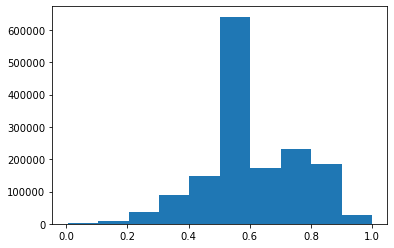

In [11]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(flat_question_data.loc[:, 'valid_question_prob'].values, bins=10)
plt.show()

Most of the questions are labelled "valid".

In [12]:
## let's also get the "INFO" questions
import re
info_question_matcher = re.compile('^INFO:? .+')
info_question_subreddits = {'AmItheAsshole'}
flat_question_data = flat_question_data.assign(**{
    'info_question' : flat_question_data.apply(lambda x: (x.loc['subreddit'] in info_question_subreddits) & (info_question_matcher.match(x.loc['question']) is not None), axis=1)
})
print(f'{flat_question_data.loc[:, "info_question"].astype(int).sum()} info questions')

34390 info questions


In [13]:
# remove quote questions
import re
quote_matcher = re.compile('^.+&gt;')
flat_question_data = flat_question_data[flat_question_data.loc[:, 'question'].apply(lambda x: quote_matcher.search(x) is None)]

In [15]:
## compute overlap between post and questions
from data_helpers import tokenize_stem_text
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
from nltk.stem import PorterStemmer
from tqdm import tqdm
tqdm.pandas()
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = PunktSentenceTokenizer()
stemmer = PorterStemmer()
flat_question_data = flat_question_data.assign(**{
    'submission_sents' : flat_question_data.loc[:, 'clean_submission_text'].progress_apply(lambda x: tokenize_stem_text(x, stemmer, word_tokenizer, sent_tokenizer)),
    'question_sents' : flat_question_data.loc[:, 'question'].progress_apply(lambda x: tokenize_stem_text(x, stemmer, word_tokenizer, sent_tokenizer))
})
# remove posts without sentences??
flat_question_data = flat_question_data[flat_question_data.loc[:, 'submission_sents'].apply(lambda x: len(x) > 0)]
from data_helpers import compute_sent_word_overlap
flat_question_data = flat_question_data.assign(**{
    'post_question_overlap' : flat_question_data.progress_apply(lambda x: compute_sent_word_overlap(x.loc['submission_sents'], x.loc['question_sents']), axis=1)
})
flat_question_data = flat_question_data.assign(**{
    'post_question_overlap_score' : flat_question_data.loc[:, 'post_question_overlap'].apply(lambda x: x[0]),
    'post_question_overlap_sent' : flat_question_data.loc[:, 'post_question_overlap'].apply(lambda x: x[1][0]),
})

100%|██████████| 1540239/1540239 [06:36<00:00, 3882.82it/s]


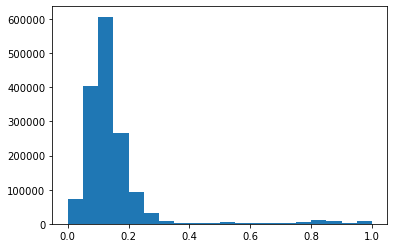

In [18]:
## plot overall distribution over overlap scores
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(flat_question_data.loc[:, 'post_question_overlap_score'], bins=20)
plt.show()

Let's look at questions at different overlap quantiles to determine what a good cutoff point would be .

In [19]:
pd.set_option('display.max_colwidth', 150)
import numpy as np
bins = np.linspace(0., 1.0, 11)
print(bins)
flat_question_data.sort_values('post_question_overlap_score', inplace=True, ascending=True)
for bin_i in bins:
    print(f'testing bin = {"{:1.3f}".format(bin_i)}')
    data_i = flat_question_data[flat_question_data.loc[:, 'post_question_overlap_score']>=bin_i]
    display(data_i.loc[:, ['post_question_overlap_score', 'question', 'post_question_overlap_sent', 'parent_title']].head(10))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
testing bin = 0.000


,post_question_overlap_score,question,post_question_overlap_sent,parent_title
413318,0.0,Do you have any monetary damages?,"[I, wa, punch, by, a, store, employe, without, me, incit, violenc, or, encourag, a, physic, alterc, .]","I was attacked by a store employee leaving me permanently disfigured 2 years ago, is it too late to seek damages?"
80393,0.0,Maybe you should take your business elsewhere?,"[So, here, ', s, the, situat, :, I, ', ve, just, recent, start, work, out, (, 2, month, ).]",AITA for telling a lady she can't bring her kid to gym?
5050860,0.0,Have you noticed favoritism elsewhere in your life?,"[So, basic, i, graduat, high, school, on, wednesday, and, tonit, i, had, some, famili, over, for, a, littl, grad, parti, .]",AITA for feeling like i didn’t get enough for my graduation gift
162718,0.0,Does your HOA have one?,"[sorri, I, ', m, on, mobil, .]","CAN, HOA, The acounts are in the black and the budget is not adding up. We're increasing our rent to supplement an incorrect budget."
1368284,0.0,Do you guys share finances?,"[I, had, to, work, on, mother, day, and, didnt, get, off, until, 7pm, .]",AITA for call my wife selfish on mothers day?
1368268,0.0,YTA- WTH dude?,"[I, had, to, work, on, mother, day, and, didnt, get, off, until, 7pm, .]",AITA for call my wife selfish on mothers day?
3411889,0.0,What did they think would happen?,"[I, (, 19, F, ), wa, a, martial, art, assist, instructor, at, anoth, academi, when, I, wa, younger, (, I, ', m, been, at, a, new, one, sinc, I, st...",WIBTA if I get a restraining/no contact order against a 14 year old kid?
5051006,0.0,Who pays mortgage/rent?,"[thi, person, will, alway, mix, dirti, dish, in, with, our, and, I, wouldn, ', t, mind, if, she, wash, up, more, than, onc, in, a, blue, moon, but...",AITA For separating and washing up mine and my partners dirty dishes from her mums to leave for her mum to her own? (Reasoning below)
2270432,0.0,"Also, high school?","[[, TX, ], due, to, recent, event, where, I, wa, accus, if, make, threat, in, class, I, decid, to, record, myself, to, protect, against, more, fal...",Can i legally record myself in class
3196229,0.0,Are you CPA eligible?,"[account, make, $, 48, ,, 000, at, a, mid, -, size, corpor, .]",[Staff accountant] Bonus received -- does this replace a raise?


testing bin = 0.100


,post_question_overlap_score,question,post_question_overlap_sent,parent_title
4286192,0.1,Is there a solid impression she does that makes you crack up every single time?,"[I, know, for, a, fact, that, she, will, ask, me, thi, question, again, ,, and, the, next, time, it, happen, I, still, don, ’, t, know, what, to, ...","WIBTA if my friend (16F) asked me (16F) whether I think she’s ugly, and I were to be honest and tell her yes?"
1362993,0.1,Likelihood of this being just a bluff?,"[I, ’, m, contact, a, lawyer, about, what, I, can, do, sinc, I, don, ’, t, know, all, of, my, right, about, thi, ,, though, I, ’, m, sure, I, have...",Threatened to getting sued over Google review (CA)
845224,0.1,Water is 90 a month?,"[credit, score, is, 534, I, think, and, I, have, absolut, no, save, for, a, raini, day, .]","31 year old with nothing to fall on, debt and irresponsible."
3207036,0.1,INFO: is your boss legally allowed to fire you over something like this?,"[My, wife, is, realli, mad, and, say, thi, is, a, ridicul, request, for, my, boss, to, make, and, that, I, need, to, put, our, famili, first, and,...",WIBTA for canceling a family vacation at my boss's request?
845244,0.1,Instead of being miserable for 3 months why not start the job search now?,"[If, someth, doesn, ', t, chang, in, the, next, 3, month, ,, I, ', m, go, to, quit, .]",Quitting your job with no new job.
1506844,0.1,NTA sounds like some of your friends are kind of homophobic tbh?,"[both, of, us, and, anoth, friend, start, laugh, like, crazi, ,, but, the, other, 3, peopl, just, look, at, us, like, whaatttt, ??????]",AITA for telling my friends that I'd had sex in the place where we were camping?
3207084,0.1,How easily can you find a new job?,"[witba, ?]",WIBTA for canceling a family vacation at my boss's request?
845183,0.1,But have you considered what maneuvering you can do to work around the broken AC issue?,"[should, we, replac, the, AC, unit, in, the, crv, or, buy, a, new, (, use, ), car, ?]",Replace AC or get a new (used) car?
3207084,0.1,How much do you like your current job?,"[witba, ?]",WIBTA for canceling a family vacation at my boss's request?
3207042,0.1,Can your wife go without you at least?,"[witba, ?]",WIBTA for canceling a family vacation at my boss's request?


testing bin = 0.200


,post_question_overlap_score,question,post_question_overlap_sent,parent_title
484642,0.2,Is it against OSHA standards?,"[not, tri, to, die, ..., Is, thi, a, massiv, osha, violat, ?]","Boss just assumed I knew he meant to use hydrochloric acid on a bathroom sink. He also doesnt have any of the proper msds, or proper ppe for handl..."
1961609,0.2,Why not just plug both monitors in the GPU?,"[I, have, a, ryzen, 3, 2200g, cpu, ,, and, 2, monitor, (, one, plug, in, the, MB, ,, and, the, other, one, in, the, gpu, ).]",CPU virtualization does not work
2651109,0.2,"But... now that I think of it, if your boyfriend paid are you sure he didn't tip 5%?","[but, that, didn, ', t, happen, .]","WIBTA for reporting a guy to his employer for an asshole comment to me personally, against my boyfriend's wishes?"
329592,0.2,"Do you know that for certainly, or is it that she just really doesn't have time?","[just, a, head, up, for, next, time, ,, we, realli, need, to, know, if, go, to, a, parti, is, go, to, cost, more, than, $, 100, .]",AITA for telling my friend I didn’t appreciate paying for a $200 meal at her husband’s birthday party?
4682932,0.2,Can you easily afford it?,"[what, do, you, guy, think, ?]","Should we accept a ""free"" timeshare?"
1592336,0.2,Your response to Alex's rude comment about turning your TV up was extremely childish and was rude to your husband as well why would you take the s...,"[alex, respond, with, “, well, turn, up, your, TV, then, .”, I, had, a, moment, where, I, wa, too, shock, to, speak, .]",AITA for telling my husband his friend is no longer welcome at our house?
3685838,0.2,Are you worried about investing in this book and becoming attached to your unborn child?,"[Am, I, the, asshol, for, not, want, or, care, about, thi, pregnanc, book, ,, and, not, want, to, fill, it, out, ?]",AITA for not wanting to fill out my wife’s pregnancy/baby book?
4021139,0.2,"Why do you blame your brother for your dishwasher not working, etc.?","[Is, thi, elder, abus, ?]","My brother is hemorrhaging money, and it's hurting my family, and future."
2456238,0.2,Maybe Tinder and similar apps should expand their gender definitions and what they’re looking for?,"[It, ’, s, not, like, anyon, with, the, tinder, paramet, “, male, look, for, femal, ”, is, suddenli, go, to, see, a, transgend, woman, and, decid,...",AITA for blocking and reporting transgenders on Tinder?
5227257,0.2,Is that a Roth IRA or Roth 401k?,"[Is, there, a, reason, to, put, some, in, spi, ?]",ROTH Allocation Advice - 32/M


testing bin = 0.300


,post_question_overlap_score,question,post_question_overlap_sent,parent_title
462991,0.301587,"Remember how you told us that you joke about Person B not having a dad even though he has a healthy, functional family (BTW, you *are* the asshole...","[So, we, all, have, these, insid, joke, with, each, other, -, we, joke, about, person, B, for, not, have, a, dad, becaus, he, ', s, black, ,, but,...",AITA for not taking a joke?
5262629,0.301587,"INFO - All Of the disagreement on here revolves around the hotel room situation, so I ask you: If she had said yes to going to the concert as a da...","[**, edit, **:, becaus, a, lot, of, the, hang, up, is, over, the, hotel, room, thing, :, ye, I, would, have, been, fine, if, the, first, girl, agr...","AITA for giving my concert ticket to another girl after my friend said she only wanted to go with me as ""friends""?"
349072,0.301887,"Why were the two girls so upset and also, if you weren't their ride and took and uber home then, does it really matter if you ""left"" them at a res...","[I, left, them, in, a, safe, area, and, I, didn, ', t, ride, or, bring, either, of, them, with, me, so, they, were, go, to, be, call, their, own, ...",AITA for leaving two girls at a restaurant?
5126952,0.301887,You don’t want a “friends” mum to enjoy the meal and speeches because no one knows her?,"[the, hotel, in, realiti, doesn, ’, t, need, the, number, up, till, 48, hour, befor, ,, but, the, tabl, plan, are, set, ,, there, ’, s, no, easi, ...",AITA for excluding my blind friend from my wedding?
3872527,0.301887,"Your friend is definitely being an asshole here, he's choosing to break up with his girlfriend, he's choosing to still go on the trip, he choosing...","[So, am, I, an, asshol, for, still, want, to, push, for, my, plan, for, the, sleep, arrang, and, for, want, to, spend, my, first, vacat, sleep, wi...",AITA for wanting to share the hotel room I booked with my girlfriend rather than sleeping with my friend who will go through a break up before our...
2795082,0.301887,"Given the 1 month resignation notice from me, could you match that from your side?","[(, note, :, there, wa, a, claus, in, the, contract, that, wa, talk, about, equip, so, I, ask, ...), &, gt, ;, &, gt, ;, can, I, bundl, sick, day,...","Job offer withdrawn after negotiating, pls help me understand what I did wrong?"
1557351,0.301887,"YTA - It's so easy to just bite the bullet and extend kindness to other people, I get that you don't like other people using your bathroom, but wo...","[It, ', s, not, that, clean, becaus, load, of, peopl, use, it, through, the, day, but, I, think, you, cant, be, that, picki, if, you, ', re, so, u...",AITA for not allowing my roommate's girlfriend to use my bathroom causing her to piss herself
3248026,0.301887,&gt; she said she’d fix it verbally but nothing has been done or paid for?,"[So, my, roommat, dog, ha, piss, and, poop, in, the, apart, ,, chew, on, furnitur, ,, broke, my, printer, ,, ps4, (, bought, a, new, one, becaus, ...",Roommates dog damaged apt and my items what can I do?
2506344,0.302326,"You asked her for advice to buy a trench coat, then she got you a trench coat, and somehow you're disappointed because it's not expensive enough?","[On, a, side, note, ,, just, two, week, ago, I, want, to, buy, a, trench, coat, ,, and, I, ask, her, for, advic, ,, but, I, ultim, didn, ', t, go,...",AITA for being angry and disappointed about my girlfriend's gift for our anniversary?
2691064,0.302326,"d) If you've had that secured card from your current credit union for 3 or 4 years now, why is it still a secured card?","[I, have, a, check, /, save, account, with, them, ,, and, I, ', ve, had, a, secur, credit, card, with, them, for, about, 3, -, 4, year, now, to, s...",Moving to a new state/Credit Union. My (22 y/o w/ 3-4 years credit history) secured credit card is with my old one. Is cancelling it and getting a...


testing bin = 0.400


,post_question_overlap_score,question,post_question_overlap_sent,parent_title
2622436,0.4,What kind of down payment?,"[what, kind, of, hous, could, they, afford, ?]",How much house can a married couple afford?
2387382,0.4,Can you practice art when you don't like doing it?,"[I, don, ', t, like, practic, art, anymor, .]",A light inside me suddenly turned off
2082159,0.4,"&gt;So, what can I do legally?","[I, think, he, should, report, her, immedi, ,, but, I, digress, ...., So, ,, what, can, I, do, legal, ?]",Been threatened with a false rape accusation. What can I do to protect myself?
3086530,0.4,Are you ok with staying with someone who doesn’t care about their health at all?,"[He, doesn, ’, t, care, at, all, about, hi, health, .]",AITA for being mad at my husband for throwing up?
1941032,0.4,She doesn't work??,"[and, she, doesn, ’, t, work, either, .]",AITA for telling my older brother I am going to cut ties with him after finding out his son isn’t his?
3078546,0.4,&gt; Also is it a bad idea to have multiple bank accounts?,"[I, like, what, I, have, go, for, the, ira, enough, to, where, I, want, to, use, it, for, mid, length, invest, as, well, (&, gt, ;, 5, year, ), al...",Multiple questions 🧐
5136342,0.4,Lol wear a wig?,"[aita, for, not, want, to, wear, a, wig, ?]",AITA for refusing to wear a wig to my friend’s wedding?
2121025,0.4,Should you ask for a raise?,"[My, question, ,, should, I, use, thi, opportun, to, ask, for, a, rais, ?]","My employer is suffering from a lack of personnel, can I use this to my advantage and ask for a raise?"
2392607,0.4,&gt; Thoughts?,"[thought, ?]",Do you think there's such thing as too big an emergency fund?
2546888,0.4,"So, what to do ?","[If, not, ,, what, should, I, do, ?]","Am I really a ""volunteer""?"


testing bin = 0.500


,post_question_overlap_score,question,post_question_overlap_sent,parent_title
1172036,0.5,"I've lived in more different situations than I can count on both hands, and never once has anyone been mad at me (or vice versa) for having people...","[aita, ?]",AITA for having friends over?
4823832,0.5,Does she expect that from you??,"[aita, ?]",AITA for letting my girlfriend struggle financially?
4481223,0.5,Who the hell rips on their friend for being broke??,"[thought, ?]",AITA for breaking off contact with my long time friends for mocking me?
3529259,0.5,Why would he think they have people samples at a PET STORE!?,"[aita, ?]",AITA because my son accidentally ate a dog treat?
744331,0.5,"YTA I mean Jesus you get a chance to teach your son and others to learn about inclusivity, neurodivergence, empathy and you blow it ??","[aita, ?]",AITA for inviting my sons entire class except for one child because of his autism?
2492643,0.5,"Like jeez when did she start, week 2??","[aita, ?]",AITA for not wanting to meet my girlfriend's family and go out to dinner with them?
744447,0.5,He was “put in the class to socialize” what the fuck are you thinking??,"[aita, ?]",AITA for inviting my sons entire class except for one child because of his autism?
5190894,0.5,NTA how could your wife be okay with this???,"[aita, ?]",AITA for telling my wife that I would leave her if she took our son to her (IMO) racists Uncle's house for the Holidays?
46793,0.5,Your nephew was abandoned by his shitty mother and you beat him over fucking pokeman cards??,"[aita, ?]",AITA for smacking the shit out of my 8-year-old nephew for stealing hundreds of dollars of my Pokemon cards and taking some of them to school and ...
2883270,0.5,What kind of relationship is that??,"[aita, ?]",AITA for leaving my wife by herself when she talks in a cringy manner


testing bin = 0.600


,post_question_overlap_score,question,post_question_overlap_sent,parent_title
2357603,0.603175,"&gt; Its the last weekend of the month, you've spent 190 of your food budget but only 50 of your clothing budget and don't expect to buy anymore ...","[(, the, number, are, irrelev, ,, just, made, it, easi, for, discuss, ', s, sake, ), incom, :, 1000, save, :, 150, food, :, 200, cloth, :, 100, no...","Budgeting Pros: Do you allow yourself to ""Rob Peter to pay Paul"" in your budget categories?"
2391465,0.604651,"&gt; is there any way for them to contact the email provider and get a log of activity on the account, and determine if the password was changed?","[So, I, ', m, just, wonder, ,, becaus, we, ', re, both, realli, frustrat, by, thi, ,, is, there, ani, way, for, them, to, contact, the, email, pro...",[PA] Is it possible for law enforcement to subpoena information from an email service provider?
2635187,0.604651,&gt; Is there any way to update the XBox One S controller's firmware without access to either an XBox One console or a PC with Windows 10?,"[I, don, ', t, have, access, to, either, ,, so, that, ', s, my, next, set, of, question, :, -, Is, there, ani, way, to, updat, the, xbox, one, S, ...","I really need some reliable, accurate information regarding the XBox One S/Bluetooth controller and Windows 7"
4484444,0.604651,&gt;how does it look when other companies I've only been in my first job for a little over half a year and already looking for another job?,"[I, want, to, begin, look, for, other, job, ,, and, have, gone, through, the, process, of, updat, my, CV, and, such, ,, but, how, doe, it, look, w...",How important is staying at your first job after college?
2761294,0.604651,&gt; is there anything I can do to claim his property before he runs out of funds and his mobile home gets repossessed with everything in it?,"[My, question, is, thi, ,, can, I, find, out, if, he, ha, regist, me, as, have, power, of, attorney, or, is, there, anyth, I, can, do, to, claim, ...",Uncle is a wanted fugitive and I am his only next of kin - what can I legally do?
2380138,0.605263,"What do you mean ""It was always the plan that, once it was paid off, she would give them back the deposit and transfer the deed to her name"" ?","[It, wa, alway, the, plan, that, ,, onc, it, wa, paid, off, ,, she, would, give, them, back, the, deposit, and, transfer, the, deed, to, her, name...",House being sold while we pay the mortgage. (NH)
2320398,0.605263,&gt; I'm trying to work out why that doesn't mean I will have recouped the fees/taxes within 6 months?,"[(, hous, i, ', m, interest, in, max, out, about, £, 175, ,, 000, ), I, ', m, tri, to, work, out, whi, that, doesn, ', t, mean, I, will, have, rec...",Recouping house buying costs (UK)
4585611,0.605263,"&gt;Note-I’m using my DVI cable to connect my monitor to my GPU, would that be a reason for low frames?","[spec, ryzen, 7, 2700x, gtx, 1070, 16, GB, ram, asu, crosshair, VI, note, -, I, ’, m, use, my, dvi, cabl, to, connect, my, monitor, to, my, gpu, ,...",Low frame rates
2525220,0.606061,&gt;how do they calculate the long vs short term capital gains tax since I invested a new amount recently?,"[If, I, want, to, sell, and, withdraw, cash, right, now, ,, how, do, they, calcul, the, long, vs, short, term, capit, gain, tax, sinc, I, invest, ...",Capital gains confusion
893431,0.606061,&gt; I thought they could look up the specific transaction and see how much money was pulled from the cash register?,"[wa, their, anyth, more, walmart, could, have, done, to, help, me, ,, I, thought, they, could, look, up, the, specif, transact, and, see, how, muc...","Cashed check at Walmart, missing $100?"


testing bin = 0.700


,post_question_overlap_score,question,post_question_overlap_sent,parent_title
3962205,0.702128,"&gt; I use a Stocks and Shares ISA, I make about 4% profit per annum, does this account to my ISA allowance, meaning I can contribute less as I'll...","[*, what, is, the, tax, rate, on, save, beyond, £, 20, ,, 000, *, I, use, a, stock, and, share, isa, ,, I, make, about, 4, %, profit, per, annum, ...",How are savings taxed in the UK?
3619594,0.702703,"&gt; but should I pay out of pocket for food and receive a larger payment at the end, or am I only hurting myself that way?","[I, ', d, certainli, put, the, hotel, on, the, corpor, card, ,, but, should, I, pay, out, of, pocket, for, food, and, receiv, a, larger, payment, ...",Help me maximize an unusual per diem structure
4366967,0.702703,&gt; can I be listed as a Plantiff even if I live in another state (and will not be available for two months due to military training)?,"[If, we, do, take, her, to, small, claim, ,, can, I, be, list, as, a, plantiff, even, if, I, live, in, anoth, state, (, and, will, not, be, avail,...","Landlords delays security deposit for 2 months, takes out a huge chunk (Alaska)"
892103,0.702703,"&gt; is there a defined amount of time before I pay off my bill in full, and when I will be able to use my card again?","[To, make, thi, easier, for, me, ,, and, my, schedul, of, payment, ,, is, there, a, defin, amount, of, time, befor, I, pay, off, my, bill, in, ful...",CapitalOne Platinum time between paying bill and funds being available?
5071402,0.702703,"&gt;I can just contribute the difference to the traditional IRA up to $6000 and convert it all in one go without owing more taxes, right?","[when, it, ', s, time, for, next, year, ', s, backdoor, contribut, ,, I, can, just, contribut, the, differ, to, the, tradit, ira, up, to, $, 6000,...",How will trad IRA interest affect taxes?
3115635,0.703704,&gt; do you think there’s any chance they’ll extradite him back to Texas over $5k?,"[My, main, question, is, -, do, you, think, there, ’, s, ani, chanc, they, ’, ll, extradit, him, back, to, texa, over, $, 5k, ?]",Extradition over child support?
1206129,0.703704,&gt; can I really get in trouble for sending someone $500 for weed and it wasn’t delivered?,"[mayb, he, isn, ’, t, lie, but, can, I, realli, get, in, troubl, for, send, someon, $, 500, for, weed, and, it, wasn, ’, t, deliv, ?]",Scammed off leafedin.org and being blackmailed
1644657,0.703704,&gt;What is a good way to decide on a good GPU when looking for something better than mid-tier?,"[So, my, question, here, is, ,, what, is, a, good, way, to, decid, on, a, good, gpu, when, look, for, someth, better, than, mid, -, tier, ?]",What's better? AMD or Intel??
1634952,0.703704,&gt;should I go to someone about it and if so how do I tell my mom without worrying her?,"[To, sum, it, up, my, question, is, should, I, go, to, someon, about, it, and, if, so, how, do, I, tell, my, mom, without, worri, her, ?]",Should I get a mental health diagnosis?
2648313,0.703704,"&gt; if I make biweekly payments, but strictly only pay 24 biweekly payments, is that any better than paying 12 full payments?","[the, essenc, of, my, question, is, ,, if, I, make, biweekli, payment, ,, but, strictli, onli, pay, 24, biweekli, payment, ,, is, that, ani, bette...",Mortgage interest: How is it calculated and how does it accumulate? What's the best way to pay?


testing bin = 0.800


,post_question_overlap_score,question,post_question_overlap_sent,parent_title
2727761,0.8,&gt; Can she actually get away with this or is she just overconfident?,"[can, she, actual, get, away, with, thi, or, is, she, just, overconfid, ?]",Girlfriend feels entitled to all assets
792350,0.8,&gt;Is there some justice that can be had for this negligence?,"[Is, there, some, justic, that, can, be, had, for, thi, neglig, ?]",AED not used at the gym during sudden cardiac arrest?
565380,0.8,&gt;Should i get rid of the xbox forever or keep it?,"[should, i, get, rid, of, the, xbox, forev, or, keep, it, ?]",Getting rid of xbox one switching to full on pc!
2727810,0.8,&gt;What are they going to do with my statement of facts?,"[what, are, they, go, to, do, with, my, statement, of, fact, ?]",What happened to my statement from my trial by declaration?
4053756,0.8,&gt; Any ideas on what this screenshot could be from?,"[&, amp, ;, nbsp, ;, ani, idea, on, what, thi, screenshot, could, be, from, ?]","(Michigan, Oakland County) Today, my previous landlord returned my security deposit check, withholding fees citing ""long grass"". It has been 34 da..."
5025146,0.8,&gt;Do we have any recourse to compel the landlord to take action?,"[Do, we, have, ani, recours, to, compel, the, landlord, to, take, action, ?]","Someone is popping mailboxes open in my apartment building and stealing mail, landlord not doing much about it"
4469796,0.8,&gt;My question is because I punched first am I automatically at fault?,"[My, question, is, becaus, I, punch, first, am, I, automat, at, fault, ?]",(MN) Fist fight with neighbor
3747265,0.8,&gt; What consequences could there be if she accepts regarding her greencard?,"[what, consequ, could, there, be, if, she, accept, regard, her, greencard, ?]","Divorce in Texas, legal ramifications"
2213332,0.8,&gt; I’m not sure if the points are worth the fee?,"[I, ’, m, not, sure, if, the, point, are, worth, the, fee, ?]",Paying rent with credit card?
1624000,0.8,&gt; What other hidden costs of a condo should I be aware of?,"[what, other, hidden, cost, of, a, condo, should, I, be, awar, of, ?]","Just bought a condo, a month later receiving a large ""special assessment"""


testing bin = 0.900


,post_question_overlap_score,question,post_question_overlap_sent,parent_title
1962473,0.9,"&gt; Can anybody speak to how stupid / smart / etc it would be to use a ""borderless account"" with TransferWise to hold such a relatively large amo...","[can, anybodi, speak, to, how, stupid, /, smart, /, etc, it, would, be, to, use, a, "", borderless, account, "", with, transferwis, to, hold, such, ...",Wife is attending university for masters in the UK. Roughly GBP 18k for tuition. We're risk averse and want to protect against unknown exchange ra...
4469540,0.9,&gt; I was wondering if I would have to make him the head of household when doing my taxes or would i make myself the head of household for the ro...,"[I, wa, wonder, if, I, would, have, to, make, him, the, head, of, household, when, do, my, tax, or, would, i, make, myself, the, head, of, househo...",19 year old doing taxes for the first time seeking help
788281,0.9,"&gt;If the house is sold, am I required to evenly split the proceeds with her since she hasn't contributed to the mortgage payments since before t...","[If, the, hous, is, sold, ,, am, I, requir, to, evenli, split, the, proce, with, her, sinc, she, hasn, ', t, contribut, to, the, mortgag, payment,...",Can I lock my ex-wife out of the house if I'm worried she'll try to take my dog?
781919,0.9,"&gt;Would it be better for me to just aggressively pay down my loans for the next 6 months, then start saving for retirement when my 401k kicks in?","[would, it, be, better, for, me, to, just, aggress, pay, down, my, loan, for, the, next, 6, month, ,, then, start, save, for, retir, when, my, 401...",My job's 401(k) plan isn't available to me for another 6 months. Is there something I can do in the meantime?
4596390,0.9,&gt;But what is the difference of having a 'gaming tournament' as an in-person event where there is an entry fee and players can win money?,"[but, what, is, the, differ, of, have, a, ', game, tournament, ', as, an, in, -, person, event, where, there, is, an, entri, fee, and, player, can...",Mobile Game with Reward [US]
4413331,0.9,&gt; What's to stop someone who I've written a check to from grabbing those details off of my check and paying their own bills from my bank account?,"[what, ', s, to, stop, someon, who, I, ', ve, written, a, check, to, from, grab, those, detail, off, of, my, check, and, pay, their, own, bill, fr...",Just set up automatic payments for my gas bill - they only needed my bank account number and routing number. Both of these are easily available to...
2946782,0.9,&gt; So my question is...do his papers still count if they don’t have the ‘filed’ stamp on them and they are missing documents?,"[So, my, question, is, ..., do, hi, paper, still, count, if, they, don, ’, t, have, the, ‘, file, ’, stamp, on, them, and, they, are, miss, docume...",Served court papers with no stamp? Vancouver BC
1402477,0.9,"&gt; Anyway, it doesn't sit right with me to be ""friends"" with someone who devalues me and considers me a red flag in almost a threatening tone?","[anyway, ,, it, doesn, ', t, sit, right, with, me, to, be, "", friend, "", with, someon, who, devalu, me, and, consid, me, a, red, flag, in, almost,...",WIBTA (25F) For unfriending and blocking my ex-best friend (25F) on Instagram after she hasn't talked to me for a month?
4734894,0.9,&gt;If I don’t show is there anyway he can win the case by convincing the judge that I should be there even though service hasn’t been verified?,"[If, I, don, ’, t, show, is, there, anyway, he, can, win, the, case, by, convinc, the, judg, that, I, should, be, there, even, though, servic, has...","Ca small claims court, service not verified, do I need to show up?"
4413697,0.9,"&gt; let's say I've gotten a pic from someone younger that I didn't ask for and since I'm an adult, could I be trouble?","[and, let, ', s, say, I, ', ve, gotten, a, pic, from, someon, younger, that, I, didn, ', t, ask, for, and, sinc, I, ', m, an, adult, ,, could, I, ...",Can schools check everyone'

testing bin = 1.000


,post_question_overlap_score,question,post_question_overlap_sent,parent_title
2460741,1.0,Do I have any legal responsibility to my father in this case?,"[Do, I, have, ani, legal, respons, to, my, father, in, thi, case, ?]",[TX] My father(56M) suffers from severe to end-stage alcohol abuse and is refusing treatment. Where do I go from here?
3509386,1.0,What could be causing this?,"[what, could, be, caus, thi, ?]",Why is my credit score creeping down?
2460741,1.0,I'm considering whether I should stay in state to finish school or if I should move in with family in another state - are there issues with separa...,"[I, ', m, consid, whether, I, should, stay, in, state, to, finish, school, or, if, I, should, move, in, with, famili, in, anoth, state, -, are, th...",[TX] My father(56M) suffers from severe to end-stage alcohol abuse and is refusing treatment. Where do I go from here?
2460778,1.0,How can I fix this now before they come after me?,"[how, can, I, fix, thi, now, befor, they, come, after, me, ?]",I owe the IRS
3509215,1.0,Will I get paid for the two days I was there or even reimbursed for the plane ticket?,"[will, I, get, paid, for, the, two, day, I, wa, there, or, even, reimburs, for, the, plane, ticket, ?]","I left a full paid business trip after my boss tried to buy me a prostitute, what can happen to me and will I still get paid?"
4421337,1.0,"However should I still open a traditional IRA and contribute the max $5,500?","[howev, should, I, still, open, a, tradit, ira, and, contribut, the, max, $, 5, ,, 500, ?]",Trying to decide if I should open a traditional IRA...
2375084,1.0,In what ways would supporting my mother financially benefit me?,"[In, what, way, would, support, my, mother, financi, benefit, me, ?]",Sister wants me to help pay for our mother's house; What benefits am I able to obtain if I contribute?
4499763,1.0,"Obviously if I were to take a mortgage it would be better to not involve her in the loan, but is that possible if we are married?","[obvious, if, I, were, to, take, a, mortgag, it, would, be, better, to, not, involv, her, in, the, loan, ,, but, is, that, possibl, if, we, are, m...",Questions about my GF's defaulted student loan debt
5143644,1.0,"I am in for the long run here, any tips or advice?","[I, am, in, for, the, long, run, here, ,, ani, tip, or, advic, ?]",I need some external advice on managing a retirement fund.
3952567,1.0,Or do we need actual cash readily available (in notes)?,"[Or, do, we, need, actual, cash, readili, avail, (, in, note, )?]",What is a recession and how do we prepare for it?


It looks like most of the questions with at least 10% overlap are relevant, and questions with >50% overlap tend to repeat the original post and/or are rhetorical.

Let's filter the data based on (1) clarification (using model prediction score) and (2) relevance (overlap).

In [20]:
valid_question_overlap_score_range = [0.1, 0.5]
relevance_cutoff = 0.5
valid_question_data = flat_question_data[
    ((flat_question_data.loc[:, 'valid_question_prob'] > relevance_cutoff) | flat_question_data.loc[:, 'info_question']) &
    (flat_question_data.loc[:, 'post_question_overlap_score'].apply(lambda x: x >= valid_question_overlap_score_range[0] and x < valid_question_overlap_score_range[1]))
]
print(f'{valid_question_data.shape[0]}/{flat_question_data.shape[0]} valid questions')
# remove extra columns to save space
valid_question_data.drop(['clean_submission_text', 'parent_author', 'parent_created', 'parent_edited', 'parent_text', 'parent_title', 'question_sents', 'submission_sents'], axis=1, inplace=True)

818557/1540239 valid questions


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


OK! Using the automatic threshold we get ~50% coverage of the questions.

Let's save this data for later.

In [21]:
valid_question_out_file = '../../data/reddit_data/subreddit_combined_valid_question_data.gz'
valid_question_data.to_csv(valid_question_out_file, sep='\t', compression='gzip', index=False)

### Second round of question labels
We did a small pilot sample of annotations for some of the questions, so let's see how the annotators did.

In [28]:
import pandas as pd
import re
import os
annotation_data_dir = '../../data/reddit_data/annotation_samples/mini_annotation_sample/'
file_matcher = re.compile('annotation_sample_\d')
annotation_sample_files = list(filter(lambda x: file_matcher.match(x) is not None, os.listdir(annotation_data_dir)))
annotation_sample_data = list(map(lambda x: pd.read_csv(os.path.join(annotation_data_dir, x), sep='\t', index_col=False), annotation_sample_files))
label_cols = ['question_is_relevant', 'question_asks_for_more_info']
for i, data_i in enumerate(annotation_sample_data):
    data_i.rename(columns={label_col : f'{label_col}_{i+1}' for label_col in label_cols}, inplace=True)
# join data
annotation_data =  annotation_sample_data[0].copy()
for i, data_i in enumerate(annotation_sample_data[1:]):
    label_cols_i = list(map(lambda x: f'{x}_{i+2}', label_cols))
    annotation_data = pd.merge(
        annotation_data, data_i.loc[:, ['parent_id', 'question'] + label_cols_i]
    )
# fill null vals
annotation_data.fillna(value=-1, inplace=True)
print(annotation_data.columns)

Index(['post_title', 'post_text', 'question', 'parent_id',
       'question_is_relevant_1', 'question_asks_for_more_info_1',
       'question_is_relevant_2', 'question_asks_for_more_info_2',
       'question_is_relevant_3', 'question_asks_for_more_info_3',
       'question_is_relevant_4', 'question_asks_for_more_info_4'],
      dtype='object')


In [29]:
## overall label distribution
relevant_cols = list(filter(lambda x: 'question_is_relevant' in x, annotation_data.columns))
info_cols = list(filter(lambda x: 'question_asks_for_more_info' in x, annotation_data.columns))
relevant_val_counts = pd.Series([y for x in relevant_cols for y in annotation_data.loc[:, x].values]).value_counts()
info_val_counts = pd.Series([y for x in info_cols for y in annotation_data.loc[:, x].values]).value_counts()
print(f'relevant labels\n{relevant_val_counts}')
print(f'info labels\n{info_val_counts}')

relevant labels
 1.0    63
 2.0    31
-1.0     6
dtype: int64
info labels
 1.0    82
 2.0    16
-1.0     2
dtype: int64


Mostly yes, some uncertainty.

In [40]:
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa
import krippendorff
import numpy as np
label_names = ['question_is_relevant', 'question_asks_for_more_info']
for label_name_i in label_names:
    print(f'testing label = {label_name_i}')
    label_cols_i = list(filter(lambda x: x.startswith(label_name_i), annotation_data.columns))
    score_matrix = annotation_data.loc[:, label_cols_i].transpose()
    score_counts = score_matrix.apply(lambda x: x.value_counts(), axis=1).fillna(0.)
    alpha = krippendorff.alpha(reliability_data=score_matrix, level_of_measurement='nominal')
    kappa = fleiss_kappa(table=score_counts)
    print(f'alpha = {"{:1.3f}".format(alpha)}')
    print(f'kappa = {"{:1.3f}".format(kappa)}')
    ## for completeness: let's look at the kappa for each pair of annotators
    pairwise_agreement_scores = []
    for j, label_col_j in enumerate(label_cols_i):
        for k, label_col_k in enumerate(label_cols_i[(j+1):]):
            kappa_j_k = cohen_kappa_score(annotation_data.loc[:, label_col_j],
                                               annotation_data.loc[:, label_col_k])
            print(f'agreement for {label_col_j} vs. {label_col_k} = {"{:1.3f}".format(kappa_j_k)}')
            pairwise_agreement_scores.append(kappa_j_k)
    print(f'mean pairwise agreement = {"{:1.3f}".format(np.mean(pairwise_agreement_scores))}')

testing label = question_is_relevant
alpha = 0.161
kappa = -0.018
agreement for question_is_relevant_1 vs. question_is_relevant_2 = 0.322
agreement for question_is_relevant_1 vs. question_is_relevant_3 = 0.123
agreement for question_is_relevant_1 vs. question_is_relevant_4 = 0.327
agreement for question_is_relevant_2 vs. question_is_relevant_3 = 0.044
agreement for question_is_relevant_2 vs. question_is_relevant_4 = 0.315
agreement for question_is_relevant_3 vs. question_is_relevant_4 = -0.116
mean pairwise agreement = 0.169
testing label = question_asks_for_more_info
alpha = 0.409
kappa = -0.028
agreement for question_asks_for_more_info_1 vs. question_asks_for_more_info_2 = 0.503
agreement for question_asks_for_more_info_1 vs. question_asks_for_more_info_3 = 0.487
agreement for question_asks_for_more_info_1 vs. question_asks_for_more_info_4 = 0.706
agreement for question_asks_for_more_info_2 vs. question_asks_for_more_info_3 = 0.167
agreement for question_asks_for_more_info_2 vs. ques

In [65]:
## same thing but without "uncertain" labels
label_names = ['question_is_relevant', 'question_asks_for_more_info']
for label_name_i in label_names:
    print(f'testing label = {label_name_i}')
    label_cols = list(filter(lambda x: x.startswith(label_name_i), annotation_data.columns))
    data_i = annotation_data[annotation_data.loc[:, label_cols].min(axis=1)!=-1]
    print(f'{data_i.shape[0]}/{annotation_data.shape[0]} data retained after filtering')
    score_matrix = data_i.loc[:, label_cols].transpose()
    score_counts = score_matrix.apply(lambda x: x.value_counts(), axis=1).fillna(0.)
    alpha = krippendorff.alpha(reliability_data=score_matrix, level_of_measurement='nominal')
    kappa = fleiss_kappa(table=score_counts)
    print(f'alpha = {"{:1.3f}".format(alpha)}')
    print(f'kappa = {"{:1.3f}".format(kappa)}')
    pairwise_agreement_scores = []
    pairwise_match_scores = []
    for j, label_col_j in enumerate(label_cols_i):
        for k, label_col_k in enumerate(label_cols_i[(j+1):]):
            kappa_j_k = cohen_kappa_score(data_i.loc[:, label_col_j],
                                          data_i.loc[:, label_col_k])
            match_j_k = (data_i.loc[:, label_col_j]==data_i.loc[:, label_col_k]).sum() / data_i.shape[0]
            print(f'agreement for {label_col_j} vs. {label_col_k} = {"{:1.3f}".format(kappa_j_k)}')
            pairwise_agreement_scores.append(kappa_j_k)
            pairwise_match_scores.append(match_j_k)
    print(f'mean pairwise agreement = {"{:1.3f}".format(np.mean(pairwise_agreement_scores))}')
    print(f'mean match % = {"{:1.3f}".format(np.mean(pairwise_match_scores))}')

testing label = question_is_relevant
19/25 data retained after filtering
alpha = 0.231
kappa = -0.026
agreement for question_asks_for_more_info_1 vs. question_asks_for_more_info_2 = 0.457
agreement for question_asks_for_more_info_1 vs. question_asks_for_more_info_3 = 0.642
agreement for question_asks_for_more_info_1 vs. question_asks_for_more_info_4 = 0.457
agreement for question_asks_for_more_info_2 vs. question_asks_for_more_info_3 = 0.313
agreement for question_asks_for_more_info_2 vs. question_asks_for_more_info_4 = 0.208
agreement for question_asks_for_more_info_3 vs. question_asks_for_more_info_4 = 0.313
mean pairwise agreement = 0.398
mean match % = 0.868
testing label = question_asks_for_more_info
23/25 data retained after filtering
alpha = 0.380
kappa = -0.034
agreement for question_asks_for_more_info_1 vs. question_asks_for_more_info_2 = 0.330
agreement for question_asks_for_more_info_1 vs. question_asks_for_more_info_3 = 0.623
agreement for question_asks_for_more_info_1 vs. 

When we remove uncertain answers, we get pretty high agreement, especially between specific pairs of annotators.

Which questions tend to have higher/lower agreement?

In [66]:
from itertools import product
pd.set_option('display.max_colwidth', 500)
label_names = ['question_is_relevant', 'question_asks_for_more_info']
for label_name_i in label_names:
    print(f'testing label = {label_name_i}')
    label_cols = list(filter(lambda x: x.startswith(label_name_i), annotation_data.columns))
    ## get agreement count
    full_agreement_data_i = annotation_data[annotation_data.loc[:, label_cols].apply(lambda x: x.min()==x.max(), axis=1)]
    mean_agreement_var_i = f'mean_{label_name_i}_agreement'
    annotation_data = annotation_data.assign(**{
        mean_agreement_var_i : annotation_data.loc[:, label_cols].apply(lambda x: np.mean([y==z for idx_y, y in enumerate(x.values) for z in x.values[(idx_y+1):]]), axis=1)
    })
    print(f'{full_agreement_data_i.shape[0]}/{annotation_data.shape[0]} questions with full agreement:')
    display(full_agreement_data_i.loc[:, ['post_title', 'post_text', 'question']].head())
    annotation_data.sort_values(mean_agreement_var_i, inplace=True, ascending=True)
    print('questions with low agreement:')
    display(annotation_data.loc[:, ['post_title', 'post_text', 'question', mean_agreement_var_i]].head())

testing label = question_is_relevant
7/25 questions with full agreement:


,post_title,post_text,question
9,PC restarting when I hit my desk,[PCPartPicker part list](https://pcpartpicker.com/list/jhLcq4) / [Price breakdown by merchant](https://pcpartpicker.com/list/jhLcq4/by_merchant/)Type|Item|Price:----|:----|:----**CPU** | [Intel - Core i7-8700K 3.7GHz 6-Core Processor](https://pcpartpicker.com/product/sxDzK8/intel-core-i7-8700k-37ghz-6-core-processor-bx80684i78700k) | Purchased For $305.00 **CPU Cooler** | [EVGA - CLC 280 113.5 CFM Liquid CPU Cooler](https://pcpartpicker.com/product/d2fmP6/evga-clc-280-1135-cfm-liquid-cpu-coo...,Or have you replaced the sata cable?
10,"Funky throttling after overclocking FX-8350 to 4.4Ghz, any advice?","I decided to overclock my 8350 to 4.4ghz today and when I go to run stress tests it runs my CPU at 4.4ghz for about 5 minutes, then it goes and starts dropping multipliers to 7, and caused my clock speed to drop down below 4. (https://i.imgur.com/Ck4TCJg.png - you can see on the CPU usage graph that it goes from being pinned at 100% to lowered) I have not experienced any crashing.Am I doing something wrong?I'm running a multiplier of 22 with 1.3v, I have also tried a bunch betwen 1.28-1.35vI...",Which motherboard do you have?
11,IP rights at a criminal enterprise,"Are Intellectual Property protections enforceable if the individuals/company are actively breaking the law, both State and Federal, as long as no patents or pending patents are filed? Are IP rights applicable if patents are filled and the company is a criminal enterprise?",What kind of criminal enterprise?
12,"Moving for a new job that borders two states, should I consider living out of state","I got offered a job on the border of South Dakota and Minnesota. From various real estate sites, it seems that similar houses are considerably cheaper in Minnesota. Are there any reasons I should not look at Minnesota as an option? Also, the homes I am looking at are within 30 miles driving distance. Thanks for any help.",What are the cost differences in utilities?
13,Landlord cancelled lease renewal after signing. Do I have to keep paying rent?,"Long time lurker. Mobile. New York. I’m 22 and living in an apartment in the “student ghetto” of upstate New York. Myself and 2 new roommates just signed a lease renewal for June 1st 2019- June 1st 2020. My landlord has had our signed lease renewal for a week and just texted me saying that they’re selling the house, cancelling the lease renewal and giving us 60 days to move out. I’m unsure whether or not they’ve signed the lease renewal, they’re making it seem as though they have not. What i...","(IANAL, so I'll just give thoughts) Hmm, did they give any indication that they accepted your renewal?"


questions with low agreement:


,post_title,post_text,question,mean_question_is_relevant_agreement
0,Don't know if I should move to somewhere I think I would be happier.,"Hey all. Short story: I am 25 and I live in Northern Indiana. I teach high school science and I have been doing that for 3 years. I am married and have 2 dogs. We moved into a house that we both really enjoy and is nice, but I have recently been struggling with whether or not I will be happy here. I love nature and there are so many beautiful places in the U.S. We are unsure whether or not to make it work here or do a crazy move somewhere else we think would be really cool. It would require ...",Why not make a list?,0.166667
1,"Start thinking of ""saving money"" as ""making money"" instead.","I'm no expert, but this simple change in thought has saved me more money over the past year than ever before.I was constantly thinking of ways to make more money in life, and would do anything it took to create multiple incomes.I was saving, but not really actively focused on it.I would just save what I planned to, and spend my budget as freely as possible.I then had a thought that if I actively tried to save and make better decisions under my budget, it would be like making money.I guess wh...","Instead of thinking: ""I've got X to spend, how do I best spend it?",0.166667
2,Landlord question,"[landlord -US - AZ]We have a normal fixed term lease here in Arizona but there is a clause that states "" rent increase stipulation. Tenant shall have the option to renew up to five one year term with an increase in the rent not to exceed 2.5 % year over year increase for each renewal. This option is at the tenants discretion and all other terms and conditions will apply. This provision shall survive all sales or transfers of right of property. We have an aweful tenant and when the initial te...",Where did you get that lease?,0.166667
3,Payoff $9k Student Loans?,"Hi I have 2 signature student loans both at 8% with a combined balance of $9k, with a payoff in 3 years. I have $30k in savings, $380k Mortgage balance shared with wife, and make $130k. I’m thinking about taking the $9k from my savings to pay off the loans, saving $245 in monthly payments, which I would then setup a transfer from my checking to savings for that amount plus maybe some extra. Navient doesn’t make it easy to determine how much interest I would save if I do this, but my 1098-E s...",What if you have to cover both you and your wife?,0.333333
20,WIBTA for telling my husband to drop out of school?,"This is a peculiar situation. My husband is in school and he's 32. He's been in college since he was 19 and currently has three degrees and working on a fourth. Linguistics, computer science, chemistry and working on accounting now.The details are misty but he says he gets paid to go to school. Every year he ""makes"" around $27,000 by going to school. This is a mix of grants and scholarships, as well as performance based. None of it are loans, none of it he needs to pay back. The big one he g...",Do they have the life they want?,0.333333


testing label = question_asks_for_more_info
16/25 questions with full agreement:


,post_title,post_text,question
20,WIBTA for telling my husband to drop out of school?,"This is a peculiar situation. My husband is in school and he's 32. He's been in college since he was 19 and currently has three degrees and working on a fourth. Linguistics, computer science, chemistry and working on accounting now.The details are misty but he says he gets paid to go to school. Every year he ""makes"" around $27,000 by going to school. This is a mix of grants and scholarships, as well as performance based. None of it are loans, none of it he needs to pay back. The big one he g...",Do they have the life they want?
22,"Closed on our old home, check in hand for new home. Put 100% check towards house or use to pay off debt?","So my wife and I sold our home and close in the next few days. Were supposed to receive a check from the buyers for about 210k after existing loans and fees are taken out. Our new home is about 360k. We initially planned to put all of the 210k towards the new home, build equity fast, and use a VA loan to finance the rest but we have debt that were considering putting the deposit money towards. As it sits, we have: 90k in student loans between the two of us (average interest rate is 6% give o...",Are you planning on selling the house?
21,AITA for leaving my brothers birthday dinner because I didnt want to pay for my own food?,Gonna try to keep it short without missing any detail. I have always been someone who doesnt like to borrow other peoples money. I make my own money and pay my own bills. Im 21 and I make just enough to cover my own expenses with a little to save. My family isnt too big on birthdays so we normally go to dinner and thats pretty much it. Normally my parents pay for everyones (5 people) dinner since its usually for something special like a birthday. So like normal my mom lets everyone know whe...,"You said you save a little...did you spare $20, $30 for a present?"
15,AITA for calling my mom out for not being there for me as a kid,"My parents both worked a shit ton when I was a kid. Like 60 hours a week, each. I spent all my time in after school programs because my mom didn’t have the time to pick me up, or be a room mom, or do any of that stuff. I told my mom recently that I tucking hate her for never being there for me. She said she was sorry but then she called me sexist because my dad also wasn’t there, but my dad was doing as he should to provide and my mother did not nurture me as she should. My dad was working s...","Did they take time off occasionally to take care of you (sick, school holidays, family decompression time)?"
14,Have not been able to secure a college loan-which may cause me to drop out of school before it even starts.,"Hi, this is my first post on Reddit ever so I apologize in advance if anything is formated wrong or I do something incorrectly. This has been an extremely emotionally taxing situation for me and I just feel I have no idea what to even do regarding this situation.I got accepted to my dream school with decent scholarships (about half of my tuition was paid for through scholarships and grants); I had known far in advance though that I would need to take out a decent-sized loan to make up for th...",Do you lose the scholarships and grants if you go down to part time?


questions with low agreement:


,post_title,post_text,question,mean_question_asks_for_more_info_agreement
0,Don't know if I should move to somewhere I think I would be happier.,"Hey all. Short story: I am 25 and I live in Northern Indiana. I teach high school science and I have been doing that for 3 years. I am married and have 2 dogs. We moved into a house that we both really enjoy and is nice, but I have recently been struggling with whether or not I will be happy here. I love nature and there are so many beautiful places in the U.S. We are unsure whether or not to make it work here or do a crazy move somewhere else we think would be really cool. It would require ...",Why not make a list?,0.5
4,Should I wait for Zen2 for building a cheap pc for programming needs?,"Hello. I do not come from a coy try which has very good electronics pricing usually. I am planning to build a PC in June/July months and looking at 2200g and 8gb of ddr4 3000mhz. The question is. At that time, should I wait for ryzen 3000 series or just buy 2200g? Will the apus be out around that time? Maybe price of 2400g will fall? What are your estimates on thatPs. : GPU pricing is way out of question, only need APUs... E.g. A gtx 1050ti is $210. The prices for other components right now ...","If your needs aren't cutting edge, why buy cutting edge components?",0.5
5,"Billed for a service required for a contract that my employer was supposed to pay. Service provider says I am responsible, can not get employer to respond.","This may be small potatoes but its haunting me and may effect my future in this industry if I don't get it sorted soon! I have never been shut out like this from a company I've done business for. I am being given the run around and can only think that the way to get heard is by making legal noise, but I have no idea how to go about doing that or if its really necessary.In 2017 I did hurricane Adjuster work in FL. I was contracted through an adjuster recruitment firm (*A1*), that contracted t...","NAL, Have you talked to A1?",0.5
6,AITA because my husband uses all his vacation time with his friends?,"AITA? So my (40F) husband (43M) and I both get 3 weeks vacation each year. We always go away in the winter for 1 week with his best friends and their families. The 3 guys are best friends, and the other 2 women get along really well, I am sort of the 6th wheel on vacation. The 2nd week vacation we usually go away with the same families. The final week of vacation he goes away with the same guy from week 1 &amp; 2, but this time it’s a boys golf trip, so pure pleasure vacation for him. This ...",So im assuming ur taking care of ur child while he is away on holidays?,0.5
8,How should I get the most out of being unemployed?,For the last 7 years I've been in school usually full-time and worked a lot. Right now I'm on a break from school and lost my job. This is the first time I've had so much free time and will be the last time until I retire. I'm not used to this and not sure what to do with myself. What should I do to make the most out of this?,What is it that makes me happy and fulfilled?,0.5


- `question_is_relevant`
    - Questions with higher agreement are simple and ask for concrete details.
    - Questions with lower agreement ask for more hypothetical details, possibly irrelevant to overall post.
- `question_asks_for_more_info`
    - Questions with higher agreement ask for details about the person's current situation and for information about the person's future decisions.
    - Questions with lower agreement ask for hypothetical details.

What is the average agreement against the gold labels? (provided by me)

In [59]:
gold_annotation_data = pd.read_csv('../../data/reddit_data/annotation_samples/mini_annotation_sample/annotation_sample_gold.tsv', sep='\t', index_col=False)
label_names = ['question_is_relevant', 'question_asks_for_more_info']
gold_annotation_data.rename(columns={
    label_name : f'{label_name}_gold'
    for label_name in label_names
}, inplace=True)
gold_label_cols = list(map(lambda x: f'{x}_gold', label_names))
gold_annotation_data = pd.merge(annotation_data, gold_annotation_data.loc[:, ['parent_id',]+gold_label_cols], on='parent_id')

In [63]:
for label_name_i in label_names:
    gold_label_col_i = f'{label_name_i}_gold'
    label_col_matcher_i = re.compile(f'{label_name_i}_\d')
    annotator_label_cols_i = list(filter(lambda x: label_col_matcher_i.match(x) is not None, gold_annotation_data.columns))
    # get pairwise agreement
    pairwise_agreement_scores = []
    pairwise_match_scores = []
    for label_col_j in annotator_label_cols_i:
        clean_gold_annotation_data_j = gold_annotation_data[gold_annotation_data.loc[:, label_col_j]!=-1]
        agreement_score = cohen_kappa_score(clean_gold_annotation_data_j.loc[:, label_col_j].values,
                                            clean_gold_annotation_data_j.loc[:, gold_label_col_i].values)
        match_score = (clean_gold_annotation_data_j.loc[:, label_col_j] == clean_gold_annotation_data_j.loc[:, gold_label_col_i]).sum() / clean_gold_annotation_data_j.shape[0]
        pairwise_agreement_scores.append(agreement_score)
        pairwise_match_scores.append(match_score)
    mean_agreement_score = np.mean(pairwise_agreement_scores)
    mean_match_score = np.mean(pairwise_match_scores)
#     print(f'{label_name_i} has overall agreement with gold labels: {pairwise_agreement_scores}')
    print(f'{label_name_i} has mean agreement with gold labels: {"{:1.3f}".format(mean_agreement_score)}')
    print(f'{label_name_i} has mean match score with gold labels: {"{:1.3f}".format(mean_match_score)}')

question_is_relevant has mean agreement with gold labels: 0.127
question_is_relevant has mean match score with gold labels: 0.531
question_asks_for_more_info has mean agreement with gold labels: 0.184
question_asks_for_more_info has mean match score with gold labels: 0.735


OK! This agreement is pretty bad. I have to assume that this will get slightly better with a larger sample size but I can't be sure.

Let's get the majority labels and use these as a screening test for future annotators.

In [79]:
def get_majority_label(labels):
    N = len(labels)
    label_counts = labels.value_counts()
    label_pct = label_counts / N
    majority_pct = 0.5
    cutoff_label_pct = label_pct[label_pct > majority_pct]
    if(len(cutoff_label_pct) > 0):
        return cutoff_label_pct.index[0]
    else:
        return -1
for label_name_i in label_names:
    label_col_matcher_i = re.compile(f'{label_name_i}_\d')
    annotator_label_cols_i = list(filter(lambda x: label_col_matcher_i.match(x) is not None, annotation_data.columns))
    # get majority labels
    annotation_data = annotation_data.assign(**{
        f'majority_label_{label_name_i}' : annotation_data.loc[:, annotator_label_cols_i].apply(lambda x: get_majority_label(x), axis=1)
    })

In [82]:
print(annotation_data.loc[:, 'majority_label_question_is_relevant'].value_counts())

 1.0    15
-1.0     7
 2.0     3
Name: majority_label_question_is_relevant, dtype: int64


In [86]:
majority_label_cols = list(map(lambda x: f'majority_label_{x}', label_names))
post_data_cols = ['post_title', 'post_text', 'question', 'parent_id']
majority_label_annotation_data = annotation_data.loc[:, post_data_cols + majority_label_cols]
majority_label_annotation_data = majority_label_annotation_data[majority_label_annotation_data.loc[:, majority_label_cols].min(axis=1) != -1]
print(f'{majority_label_annotation_data.shape[0]}/{annotation_data.shape[0]} data retained')
## add blank cols
for label_name_i in label_names:
    majority_label_annotation_data = majority_label_annotation_data.assign(**{label_name_i : -1})
## save to file
majority_label_annotation_data.to_csv('../../data/reddit_data/annotation_samples/round_2_annotation_sample/annotation_data_sample_gold.tsv', sep='\t', index=False)

18/25 data retained


## Test data from annotators: round 2
This time, we recruited 3 annotators, had them do training with the majority questions (identified above), and then had them annotate 333 questions each (2 labels per question, 500 questions total).

Let's see how they did.

In [1]:
import pandas as pd
import numpy as np
import re
import os
from data_helpers import fix_encoding_errors
data_dir = '../../data/reddit_data/annotation_data/round_2_annotation_sample/test_data/'
unlabeled_data_file = os.path.join(data_dir, 'advice_subreddit_no_filter_comment_question_data_annotation_sample.tsv')
annotation_data = pd.read_csv(unlabeled_data_file, sep='\t', index_col=False)
label_cols = ['question_is_relevant', 'question_asks_for_more_info']
annotation_data.drop(label_cols, axis=1, inplace=True)
annotator_file_matcher = re.compile('(?<=_sample_)(\d+)(?=\.tsv)')
annotator_files = list(filter(lambda x: annotator_file_matcher.search(x) is not None, os.listdir(data_dir)))
annotator_files = list(map(lambda x: os.path.join(data_dir, x), annotator_files))
num_annotators = len(annotator_files)
text_vars = ['question']
for annotator_file_i in annotator_files:
    annotator_data_i = pd.read_csv(annotator_file_i, sep='\t', index_col=0)
    annotator_data_i = fix_encoding_errors(annotator_data_i, text_vars=text_vars)
    label_i = annotator_file_matcher.search(annotator_file_i).group(0)
    ## join data
    annotation_data = pd.merge(annotation_data, annotator_data_i.loc[:, ['parent_id']+label_cols], on=['parent_id'], how='left')
    # tmp debugging: missing questions
#     missing_question_data_i = set(annotator_data_i.loc[:, 'question'].unique()) - set(annotation_data.loc[:, 'question'].values)
#     if(len(missing_question_data_i) > 0):
#         print(f'missing {len(missing_question_data_i)} questions for annotator {label_i}:\n{list(missing_question_data_i)}')
    annotation_data.rename(columns={
        label_col : f'{label_col}_{label_i}'
        for label_col in label_cols
    }, inplace=True)
display(annotation_data.head())
# debugging: which questions have 0 annotators??
# for label_col in label_cols:
#     all_null_data = annotation_data[annotation_data.loc[:, [f'{label_col}_{i}' for i in range(num_annotators)]].isna().apply(lambda x: all(x), axis=1)]
#     display(all_null_data.loc[:, 'question'].values)
# move labels to A, B columns
def assign_next_annotation(annotation_list):
    if(len(annotation_list) > 1):
        return annotation_list[1]
    else:
        return np.nan
annotator_nums = list(range(num_annotators))
for label_col_i in label_cols:
    annotator_label_cols_i = list(map(lambda x: f'{label_col_i}_{x}', annotator_nums))
    annotation_data = annotation_data.assign(**{
        label_col_i : annotation_data.loc[:, annotator_label_cols_i].apply(lambda x: list(filter(lambda y: not np.isnan(y), x.tolist())), axis=1)
    })
    # which questions have 0 annotators?
    display(annotation_data[annotation_data.loc[:, label_col_i].apply(lambda x: len(x) == 0)])
    annotation_data = annotation_data.assign(**{
        f'{label_col_i}_num_0' : annotation_data.loc[:, label_col_i].apply(lambda x: x[0]),
        f'{label_col_i}_num_1' : annotation_data.loc[:, label_col_i].apply(lambda x: assign_next_annotation(x)),
    })
display(annotation_data.head())

,post_title,post_text,question,parent_id,subreddit,question_is_relevant_2,question_asks_for_more_info_2,question_is_relevant_0,question_asks_for_more_info_0,question_is_relevant_1,question_asks_for_more_info_1
0,Introvert (17M) wants to make foreign friends,"Hi, I’m a 17 year old who’s quite introverted ...",Where are you from?,dtx5b8,Advice,NaN,NaN,1.0,1.0,0.0,1.0
1,My job,So I got a job at a superstore chain about a w...,Have you sent resumes to local news stations?,c1q9qx,Advice,NaN,NaN,1.0,1.0,0.0,1.0
2,Is being picky really that bad,People always get mad at me and call me picky ...,"Oh, a girl wants a 6’ ripped handsome smart guy?",czfqtd,Advice,NaN,NaN,0.0,0.0,1.0,0.0
3,A lecturer attracted to his student,"Recently, my friend told me that a lecturer co...",Is he being a creep about it?,bdsoqy,Advice,NaN,NaN,1.0,1.0,1.0,1.0
4,Affair within an Affair,I have been dating a married man for several y...,I mean look at it this way - how does hiding t...,bz17qx,Advice,NaN,NaN,1.0,0.0,1.0,0.0


,post_title,post_text,question,parent_id,subreddit,question_is_relevant_2,question_asks_for_more_info_2,question_is_relevant_0,question_asks_for_more_info_0,question_is_relevant_1,question_asks_for_more_info_1,question_is_relevant


,post_title,post_text,question,parent_id,subreddit,question_is_relevant_2,question_asks_for_more_info_2,question_is_relevant_0,question_asks_for_more_info_0,question_is_relevant_1,question_asks_for_more_info_1,question_is_relevant,question_is_relevant_num_0,question_is_relevant_num_1,question_asks_for_more_info


,post_title,post_text,question,parent_id,subreddit,question_is_relevant_2,question_asks_for_more_info_2,question_is_relevant_0,question_asks_for_more_info_0,question_is_relevant_1,question_asks_for_more_info_1,question_is_relevant,question_is_relevant_num_0,question_is_relevant_num_1,question_asks_for_more_info,question_asks_for_more_info_num_0,question_asks_for_more_info_num_1
0,Introvert (17M) wants to make foreign friends,"Hi, I’m a 17 year old who’s quite introverted ...",Where are you from?,dtx5b8,Advice,NaN,NaN,1.0,1.0,0.0,1.0,"[1.0, 0.0]",1.0,0.0,"[1.0, 1.0]",1.0,1.0
1,My job,So I got a job at a superstore chain about a w...,Have you sent resumes to local news stations?,c1q9qx,Advice,NaN,NaN,1.0,1.0,0.0,1.0,"[1.0, 0.0]",1.0,0.0,"[1.0, 1.0]",1.0,1.0
2,Is being picky really that bad,People always get mad at me and call me picky ...,"Oh, a girl wants a 6’ ripped handsome smart guy?",czfqtd,Advice,NaN,NaN,0.0,0.0,1.0,0.0,"[0.0, 1.0]",0.0,1.0,"[0.0, 0.0]",0.0,0.0
3,A lecturer attracted to his student,"Recently, my friend told me that a lecturer co...",Is he being a creep about it?,bdsoqy,Advice,NaN,NaN,1.0,1.0,1.0,1.0,"[1.0, 1.0]",1.0,1.0,"[1.0, 1.0]",1.0,1.0
4,Affair within an Affair,I have been dating a married man for several y...,I mean look at it this way - how does hiding t...,bz17qx,Advice,NaN,NaN,1.0,0.0,1.0,0.0,"[1.0, 1.0]",1.0,1.0,"[0.0, 0.0]",0.0,0.0


One of the annotators didn't finish the task, so let's remove all rows that they didn't finish.

In [2]:
num_annotators_per_question = 2
annotation_cols = [f'{label_col}_num_{i}' for label_col in label_cols for i in range(num_annotators_per_question)]
cutoff_annotation_data = annotation_data.dropna(subset=annotation_cols, axis=0, how='any')
print(f'{cutoff_annotation_data.shape[0]}/{annotation_data.shape[0]} after removing invalid annotations')

500/500 after removing invalid annotations


What is the overall agreement?

In [3]:
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
import krippendorff
for label_col_i in label_cols:
    label_col_matcher = re.compile(f'{label_col_i}_num_\d')
    annotator_cols_i = list(filter(lambda x: label_col_matcher.match(x) is not None, annotation_data.columns))
    label_data_i = cutoff_annotation_data.loc[:, annotator_cols_i].values
    category_table_i, n_cat_i = aggregate_raters(label_data_i)
    kappa_i = fleiss_kappa(category_table_i, method='uniform')
    alpha_i = krippendorff.alpha(label_data_i.transpose())
    print(f'label {label_col_i} has kappa={"{:.3f}".format(kappa_i)}; alpha={"{:.3f}".format(alpha_i)}')

label question_is_relevant has kappa=0.637; alpha=0.200
label question_asks_for_more_info has kappa=0.700; alpha=0.548


Not great! What if we remove unsure answers?

In [4]:
for label_col_i in label_cols:
    label_col_matcher = re.compile(f'{label_col_i}_num_\d')
    annotator_cols_i = list(filter(lambda x: label_col_matcher.match(x) is not None, annotation_data.columns))
    label_data_i = cutoff_annotation_data.loc[:, annotator_cols_i]
    clean_label_data_i = label_data_i[label_data_i.loc[:, annotator_cols_i].min(axis=1) != -1]
    print(f'{clean_label_data_i.shape[0]}/{label_data_i.shape[0]} clean values')
    category_table_i, n_cat_i = aggregate_raters(clean_label_data_i.values)
    kappa_i = fleiss_kappa(category_table_i, method='uniform')
    alpha_i = krippendorff.alpha(clean_label_data_i.transpose())
    print(f'label {label_col_i} has kappa={"{:.3f}".format(kappa_i)}; alpha={"{:.3f}".format(alpha_i)}')

484/500 clean values
label question_is_relevant has kappa=0.562; alpha=0.174
495/500 clean values
label question_asks_for_more_info has kappa=0.616; alpha=0.567


This is OK but `question_is_relevant` is still struggling.

What does agreement look like between individual annotators?

In [5]:
from statsmodels.stats.inter_rater import cohens_kappa, to_table
def compute_pairwise_annotator_agreement(label_data):
    label_table, label_bins = to_table(label_data)
    agreement_results = cohens_kappa(label_table)
    return agreement_results['kappa']

In [6]:
num_annotators = len(annotator_files)
for label_col_i in label_cols:
    print(f'**** label={label_col_i} ****')
    for j in range(num_annotators):
        label_col_j = f'{label_col_i}_{j}'
        for k in range(j+1, num_annotators):
            label_col_k = f'{label_col_i}_{k}'
            # remove nan labels
            clean_label_data_j_k = cutoff_annotation_data.dropna(subset=[label_col_j, label_col_k], axis=0, how='any')
            agreement_j_k = compute_pairwise_annotator_agreement(clean_label_data_j_k.loc[:, [label_col_j, label_col_k]])
            raw_agreement_j_k = (cutoff_annotation_data.loc[:, label_col_j] == cutoff_annotation_data.loc[:, label_col_k]).sum() / cutoff_annotation_data.shape[0]
            print(f'annotator {j} vs. annotator {k}: agreement={"{:.3f}".format(raw_agreement_j_k)}; kappa={"{:.3f}".format(agreement_j_k)}')

**** label=question_is_relevant ****
annotator 0 vs. annotator 1: agreement=0.266; kappa=0.134
annotator 0 vs. annotator 2: agreement=0.244; kappa=0.263
annotator 1 vs. annotator 2: agreement=0.248; kappa=0.205
**** label=question_asks_for_more_info ****
annotator 0 vs. annotator 1: agreement=0.284; kappa=0.644
annotator 0 vs. annotator 2: agreement=0.260; kappa=0.539
annotator 1 vs. annotator 2: agreement=0.256; kappa=0.499


In [7]:
## same thing, without unsure labels
for label_col_i in label_cols:
    print(f'**** label={label_col_i} ****')
    for j in range(num_annotators):
        label_col_j = f'{label_col_i}_{j}'
        for k in range(j+1, num_annotators):
            label_col_k = f'{label_col_i}_{k}'
            # remove nan labels
            clean_label_data_j_k = cutoff_annotation_data.dropna(subset=[label_col_j, label_col_k], axis=0, how='any')
            # remove unsure labels
            valid_data_j_k = clean_label_data_j_k[clean_label_data_j_k.loc[:, [label_col_j, label_col_k]].min(axis=1)!=-1]
#             valid_data_j_k = valid_data_j_k.replace(-1, 1.)
            agreement_j_k = compute_pairwise_annotator_agreement(valid_data_j_k.loc[:, [label_col_j, label_col_k]])
            raw_agreement_j_k = (valid_data_j_k.loc[:, label_col_j] == valid_data_j_k.loc[:, label_col_k]).sum() / valid_data_j_k.shape[0]
            print(f'annotator {j} vs. annotator {k}: agreement={"{:.3f}".format(raw_agreement_j_k)}; kappa={"{:.3f}".format(agreement_j_k)}')

**** label=question_is_relevant ****
annotator 0 vs. annotator 1: agreement=0.821; kappa=0.157
annotator 0 vs. annotator 2: agreement=0.781; kappa=0.264
annotator 1 vs. annotator 2: agreement=0.743; kappa=0.205
**** label=question_asks_for_more_info ****
annotator 0 vs. annotator 1: agreement=0.866; kappa=0.672
annotator 0 vs. annotator 2: agreement=0.793; kappa=0.550
annotator 1 vs. annotator 2: agreement=0.766; kappa=0.499


This is better! Annotator 0 and 1 tend to disagree more on labels, so if we remove \#1 then we might boost agreement overall.

### Test classification with final annotated data
If we assume that the agreement is good enough, then how accurately can we classify the questions into clarification + relevant categories?

In [8]:
# get sentences + tokens for all data; will be useful later
from data_helpers import compute_sent_word_overlap
from nltk.tokenize import PunktSentenceTokenizer, WordPunctTokenizer
sent_tokenizer = PunktSentenceTokenizer()
word_tokenizer = WordPunctTokenizer()
annotation_data = annotation_data.assign(**{
    'post_sent_tokens' : annotation_data.loc[:, 'post_text'].apply(lambda x: list(map(lambda y: word_tokenizer.tokenize(y), sent_tokenizer.tokenize(x)))),
    'question_tokens' : annotation_data.loc[:, 'question'].apply(lambda x: word_tokenizer.tokenize(x)),
})

In [9]:
## debug: remove annotator columns without sufficient annotators
label_cols = ['question_is_relevant', 'question_asks_for_more_info']
num_annotators_per_question = 2
annotation_cols = [f'{label_col}_num_{i}' for label_col in label_cols for i in range(num_annotators_per_question)]
cutoff_annotation_data = annotation_data.dropna(subset=annotation_cols, axis=0, how='any')
## restrict to questions with perfect agreement
from scipy.stats import mode
for label_col_i in label_cols:
    annotation_cols_i = [f'{label_col_i}_num_{i}' for i in range(num_annotators_per_question)]
    agree_col_i = f'{label_col_i}_agree'
    cutoff_annotation_data = cutoff_annotation_data.assign(**{
        agree_col_i : cutoff_annotation_data.loc[:, annotation_cols_i].apply(lambda x: x.min()==x.max() and x.min() != -1, axis=1)
    })
    print(f'label={label_col_i}; {cutoff_annotation_data.loc[:, agree_col_i].sum()}/{cutoff_annotation_data.shape[0]} data with agreement')
    ## assign majority label
    cutoff_annotation_data = cutoff_annotation_data.assign(**{
        f'{label_col_i}_maj_label' : cutoff_annotation_data.loc[:, annotation_cols_i].apply(lambda x: mode(x.values).mode[0], axis=1)
    })

label=question_is_relevant; 378/500 data with agreement
label=question_asks_for_more_info; 400/500 data with agreement


Let's test for `question_is_relevant` using overlap with post content.

In [10]:
question_relevant_annotation_data = cutoff_annotation_data[cutoff_annotation_data.loc[:, 'question_is_relevant_agree']]
# total count of variable
print(question_relevant_annotation_data.loc[:, 'question_is_relevant_maj_label'].value_counts())

1.0    355
0.0     23
Name: question_is_relevant_maj_label, dtype: int64


In general, most questions are considered relevant.

In [11]:
## compute max post overlap
from data_helpers import compute_sent_word_overlap
bleu_weights = [1.0, 0., 0., 0.]
question_relevant_annotation_data = question_relevant_annotation_data.assign(**{
    'post_question_overlap' : question_relevant_annotation_data.apply(lambda x: compute_sent_word_overlap(x.loc['post_sent_tokens'], [x.loc['question_tokens']])[0], axis=1)
})

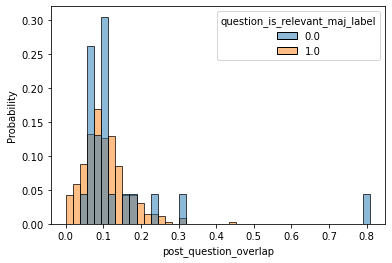

In [12]:
# fix data format
plot_data = question_relevant_annotation_data.loc[:, ['parent_id', 'post_question_overlap', 'question_is_relevant_maj_label']]
plot_data = pd.melt(plot_data, id_vars=['parent_id', 'question_is_relevant_maj_label'], value_vars=['post_question_overlap'], value_name='post_question_overlap').drop('variable', axis=1)
# plot data
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(data=plot_data, x='post_question_overlap', hue='question_is_relevant_maj_label', common_norm=False, stat='probability')
plt.show()

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


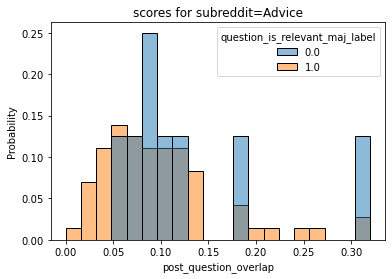

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


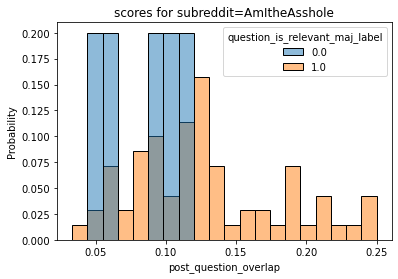

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


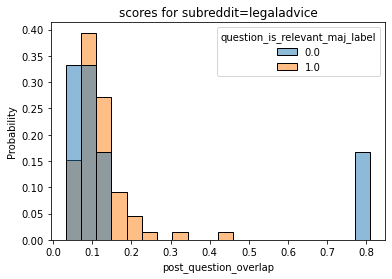

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


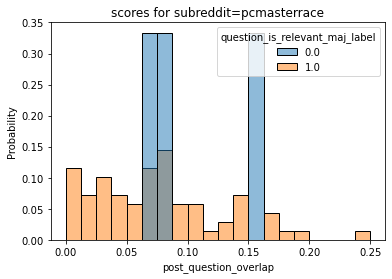

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


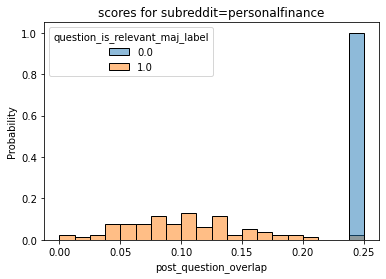

In [13]:
## separate by subreddit
score_var = 'post_question_overlap'
for subreddit_i, data_i in question_relevant_annotation_data.groupby('subreddit'):
    plot_data_i = data_i.loc[:, ['id', score_var, 'question_is_relevant_maj_label']]
    plot_data_i = pd.melt(plot_data_i, id_vars=['id', 'question_is_relevant_maj_label'], value_vars=[score_var], value_name=score_var).drop('variable', axis=1)
    # plot data
    sns.histplot(data=plot_data_i, x=score_var, hue='question_is_relevant_maj_label', bins=20, common_norm=False, stat='probability')
    plt.title(f'scores for subreddit={subreddit_i}')
    plt.show()

We have some mixing in the labels in the lower end of the overlap score, which shows that some questions may reference information from the post (small overlap) even without being relevant.

If we want to maximize precision, it seems like we should bound the overlap score at [0.125, 0.3].

In [16]:
overlap_bounds = [0.125, 0.3]
question_relevant_annotation_data = question_relevant_annotation_data.assign(**{
    'question_post_overlap' : (question_relevant_annotation_data.loc[:, 'post_question_overlap'] >= overlap_bounds[0]) & (question_relevant_annotation_data.loc[:, 'post_question_overlap'] <= overlap_bounds[1])
})
TP = ((question_relevant_annotation_data.loc[:, 'question_is_relevant_maj_label']==1) & (question_relevant_annotation_data.loc[:, 'question_post_overlap']==1)).sum()
FP = ((question_relevant_annotation_data.loc[:, 'question_is_relevant_maj_label']==0) & (question_relevant_annotation_data.loc[:, 'question_post_overlap']==1)).sum()
TN = ((question_relevant_annotation_data.loc[:, 'question_is_relevant_maj_label']==0) & (question_relevant_annotation_data.loc[:, 'question_post_overlap']==0)).sum()
FN = ((question_relevant_annotation_data.loc[:, 'question_is_relevant_maj_label']==1) & (question_relevant_annotation_data.loc[:, 'question_post_overlap']==0)).sum()
prec = TP / (TP + FP)
rec = TP / (TP + FN)
print(f'overlap bounds {"{:.3f}".format(overlap_bounds[0])}-{"{:.3f}".format(overlap_bounds[1])}: prec={"{:.3f}".format(prec)}; rec={"{:.3f}".format(rec)}')

overlap bounds 0.125-0.300: prec=0.965; rec=0.313


Now! Let's try to classify questions by `question_asks_for_more_info`.

In [17]:
## data label distribution
more_info_question_annotation_data = cutoff_annotation_data[cutoff_annotation_data.loc[:, 'question_asks_for_more_info_agree']]
more_info_label_counts = more_info_question_annotation_data.loc[:, 'question_asks_for_more_info_maj_label'].value_counts()
print(more_info_label_counts)

1.0    284
0.0    116
Name: question_asks_for_more_info_maj_label, dtype: int64


The class balance is not great, so let's try to oversample the minority class to make up for it.

In [18]:
## resample to get more data from minority class
from functools import reduce
from math import ceil
import numpy as np
np.random.seed(123)
def resample_data(data, label_var):
    label_counts = data.loc[:, label_var].value_counts()
    minority_label = label_counts.idxmin()
    N_majority = label_counts.max()
    N_minority = label_counts.min()
    N_resample = N_majority - N_minority
    resample_multiplier = int(ceil(N_resample / N_minority))
    minority_data = data[data.loc[:, label_var]==minority_label]
    resample_data_candidate_idx = list(reduce(lambda x,y: x+y, [minority_data.index.tolist(),]*resample_multiplier))
    resample_data_idx = np.random.choice(resample_data_candidate_idx, N_resample, replace=False)
    new_data = pd.concat(
        [data, data.loc[resample_data_idx, :]],
        axis=0
    )
    return new_data

In [19]:
label_var = 'question_asks_for_more_info_maj_label'
resample_more_info_data = resample_data(more_info_question_annotation_data, label_var)
print(resample_more_info_data.loc[:, label_var].value_counts())

0.0    284
1.0    284
Name: question_asks_for_more_info_maj_label, dtype: int64


In [20]:
from sklearn.feature_extraction.text import CountVectorizer
max_features=50
max_df = 0.25
cv = CountVectorizer(max_df=max_df, max_features=max_features)
dtm = cv.fit_transform(resample_more_info_data.loc[:, 'question'].values)
# top features
cv_vocab = list(sorted(cv.vocabulary_, key=cv.vocabulary_.get))
dtm_vocab_counts = pd.Series(np.array(dtm.sum(axis=0))[0], index=cv_vocab).sort_values(ascending=False)
print(dtm_vocab_counts.iloc[:10])
question_words = {'what', 'when', 'where', 'why', 'how', 'who', 'which'}
question_words = question_words & set(cv_vocab)
print(dtm_vocab_counts.loc[question_words].sort_values(ascending=False))

your    146
what    106
and     105
do       97
is       94
it       93
of       81
that     78
for      75
are      72
dtype: int64
what    106
why      64
how      43
who      20
dtype: int64


In [21]:
## k-fold validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
def train_test_model_multi_folds(X, Y, model, N_folds=5):
    k_fold = StratifiedKFold(n_splits=N_folds, shuffle=True, random_state=123)
    prediction_scores = []
    for train_idx, test_idx in k_fold.split(X, Y):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test, Y_pred)
        TP = ((Y_test==1) & (Y_pred==1)).sum()
        FP = ((Y_test==0) & (Y_pred==1)).sum()
        FN = ((Y_test==1) & (Y_pred==0)).sum()
        prec = TP / (TP + FP)
        rec = TP / (TP + FN)
        prediction_scores.append([prec, rec, f1])
    prediction_scores = pd.DataFrame(prediction_scores, columns=['prec', 'rec', 'f1'])
    return prediction_scores

In [22]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
label_var = 'question_asks_for_more_info_maj_label'
models = [
    SVC(C=1., kernel='rbf', max_iter=1000),
    LogisticRegression(penalty='l2', C=1., max_iter=1000),
    RandomForestClassifier(n_estimators=25)
]
info_labels = resample_more_info_data.loc[:, label_var].values
for model in models:
    print(f'model = {type(model)}')
    prediction_scores = train_test_model_multi_folds(dtm, info_labels, model, N_folds=10)
    print(f'mean prediction score =\n{prediction_scores.mean(axis=0)}')

model = <class 'sklearn.svm._classes.SVC'>
mean prediction score =
prec    0.841558
rec     0.810345
f1      0.823451
dtype: float64
model = <class 'sklearn.linear_model._logistic.LogisticRegression'>
mean prediction score =
prec    0.765063
rec     0.792241
f1      0.776283
dtype: float64
model = <class 'sklearn.ensemble._forest.RandomForestClassifier'>
mean prediction score =
prec    0.961266
rec     0.813793
f1      0.880427
dtype: float64


This is pretty good! In general, it seems pretty easy to determine which questions are asking for more info and which are not.

We'll use the random forest model for our labeling since it consistently achieves high precision with minimal recall loss.

What are the features more associated with the positive class?

In [23]:
## recompute DTM with non-sampled data
max_features=50
max_df = 0.25
cv = CountVectorizer(max_df=max_df, max_features=max_features)
raw_data_dtm = cv.fit_transform(more_info_question_annotation_data.loc[:, 'question'].values)
label_var = 'question_asks_for_more_info_maj_label'
raw_data_info_labels = more_info_question_annotation_data.loc[:, label_var].values

In [24]:
dtm_class_1 = raw_data_dtm[raw_data_info_labels == 1]
dtm_class_0 = raw_data_dtm[raw_data_info_labels == 0]
class_1_word_counts = pd.Series(np.array(dtm_class_1.sum(axis=0))[0], index=cv_vocab)
class_0_word_counts = pd.Series(np.array(dtm_class_0.sum(axis=0))[0], index=cv_vocab)
# normalize counts
class_1_word_counts = class_1_word_counts / class_1_word_counts.sum()
class_0_word_counts = class_0_word_counts / class_0_word_counts.sum()
class_0_1_word_counts = pd.concat([class_0_word_counts, class_1_word_counts], axis=1).fillna(0.)
class_0_1_word_diffs = class_0_1_word_counts.iloc[:, 1] - class_0_1_word_counts.iloc[:, 0]
class_0_1_word_diffs.sort_values(inplace=True, ascending=False)
display(class_0_1_word_diffs.head(10))
display(class_0_1_word_diffs.tail(10))

what    0.041288
have    0.039787
do      0.035865
at      0.030580
did     0.027301
your    0.025240
or      0.025202
want    0.018232
does    0.014447
in      0.013674
dtype: float64

don    -0.013222
go     -0.014134
not    -0.016095
so     -0.017420
just   -0.017918
her    -0.019879
and    -0.020385
how    -0.022614
like   -0.026168
why    -0.030183
dtype: float64

Great! As suspected, the "valid" clarification questions tend to have concrete directions (`what`, `did`), but the "invalid" clarification questions are more abstract (`want`, `how`, `why`) and situational (`her`, `just`)?

### Test social signals for "relevant"
We're getting pretty bad performance when identifying "relevant" questions.

Can we use common social signals (upvotes, comments, etc.) to identify relevant questions?

In [7]:
## get raw comment data
import re
import os
from data_helpers import load_zipped_json_data
import pandas as pd
data_dir = '../../data/reddit_data/'
comment_file_matcher = re.compile('subreddit_comments_\d{4}-\d{2}.gz')
comment_files = list(filter(lambda x: comment_file_matcher.match(x), os.listdir(data_dir)))
comment_files = list(map(lambda x: os.path.join(data_dir, x), comment_files))
## load all data
comment_data = pd.concat(list(map(lambda x: load_zipped_json_data(x), comment_files)), axis=0)
# fix parent IDs
comment_data = comment_data.assign(**{
    'parent_id' : comment_data.loc[:, 'parent_id'].apply(lambda x: x.split('_')[-1])
})

<ipython-input-7-53fb80523f96>:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  comment_data = pd.concat(list(map(lambda x: load_zipped_json_data(x), comment_files)), axis=0)


In [8]:
comment_data.head()

,author,author_flair_text,author_fullname,body,created_utc,edited,id,parent_id,score,subreddit
0,biblioteqa,None,NaN,"Sure, her parents can grant her [power of atto...",1517443201,False,dtjoj48,7ue3o7,13,legaladvice
1,CarmenFandango,None,NaN,"On the bright side, it does qualify as an unre...",1517443206,False,dtjoj9v,7uefnr,5,legaladvice
2,austinaccount,None,NaN,For a lot of people it is free money. If they ...,1517443206,1517483285,dtjoj9x,7ud3ue,98,personalfinance
3,scarymoose,None,NaN,"Based on what you've provided, assuming the ne...",1517443219,False,dtjojpn,7ubm9w,11,legaladvice
4,halloween420,i5 4440 3.1GHz / 980 TI,NaN,Was thinking about selling my 1050 SC on ebay ...,1517443241,False,dtjokgm,7u97wu,1,pcmasterrace


In [9]:
## reload annotator data
import pandas as pd
import numpy as np
import re
import os
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import fix_encoding_errors
data_dir = '../../data/reddit_data/annotation_data/round_2_annotation_sample/test_data/'
unlabeled_data_file = os.path.join(data_dir, 'advice_subreddit_no_filter_comment_question_data_annotation_sample.tsv')
annotation_data = pd.read_csv(unlabeled_data_file, sep='\t', index_col=False)
label_cols = ['question_is_relevant', 'question_asks_for_more_info']
annotation_data.drop(label_cols, axis=1, inplace=True)
annotator_file_matcher = re.compile('(?<=_sample_)(\d+)(?=\.tsv)')
annotator_files = list(filter(lambda x: annotator_file_matcher.search(x) is not None, os.listdir(data_dir)))
annotator_files = list(map(lambda x: os.path.join(data_dir, x), annotator_files))
num_annotators = len(annotator_files)
text_vars = ['question']
for annotator_file_i in annotator_files:
    annotator_data_i = pd.read_csv(annotator_file_i, sep='\t', index_col=0)
    annotator_data_i = fix_encoding_errors(annotator_data_i, text_vars=text_vars)
    label_i = annotator_file_matcher.search(annotator_file_i).group(0)
    ## join data
    annotation_data = pd.merge(annotation_data, annotator_data_i.loc[:, ['parent_id']+label_cols], on=['parent_id'], how='left')
    annotation_data.rename(columns={
        label_col : f'{label_col}_{label_i}'
        for label_col in label_cols
    }, inplace=True)
display(annotation_data.head())
# move labels to A, B columns
def assign_next_annotation(annotation_list):
    if(len(annotation_list) > 1):
        return annotation_list[1]
    else:
        return np.nan
annotator_nums = list(range(num_annotators))
for label_col_i in label_cols:
    annotator_label_cols_i = list(map(lambda x: f'{label_col_i}_{x}', annotator_nums))
    annotation_data = annotation_data.assign(**{
        label_col_i : annotation_data.loc[:, annotator_label_cols_i].apply(lambda x: list(filter(lambda y: not np.isnan(y), x.tolist())), axis=1)
    })
    annotation_data = annotation_data.assign(**{
        f'{label_col_i}_num_0' : annotation_data.loc[:, label_col_i].apply(lambda x: x[0]),
        f'{label_col_i}_num_1' : annotation_data.loc[:, label_col_i].apply(lambda x: assign_next_annotation(x)),
    })
display(annotation_data.head())
## debug: remove annotator columns without sufficient annotators
label_cols = ['question_is_relevant', 'question_asks_for_more_info']
num_annotators_per_question = 2
annotation_cols = [f'{label_col}_num_{i}' for label_col in label_cols for i in range(num_annotators_per_question)]
cutoff_annotation_data = annotation_data.dropna(subset=annotation_cols, axis=0, how='any')
## restrict to questions with perfect agreement
from scipy.stats import mode
for label_col_i in label_cols:
    annotation_cols_i = [f'{label_col_i}_num_{i}' for i in range(num_annotators_per_question)]
    agree_col_i = f'{label_col_i}_agree'
    cutoff_annotation_data = cutoff_annotation_data.assign(**{
        agree_col_i : cutoff_annotation_data.loc[:, annotation_cols_i].apply(lambda x: x.min()==x.max() and x.min() != -1, axis=1)
    })
    print(f'label={label_col_i}; {cutoff_annotation_data.loc[:, agree_col_i].sum()}/{cutoff_annotation_data.shape[0]} data with agreement')
    ## assign majority label
    cutoff_annotation_data = cutoff_annotation_data.assign(**{
        f'{label_col_i}_maj_label' : cutoff_annotation_data.loc[:, annotation_cols_i].apply(lambda x: mode(x.values).mode[0], axis=1)
    })
question_relevant_annotation_data = cutoff_annotation_data[cutoff_annotation_data.loc[:, 'question_is_relevant_agree']]
# total count of variable
print(question_relevant_annotation_data.loc[:, 'question_is_relevant_maj_label'].value_counts())

,post_title,post_text,question,parent_id,subreddit,question_is_relevant_2,question_asks_for_more_info_2,question_is_relevant_0,question_asks_for_more_info_0,question_is_relevant_1,question_asks_for_more_info_1
0,Introvert (17M) wants to make foreign friends,"Hi, I’m a 17 year old who’s quite introverted ...",Where are you from?,dtx5b8,Advice,NaN,NaN,1.0,1.0,0.0,1.0
1,My job,So I got a job at a superstore chain about a w...,Have you sent resumes to local news stations?,c1q9qx,Advice,NaN,NaN,1.0,1.0,0.0,1.0
2,Is being picky really that bad,People always get mad at me and call me picky ...,"Oh, a girl wants a 6’ ripped handsome smart guy?",czfqtd,Advice,NaN,NaN,0.0,0.0,1.0,0.0
3,A lecturer attracted to his student,"Recently, my friend told me that a lecturer co...",Is he being a creep about it?,bdsoqy,Advice,NaN,NaN,1.0,1.0,1.0,1.0
4,Affair within an Affair,I have been dating a married man for several y...,I mean look at it this way - how does hiding t...,bz17qx,Advice,NaN,NaN,1.0,0.0,1.0,0.0


,post_title,post_text,question,parent_id,subreddit,question_is_relevant_2,question_asks_for_more_info_2,question_is_relevant_0,question_asks_for_more_info_0,question_is_relevant_1,question_asks_for_more_info_1,question_is_relevant,question_is_relevant_num_0,question_is_relevant_num_1,question_asks_for_more_info,question_asks_for_more_info_num_0,question_asks_for_more_info_num_1
0,Introvert (17M) wants to make foreign friends,"Hi, I’m a 17 year old who’s quite introverted ...",Where are you from?,dtx5b8,Advice,NaN,NaN,1.0,1.0,0.0,1.0,"[1.0, 0.0]",1.0,0.0,"[1.0, 1.0]",1.0,1.0
1,My job,So I got a job at a superstore chain about a w...,Have you sent resumes to local news stations?,c1q9qx,Advice,NaN,NaN,1.0,1.0,0.0,1.0,"[1.0, 0.0]",1.0,0.0,"[1.0, 1.0]",1.0,1.0
2,Is being picky really that bad,People always get mad at me and call me picky ...,"Oh, a girl wants a 6’ ripped handsome smart guy?",czfqtd,Advice,NaN,NaN,0.0,0.0,1.0,0.0,"[0.0, 1.0]",0.0,1.0,"[0.0, 0.0]",0.0,0.0
3,A lecturer attracted to his student,"Recently, my friend told me that a lecturer co...",Is he being a creep about it?,bdsoqy,Advice,NaN,NaN,1.0,1.0,1.0,1.0,"[1.0, 1.0]",1.0,1.0,"[1.0, 1.0]",1.0,1.0
4,Affair within an Affair,I have been dating a married man for several y...,I mean look at it this way - how does hiding t...,bz17qx,Advice,NaN,NaN,1.0,0.0,1.0,0.0,"[1.0, 1.0]",1.0,1.0,"[0.0, 0.0]",0.0,0.0


label=question_is_relevant; 378/500 data with agreement
label=question_asks_for_more_info; 400/500 data with agreement
1.0    355
0.0     23
Name: question_is_relevant_maj_label, dtype: int64


In [10]:
## join annotator data with comment ID UGH
if('id' not in question_relevant_annotation_data.columns):
    question_meta_data = pd.read_csv('../../data/reddit_data/advice_subreddit_no_filter_comment_question_data.gz', sep='\t', compression='gzip', usecols=['question', 'id'])
    question_relevant_annotation_data = pd.merge(question_relevant_annotation_data, question_meta_data, on=['question'], how='left')
# add score data
if('score' not in question_relevant_annotation_data.columns):
    question_relevant_annotation_data = pd.merge(question_relevant_annotation_data, comment_data.loc[:, ['id', 'score']], on='id', how='left')
display(question_relevant_annotation_data.head())

,post_title,post_text,question,parent_id,subreddit,question_is_relevant_2,question_asks_for_more_info_2,question_is_relevant_0,question_asks_for_more_info_0,question_is_relevant_1,question_asks_for_more_info_1,question_is_relevant,question_is_relevant_num_0,question_is_relevant_num_1,question_asks_for_more_info,question_asks_for_more_info_num_0,question_asks_for_more_info_num_1,question_is_relevant_agree,question_is_relevant_maj_label,question_asks_for_more_info_agree,question_asks_for_more_info_maj_label,id,score
0,A lecturer attracted to his student,"Recently, my friend told me that a lecturer co...",Is he being a creep about it?,bdsoqy,Advice,NaN,NaN,1.0,1.0,1.0,1.0,"[1.0, 1.0]",1.0,1.0,"[1.0, 1.0]",1.0,1.0,True,1.0,True,1.0,el0gx5e,1
1,Affair within an Affair,I have been dating a married man for several y...,I mean look at it this way - how does hiding t...,bz17qx,Advice,NaN,NaN,1.0,0.0,1.0,0.0,"[1.0, 1.0]",1.0,1.0,"[0.0, 0.0]",0.0,0.0,True,1.0,True,0.0,eqoptfy,1
2,So my (16m) mom(40f) and dad (41m) are going t...,So my parents are under a lot of strain lately...,Have you told your parents lately that you lov...,bre113,Advice,NaN,NaN,1.0,1.0,1.0,0.0,"[1.0, 1.0]",1.0,1.0,"[1.0, 0.0]",1.0,0.0,True,1.0,False,0.0,eocvkoo,1
3,How to ask for a raise when you work remotely ...,"Title says it all, I work remotely from home a...",Do you ever go into the office for any reason?,9pdun5,Advice,NaN,NaN,1.0,1.0,1.0,1.0,"[1.0, 1.0]",1.0,1.0,"[1.0, 1.0]",1.0,1.0,True,1.0,True,1.0,e8136m4,2
4,I’m not good at anything.,I need help. Genuinely. I’m a 23 female and I ...,Is HR my passion?,axkohg,Advice,NaN,NaN,0.0,0.0,0.0,0.0,"[0.0, 0.0]",0.0,0.0,"[0.0, 0.0]",0.0,0.0,True,0.0,True,0.0,dtfa093,2


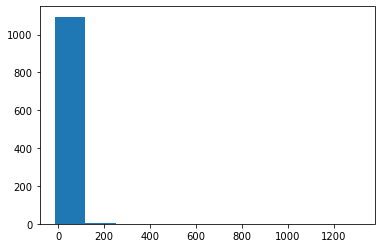

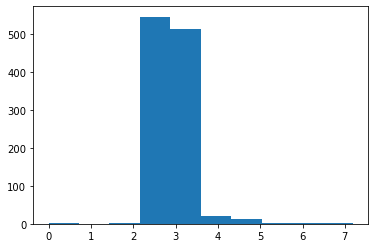

In [11]:
# what is the overall score distribution?
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(question_relevant_annotation_data.loc[:, 'score'])
plt.show()
# log-scale
import numpy as np
norm_scores = np.log(question_relevant_annotation_data.loc[:, 'score'] - question_relevant_annotation_data.loc[:, 'score'].min() + 1)
question_relevant_annotation_data = question_relevant_annotation_data.assign(**{'norm_score' : norm_scores})
plt.hist(question_relevant_annotation_data.loc[:, 'norm_score'])
plt.show()

Let's compare the scores for relevant vs. irrelevant questions.

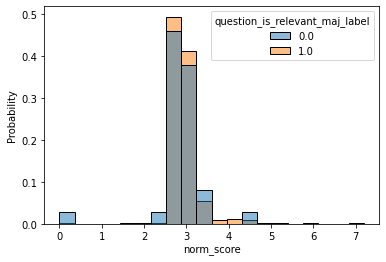

In [14]:
# fix data format
plot_data = question_relevant_annotation_data.loc[:, ['id', 'norm_score', 'question_is_relevant_maj_label']]
plot_data = pd.melt(plot_data, id_vars=['id', 'question_is_relevant_maj_label'], value_vars=['norm_score'], value_name='norm_score').drop('variable', axis=1)
# plot data
import seaborn as sns
sns.histplot(data=plot_data, x='norm_score', hue='question_is_relevant_maj_label', bins=20, common_norm=False, stat='probability')
plt.show()

OK! Most relevant and irrelevant questions tend to have the same score distribution.

What if we separate this by subreddit?

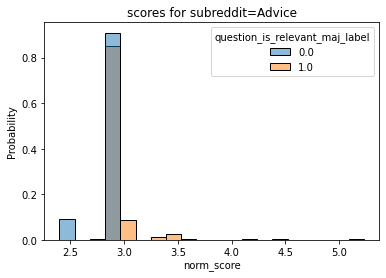

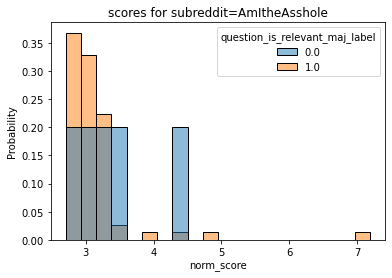

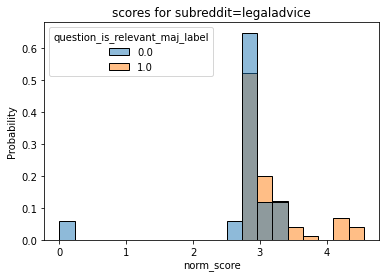

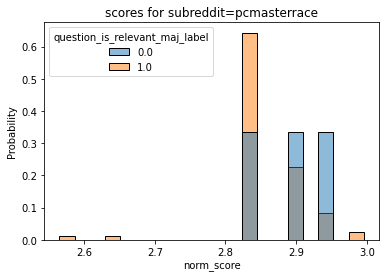

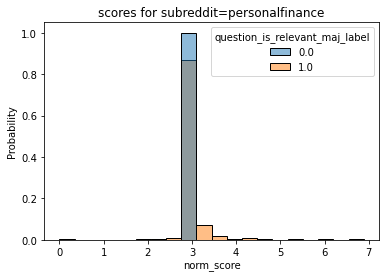

In [15]:
for subreddit_i, data_i in question_relevant_annotation_data.groupby('subreddit'):
    plot_data_i = data_i.loc[:, ['id', 'norm_score', 'question_is_relevant_maj_label']]
    plot_data_i = pd.melt(plot_data_i, id_vars=['id', 'question_is_relevant_maj_label'], value_vars=['norm_score'], value_name='norm_score').drop('variable', axis=1)
    # plot data
    sns.histplot(data=plot_data_i, x='norm_score', hue='question_is_relevant_maj_label', bins=20, common_norm=False, stat='probability')
    plt.title(f'scores for subreddit={subreddit_i}')
    plt.show()

This is not much better! It looks like total score is not a good marker for relevance.

## Debug data flow
Let's figure out where we lose so many questions/posts.

In [2]:
import pandas as pd
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', index_col=False)
import numpy as np
from ast import literal_eval
import re
post_data.rename(columns={'id': 'parent_id', 'created_utc': 'parent_created', 'selftext': 'parent_text', 'title': 'parent_title', 'edited': 'parent_edited', 'author': 'parent_author'}, inplace=True)
# remove null posts
post_data = post_data[~post_data.loc[:, 'parent_id'].apply(lambda x: type(x) is float and np.isnan(x))]
post_data = post_data[~post_data.loc[:, 'parent_edited'].apply(lambda x: type(x) is float and np.isnan(x))]
# remove edited posts
bool_matcher = re.compile('True|False')
post_data = post_data[post_data.loc[:, 'parent_edited'].apply(lambda x: bool_matcher.match(str(x)) is not None and not literal_eval(bool_matcher.match(x).group(0)))]

In [3]:
## load comment data
import re
import os
from data_helpers import load_zipped_json_data
data_dir = '../../data/reddit_data/'
comment_file_matcher = re.compile('subreddit_comments_\d{4}-\d{2}.gz')
comment_files = list(filter(lambda x: comment_file_matcher.match(x), os.listdir(data_dir)))
comment_files = list(map(lambda x: os.path.join(data_dir, x), comment_files))
## load all data
comment_data = pd.concat(list(map(lambda x: load_zipped_json_data(x), comment_files)), axis=0)
# fix parent IDs
comment_data = comment_data.assign(**{
    'parent_id' : comment_data.loc[:, 'parent_id'].apply(lambda x: x.split('_')[-1])
})
# remove comments without parents
comment_data = comment_data[comment_data.loc[:, 'parent_id'].apply(lambda x: type(x) is not float)]
print(comment_data.shape[0])

6186885


In [ ]:
## get questions, flatten data
from data_helpers import extract_questions_all_data
min_question_len = 5
comment_data = comment_data.assign(**{
    'questions' : extract_questions_all_data(comment_data.loc[:, 'body'], min_question_len=min_question_len)
})
# remove comment body to save space!!
comment_data.drop('body', axis=1, inplace=True)
# remove invalid questions: quotes, bots
quote_matcher = re.compile('&gt;.+')
comment_data = comment_data.assign(**{
    'questions': comment_data.loc[:, 'questions'].apply(
        lambda x: list(
            filter(lambda y: quote_matcher.search(y) is None, x)))
})
invalid_authors = ['LocationBot', 'AutoModerator']
comment_data = comment_data[~comment_data.loc[:, 'author'].isin(invalid_authors)]
## remove bad comments
# remove null questions
comment_data = comment_data[~comment_data.loc[:, 'questions'].apply(lambda x: type(x) is float and np.isnan(x))]
from data_helpers import flatten_columns
flat_col = 'questions'
comment_data = flatten_columns(comment_data, flat_col=flat_col)
comment_data.rename(columns={'questions': 'question'}, inplace=True)
comment_data = comment_data.assign(**{'question_id' : comment_data.loc[:, 'question'].apply(lambda x: hash(x))})
# remove duplicates
comment_data.drop_duplicates(['parent_id', 'question_id'], inplace=True)

100%|██████████| 6186885/6186885 [33:43<00:00, 3057.29it/s]  
4151559it [52:21, 1342.18it/s]

In [ ]:
print(comment_data.shape)
print(post_data.shape)

In [ ]:
## combine post/comment data
post_cols = ['parent_id', 'parent_created', 'parent_text', 'parent_title', 'parent_edited', 'parent_author']
valid_post_ids = set(comment_data.loc[:, 'parent_id'].unique()) & set(post_data.loc[:, 'parent_id'].unique())
post_comment_data = pd.merge(comment_data, post_data.loc[:, post_cols],
                             on='parent_id')
print(f'{post_comment_data.shape[0]}/{comment_data.shape[0]} comments retained after merge with posts')

In [ ]:
print(comment_data[~comment_data.loc[:, 'parent_id'].isin(valid_post_ids)].shape[0])
display(comment_data[~comment_data.loc[:, 'parent_id'].isin(valid_post_ids)].drop_duplicates('parent_id').head(10))

The "invalid" comments connect to posts that were edited, so it's valid to remove those comments.

In [ ]:
## compute overlap
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
from nltk.stem import PorterStemmer
from data_helpers import tokenize_stem_text
from tqdm import tqdm
tqdm.pandas()
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = PunktSentenceTokenizer()
stemmer = PorterStemmer()
post_comment_data = post_comment_data.assign(**{
    'parent_sents': post_comment_data.loc[:, 'parent_text'].progress_apply(
        lambda x: tokenize_stem_text(x, stemmer, word_tokenizer, sent_tokenizer)),
})
from data_helpers import compute_sent_word_overlap
post_comment_data = post_comment_data.assign(**{
    'post_question_overlap': post_comment_data.progress_apply(lambda x: compute_sent_word_overlap(x.loc['parent_sents'], [x.loc['question']]), axis=1)
})
post_comment_data = post_comment_data.assign(**{
    'post_question_overlap_score': post_comment_data.loc[:,'post_question_overlap'].apply(lambda x: x[0]),
    'post_question_overlap_sent': post_comment_data.loc[:, 'post_question_overlap'].apply(lambda x: x[1][0]),
})

Investigate questions with low overlap to determine if they are still valid.

In [ ]:
pd.set_option('display.max_colwidth', 500)
display(post_comment_data[(post_comment_data.loc[:, 'post_question_overlap_score'] >= 0.05) & 
                          (post_comment_data.loc[:, 'post_question_overlap_score'] < 0.1)].loc[:, ['parent_text', 'question', 'post_question_overlap_score']].head(10))
overlap_score_range = [0.05, 0.5]
valid_overlap_post_comment_data = post_comment_data[(post_comment_data.loc[:,'post_question_overlap_score'] >= overlap_score_range[0]) &
                                                    (post_comment_data.loc[:, 'post_question_overlap_score'] < overlap_score_range[1])]
print(f'{valid_overlap_post_comment_data.shape[0]}/{post_comment_data.shape[0]} valid overlap questions')

### Look for posts that ask for social groups
Are there any posts that ask for help from specific social groups? We can use these as justification for the study!!

In [3]:
import pandas as pd
submission_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz',
                              sep='\t', usecols=['subreddit', 'selftext', 'id'])
submission_data.dropna(subset=['selftext'], inplace=True)
submission_data.rename(columns={'id' : 'parent_id'}, inplace=True)
submission_data = submission_data.assign(**{
    'selftext_clean' : submission_data.loc[:, 'selftext'].apply(lambda x: x.lower())
})
display(submission_data.head())

,parent_id,selftext,subreddit,selftext_clean
0,7nby0l,"26M/married/2 kids\n\nEmployer match is 50% up to $1000. Meaning you give $1000, they give $500. There is no match after that. They make one single $500 deposit on the 31st of December.\n\n\nThe plan is through Ascensus, and has some decent options and low expenses compared to some of what I've seen here. I've got about $28k in the account, after about 19 months of contributions. I contribute 12%, which is about $12,000/yr right now. My funds are allocated between some blue chip stock funds with low-ish expense ratios around 0.2%, and a growth strategy fund that's at 0.33%. 2017 was my first full calendar year in the plan, and i was very impressed with my return of 27.2% and expenses of 0.3%.\n\n\nThe employer match has me feeling like I may be wasting time with it, but the returns and seemingly average expenses keep me in it. I can't afford to up my contributions at this time(kids are expensive) but I'm finding myself yearning for the employer match at my old company, which was 100% match to 6%, 50% match to 18%.\n\nIs it worth investing my money elsewhere?",personalfinance,"26m/married/2 kids\n\nemployer match is 50% up to $1000. meaning you give $1000, they give $500. there is no match after that. they make one single $500 deposit on the 31st of december.\n\n\nthe plan is through ascensus, and has some decent options and low expenses compared to some of what i've seen here. i've got about $28k in the account, after about 19 months of contributions. i contribute 12%, which is about $12,000/yr right now. my funds are allocated between some blue chip stock funds with low-ish expense ratios around 0.2%, and a growth strategy fund that's at 0.33%. 2017 was my first full calendar year in the plan, and i was very impressed with my return of 27.2% and expenses of 0.3%.\n\n\nthe employer match has me feeling like i may be wasting time with it, but the returns and seemingly average expenses keep me in it. i can't afford to up my contributions at this time(kids are expensive) but i'm finding myself yearning for the employer match at my old company, which was 100% match to 6%, 50% match to 18%.\n\nis it worth investing my money elsewhere?"
1,7nby5t,"On November 24th, I called AT&amp;T to inquire about setting up wireless service with them for 4 lines. The woman on the phone told me I can switch to AT&amp;T and they would pay my early termination fee (ETF) from Verizon and not charge any activation fees. I asked if I needed to trade in my phones for the ETF to be paid, and she assured me that I would not. My AT&amp;T bill includes $100 of activation fees, and when I submitted my Verizon bill to be processed to get the ETF credited, they denied my request. I called customer service to clear this up, and they credited me for the activation fee, but refuse to do so for the $880 ETF. I escalated to a manager and she told me there is nothing they can do as it is actually a third party that handles the ETF, and that I needed to trade in my phone, even though the original person I spoke with said otherwise. She then gave me an address for some ""correspondents' department"" to write them a written complaint to look into the matter, which I will be doing. I will also be filing a complaint with the FCC and the Bureau of Consumer Protection, and the Florida State Attorney General, but I am worried this won't do anything since the consumer agreement has a binding arbitration clause. Any advice on how to handle this would be much appreciated, thank you in advance.",legaladvice,"on november 24th, i called at&amp;t to inquire about setting up wireless service with them for 4 lines. the woman on the phone told me i can switch to at&amp;t and they would pay my early termination fee (etf) from verizon and not charge any activation fees. i asked if i needed to trade in my phones for the etf to be paid, and she assured me that i would not. my at&amp;t bill includes $100 of activation fees, and when i 

In [5]:
import re
pd.set_option('display.max_colwidth', 5000)
request_matcher = re.compile('(i\'m looking for advice from)')
request_submission_data = submission_data[submission_data.loc[:, 'selftext_clean'].apply(lambda x: request_matcher.search(x) is not None)]
print(f'N={request_submission_data.shape[0]}')
for subreddit_i, data_i in request_submission_data.groupby('subreddit'):
    display(data_i.loc[:, ['parent_id', 'subreddit', 'selftext_clean']].head(10))

N=31


,parent_id,subreddit,selftext_clean
54659,7zikhs,Advice,"i'm looking for advice from impartial people.\n\nto give a little background information, i recently went through a nasty split with my fiance of several years. my relationship with him, up until the dividing issue, was solid. \n\ni have just discovered that my best friend spent many months telling my coworkers that my relationship was illegitimate, that i was only dating him because i pitied him for his looks, and that my fiance and i were really just platonic friends but that i agreed to get married out of desperation. (to be clear, none of this is true - although others do find him to be unattractive in a conventional sense, i did not. she was projecting.) as a result, as i have now learned, my legitimate relationship became a workplace joke, and everyone has been mocking me and my fiance behind our backs for a year, including my bosses. this also includes people who i excitedly called after getting engaged and people that i had offered positions in my wedding party to. to make things worse, the fact that the relationship ended is being blamed on me being shallow about his appearance and is being used as vindication for these rumors. not that it matters, but it ended for a plethora of deeply ingrained and painful issues, none of which were in any way related to appearance. \n\ni feel so betrayed by this friend that i can't imagine ever reconciling. i am preparing to completely cut her from my life and just want to know if others would do the same, or if i'm overreacting to average workplace drama. \n\n"
343729,a1m8vk,Advice,"my brother (older than me by 7 years) and i grew up together in the same house, with mom and dad. mom died when i was 9, he was 16. dad raised us the rest of the way. \n\na few years ago, my grandmother (who is getting old and slipping when she says things) said something she shouldn't have said to my wife. she goes, ""yeah, \[op's\] dad did such a good thing, taking \[my brother\] in like he was his own...""\n\ni angrily made some calls to my dad and my other grandmother and verified that indeed my brother and i have been lied to our whole lives, and that as a 22 year old man i was finding out that my brother and i are really half-brothers, and that he has a different dad somewhere.\n\ni guess what happened was my mom wanted to tell him eventually, but she passed away and never got the chance. my dad is very non-confrontational and never told him. everyone else in my family thinks it should be his job, but knowing him it probably won't happen.\n\nwhen i ask my dad about it, he just says something like, ""it won't change anything. i'm his dad and always will be..."" which i agree with. he is very much his dad and that's that. but i think i would want to know the truth if i were in my brother's shoes. another difficult part about this is that my brother takes a lot of pride in the name of our family. he wears our last name proudly, and i think it would hurt his pride and his identity to find out that he really has never shared blood with his own last name.\n\nmy brother (or his wife) don't know any of this. every time i see him i think about it, and i wonder if it's just a matter of time until he finds out. i am concerned that he will be angry at me for not telling him when i found out, but i just don't know if it's my place.\n\ni'm looking for advice from people who have been in similar situations. should i tell him?\n\n&amp;#x200b;\n\ntl;dr: my brother doesn't know that he's really my half brother. he's an adult male. do i tell him?"
368236,a7jwc7,Advice,so i'm looking for advice from someone in the tech world. i have an idea for an app but not the technical skills required to create it. where would you recommend that i go in order get this idea into the right hands?
505205,b408fo,Advice,"within the last few months, i have come to the realization that it is time to make a very drastic change in my life and move away from my lovely state of illino

,parent_id,subreddit,selftext_clean
295296,9ptgtv,legaladvice,"hi everyone. first i want to say thank you for any advice. i appreciate all input but i'm looking for advice from someone who has practiced law in florida.\n\nthe estate of my grandmother was selling her house. our real estate agent presented my father with a contract on a sunday saying it needed to be signed and returned to the buyer by the next day. my father cannot read well due to eye problems and my step-grandfather (the executor/signer) is nearly blind. they both trusted that the real estate agent had reviewed the contract. the buyer had added a repair penalty to the otherwise as-is contract that we would be responsible for 3x the cost of repairs. when our lawyer finally reviewed the contract he noticed the issue and began fighting the validity of the contract. we currently have a real estate lawyer also coming on board to fight against the scammers (buyers) who apparently do this thing often. \n\ni asked the first lawyer ""why don't we just offer them 20,000$ to ""get rid of them"" instead of spending 20k and several months in court?"" (we give them a document saying we could fight in court or just give them money in exchange for agreeing the contract is void)\n\nthe house is under a reverse mortgage that is running out of time and the whole taking time in court for justice might make things worse for us. we always have the option of suing the agency whose real estate agent didn't review a contract for us very well. the lawyers thought the idea of paying off the scammers was bad.....but it makes them less money....soo what do you think?"
298862,9qqsaj,legaladvice,"hello all, long time reader, first time poster.\n\ni'm looking for advice from anyone who has legally changed their child's (or their own) birth certificate. \n\nbackground: my husband and i couldn't agree on a name when our daughter was born. she remained unnamed for a week until we caved from pressure (from both our family and ourselves) and essentially just threw a dart at our name list and picked one. as soon as we announced it, i realized i had made a mistake. every time her name was said i would physically cringe. fast forward 4 months and i found myself deeply depressed over it. my husband agreed to think about changing it and we basically just called her different names until we found one that stuck. dd is now almost 7 months old and i absolutely love her new name. we announced to family and friends that we were changing her name about a month ago and everyone calls her by her new name now and it's like music to my ears. i want to go ahead and make it official by legally changing her name on her birth certificate. we live in california and i have heard that the name change process here is rather complicated. my husband is hesitant to do a legal change because he thinks it is going to cause issues for dd later in life (for example, dealing with background checks or writing ""aka original name"" on all legal documents).\n\ni would really love to change her name and make it official, but we both really want to know what we would be getting into before we go through with the change. if anyone has gone through a similar situation, we would love some insight as to your experience."
467785,ausby2,legaladvice,"my father passed away in 2017 minnesota with a will that was about 15 years old. he designated one of his friends at the current time as the personal representative. once my father passed, the pr was a bit surprised that he was the pr, given that he hasn't spoken to my father is sometimes, and stated that his health wasn't up to the task. given that i'm the only next of kin, i thought maybe i could help in the process.\n\nwhen the time came for my dad's friend to state to the court he did want to be the pr, he had a change of heart. the reason why is unknown because he refuses to talk to me. he has hired a lawyer to handle the fully handle the estate and has requested that all communication g

parent_id     subreddit  \
31651     7ubhko  pcmasterrace   
211351    946e2f  pcmasterrace   
448031    aq9fvu  pcmasterrace   
568290    bjuioe  pcmasterrace   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

parent_id        subreddit  \
123728    8h64au  personalfinance   
215188    956we9  personalfinance   
254672    9fh3pt  personalfinance   
378816    aa7fz9  personalfinance   
480025    axp480  personalfinance   
621044    bwf6kk  personalfinance   
646667    c2cd30  personalfinance   
727133    ckz1kh  personalfinance   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Can we match these posts with questions, to find a good example of a question that could have been answered in the original post?

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', 5000)
import re
question_data = pd.read_csv('../../data/reddit_data/combined_data_clean_question_data.gz', 
                            sep='\t', usecols=['id', 'article_id', 'source_text', 'target_text', 'reader_token_str', 'subreddit'])
question_data.drop_duplicates('article_id', inplace=True)
question_data = question_data.assign(**{
    'clean_source_text' : question_data.loc[:, 'source_text'].apply(lambda x: x.lower())
})
request_question_data = question_data[question_data.loc[:, 'clean_source_text'].apply(lambda x: re.search('(need|want|looking for) advice from', x) is not None)]
for subreddit_i, data_i in request_question_data.groupby('subreddit'):
    display(data_i.loc[:, ['subreddit', 'clean_source_text', 'target_text', 'reader_token_str']].head(5))

,subreddit,clean_source_text,target_text,reader_token_str
25836,Advice,"i am a soon-to-be graduate from a one of the top 10 electrical engineering programs in the us. i am expected to graduate at the end of february, but i currently do not have a job lined up. all my fellow classmates who are graduating with me, or even in may, already have jobs lined up. i’m feeling stuck because i am already 4.5 years in to getting this degree, and i am not finding any jobs that i actually want to do. i don’t enjoy coding or designing.if i even went into an interview for electrical engineering, i don’t think i could portray enthusiasm for the job. i don’t want to lie myself into a career i hate just to pay the bills.i am starting to feel that i don’t even want to go into a career in the engineering field. i did have an engineering internship early on in my degree, and i hated it. i felt like i did not add anything into the team of engineers, and i dreaded going in every day.i am very good in mathematics and that’s the main reason i pursued engineering in the first place. i enjoy solving math problems and writing technical reports. i stumbled across an article that does a better job of putting my feelings and emotions into words. he was a graduate in electrical and computer engineering, who ended up becoming a financial analyst. if any of you would like to read the article, it can be found here: [http://www.olin.edu/blog/career-and-graduate-stories/post/what-if-i-don%e2%80%99t-want-be-engineer/](http://www.olin.edu/blog/career-and-graduate-stories/post/what-if-i-don%e2%80%99t-want-be-engineer/) i am open to continuing my education, because i am one of those weird ones that loves school. although i am open to graduate school, i am on the fence because i need to start supporting myself and paying back my loans.i am looking for advice from anyone who may have found yourself in a similar situation. what did you do and where are you now in life?","But really, why are you asking reddit?",UNK
26112,Advice,"for those of you who don't know apush stands for ap us history, i currently a junior and have a 78% in that class which is stressing me out beyond belief. just looking for advice from those of you who have graduated high school or even college. what does it even mean to get bad grades in high school? would this be considered a bad grade? will i not be able to get into what would be considered a good college with this grade? it seems like the goal of life is to get good grades, so you can get into a good college, and get a good job. in all honesty i just want to be able to survive, succeed by my own definition, and stay happy when it comes to me living out my life. for those of you who have gotten into to college, would this impact my odds on getting in? thanks all.",Do you need help or study resources??,<NONUS_AUTHOR>
48914,Advice,"i am looking for advice from people to help me choose between two jobs.i am a graduate from aircraft maintenance program in canada, and i recently got hired as a ramp agent by both companies. my goal is to become a licensed engineer in the future, and as canadian regulation stands anyone who wants to become a licensed engineer has to work as apprentice to fill out their work log book to 75% completion. however, before getting the apprentice position most companies prefer to hire people with some ramp experience. think of the ramp job as pre-apprenticeship of an apprenticeship.here comes my problem.company a specialized in ramp work, and is offering a full time position (40hr per week) with $3/hr more than the other company. however, i would have to find an apprentice position elsewhere after i have enough ramp experience.company b is a small local airline, with potential to get an internal transfer into apprentice position after 1 or 2 years of work within company if such position is available. however, the catch is, the pay is $3/hr less with no benefit. the job is also an on-call part time only job, meaning i'll only 

,subreddit,clean_source_text,target_text,reader_token_str
52168,AmItheAsshole,"a couple years ago i made friends with a guy and a girl who we'll call sarah and dan. we grew to be fairly good friends. we're all adults in our mid 20s and when we get together we get really into talking about our relationships.it just so happens that dan is gay, and he liked to actively participate in giving out advice when sarah and i had relationship issues, and we could do the same for him. but after a while i noticed that he never actually gave me any advice when i had problems with my romantic relationships. when sarah wanted to talk about her problems he was helpful and gave sound advice, but whenever i was seeking the same, his advice began and ended with ""you should dump your boyfriend and switch to girls.""i thought it was a joke the first time but he kept saying it every time i went looking for advice from my friends. he never gave that advice to sarah when she was having guy problems (even though she's bisexual and that advice would be more applicable to her, although i personally think it's a rude thing to say to anyone). i'm straight, and i have never implied otherwise. i've never even been bi-curious. for me, personally, the idea of myself being with a woman romantically makes me uncomfortable and i told that to dan several times and asked him to stop. he said he would try. he didn't stop. i started skipping meeting up with dan and sarah because his comments continued to make me uncomfortable, but several days ago i decided to meet them for brunch and we started talking romantic relationships. i was supportive as he described a few problems with his current boyfriend and sarah and i offered a few suggestions to how he could solve those problems; overall it was a good chat.i'm finally in a committed relationship with a man i adore and i was very excited to share my excitement about it. along the way i mentioned just a couple pet peeves i had with my boyfriend (that aren't even a big issue) and dan said it again. ""well, time for you to dump him and switch to girls!""i just snapped. i raised my voice (not quite a yell, but louder than usual) and asked, ""dan, why don't *you* switch to girls?""he acted like i slapped him. started crying and demanding to know why i'd ever say something so horrible to him, then he grabbed his stuff and stormed out. sarah told me how disgusted she was by me and also stormed out. (side note: that left me to pay the entire bill for brunch when we agreed beforehand we were all only paying for ourselves, so that was awesome /s.)a few days ago i got a text from sarah that said she talked to dan and both of them are disgusted by my behavior and have decided they can't interact with such a ""hateful, homophobic bitch"" anymore and both will be blocking my number and blocking me on all forms of social media.i still feel pretty justified in what i said but it's started eating at me, especially because it made two different people decide i'm horrible enough to cease contact with altogether. aita here?",and sarah calling OP all those things while dan gets a clean chit ?,UNK


,subreddit,clean_source_text,target_text,reader_token_str
48986,legaladvice,"hi, i’m going through a shitastic divorce on ny.i have a divorce lawyer, but i’ve been arguing with her over what i think is a pretty big issue and i need advice from others about it. basically, my wife and i handed over copies of our financial records from banks, credit cards, ebay, and paypal. about two months after her lawyers asked for the passwords for my ebay and paypal because they didn’t believe the info i gave them was correct. my lawyer told them sure, but i felt differently. i have nothing to hide, but i’m concerned that by allowing the opposition into my active accounts they could screw things up or worse intentionally do harmful things. up until this point i’ve been nothing but attacked and left for dead by my wife who was the primary earner while i was the stay at home father. my wife has been able to manipulate her way into convincing our accountant, ex counselor, and other people that i’m a monster when it’s the furthest from reality and gotten away with a bunch of shit. i’m fearful she will convince her “new” lawyer to give her the passwords to cause havoc.my question is should i be allowing them the passwords or should we be going about this in another way? again, i have nothing to hide and my wife has been saying i’ve been hiding money. what do i do? is this even legal?","Do you know if this was part of a formal Notice for Discovery, or in Interrogatory, or some kind of informal request ?",UNK
116677,legaladvice,"i've never purchased real estate before, so i'm out of my depth as well. but my parents bring me legal documents to read over because i can read english, and i'm trying my best to help them through this process. i've been telling them they need advice from a professional, but the house closes on monday and i'm afraid i'm the best they've got for now.anyway, the situation is that they bought a foreclosed house from auction.com, without financing on their part. currently, the house is owned by the bank, who foreclosed it from some property company. they've had hardly any contact with either of them, and they've been dealing with the auction site, who has been light on details.they've never seen the interior of the house. they don't know who lives there. but they do know that the house is currently being rented.they've never seen the lease. they're not clear on who currently receives rent, but they'd like to keep receiving rent after the house is closed. they seem to be under the impression that the original property company still holds the lease. they don't have any documents to this effect, and they say that they've been told they're not allowed to look at the lease until the property is closed.so i have some specific questions:1. once the house closes, does the lease automatically transfer to them? i know they are required to continue honoring the old lease, but i'm not clear on this. would they need to ask anything from the bank or the property company? and if they're bound by the existing lease, is there a way for them to review it beforehand?2. if both parties are ok with continuing the lease, what do my parents have to do?3. if the tenants want to move out, what happens?4. if my parents want to evict, what happens? texas law requires 30 day notice but federal law requires a 90 day notice for foreclosures, but i don't know what statute applies to my parents.5. if my parents want to annul the old lease and get the tenants to sign a new one, what should they do? is it in their best interests to pursue this? and generally, if you can tell me what they should look out for, what potential problems they might run into, and just any links to resources, i'd really appreciate that as well. thanks!",Why do you think federal law requires 90 days?,<RESPONSE_TIME_1_AUTHOR>


,subreddit,clean_source_text,target_text,reader_token_str
90475,pcmasterrace,intel i5 8400 2.8ghzmsi bazooka b360mamd rx 580 4gb8 g ddr4 2400 mhzthis is my first pc build and i am struggling to run games like far cry 5 at high settings 60 fps. looking for advice from y'all who are more knowledgable than me on identifying what may be bottlenecking me and what i should possible upgrade? thanks!,Do you have the stock cooler on the i5?,<EXPERT_PCT_0_AUTHOR>


subreddit  \
10135  personalfinance   
17941  personalfinance   
46887  personalfinance   
55831  personalfinance   
68918  personalfinance   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                